Integrantes:

*   Nicolás Dominutti
*   Carlos R. Suárez Gurruchaga
*   Hernán Telechea


# Práctica 3: Redes neuronales convolucionales para clasificación de imágenes

En esta práctica, vamos a utilizar modelos profundos para clasificar dígitos manuscritos, de forma similar al práctico 0. En este caso, utilizaremos el dataset MNIST donde los dígitos poseen un tamaño de 28x28 (en lugar de 8x8 como en el práctico 1). 

Para eso, comenzamos por cargar y visualizar el dataset:

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


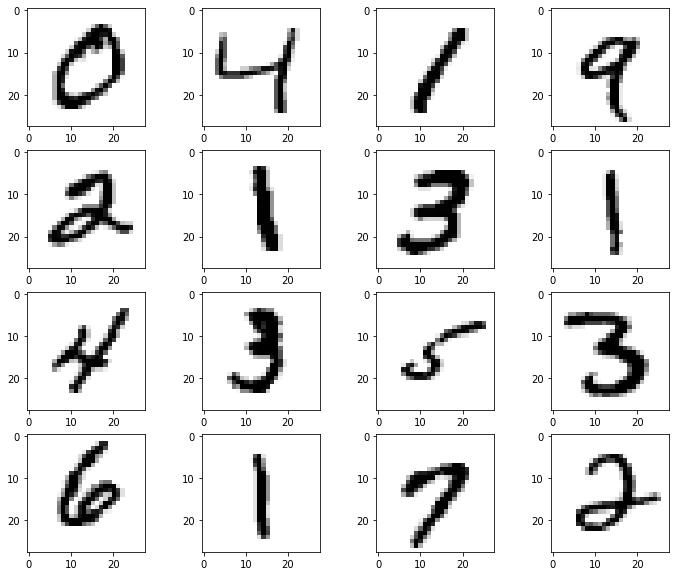

In [ ]:
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))
    

# Perceptrón multicapa

Primero, vamos a adaptar el perceptrón mutlicapa implementado en la práctica anterior, para que pueda clasificar imágenes de 28 x 28 en 10 categorías diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28, a un vector de 784 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

* Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

* La última capa deberá tener 10 neuronas (en lugar de 1 sola como tenia el perceptrón multicapa que utilizamos para hacer regresión).

* Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(NetMLP, self).__init__()
        # Inicializo los tamaños de las matrices W del MLP
        self.hidden1 = nn.Linear(input_features, size_hidden, bias = True)
        self.hidden2 = nn.Linear(size_hidden, size_hidden, bias = True)
        self.out =     nn.Linear(size_hidden, n_output,    bias = True)

    def forward(self, x):
        x = x.view(-1, 28*28) # Flatteneo la imagen, para poder meterla en las dense layers
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)        # linear output
        return x

Epoch 0, loss = 0.714637
Epoch 1, loss = 0.485558
Epoch 2, loss = 0.263957
Epoch 3, loss = 0.292677
Epoch 4, loss = 0.355747


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

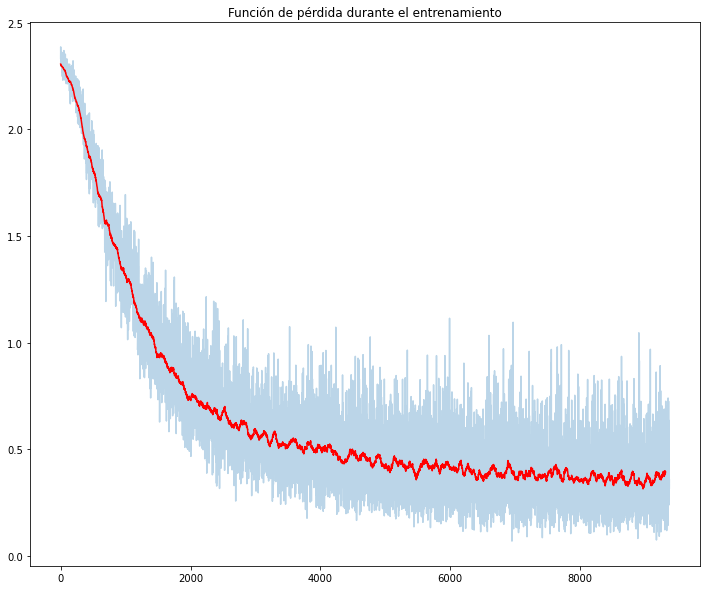

In [ ]:
# Definimos el modelo del perceptrón
input_features = 28*28
hidden_neurons = 15
num_outputs = 10

# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net_dense = NetMLP(input_features, hidden_neurons, num_outputs)
net_dense.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net_dense(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardamos el modelo para poder reutilizarlo

In [ ]:
torch.save(net_dense.state_dict(), "./mlp20.pth") # me guardo los pesos

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [ ]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net_dense = NetMLP(input_features,hidden_neurons,num_outputs)
net_dense.load_state_dict(torch.load("./mlp20.pth"))
net_dense.to(device)

NetMLP(
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.96      0.97      0.97      1135
           2       0.90      0.89      0.89      1032
           3       0.89      0.89      0.89      1010
           4       0.88      0.92      0.90       982
           5       0.87      0.82      0.85       892
           6       0.93      0.93      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.87      0.84      0.85       974
           9       0.87      0.86      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



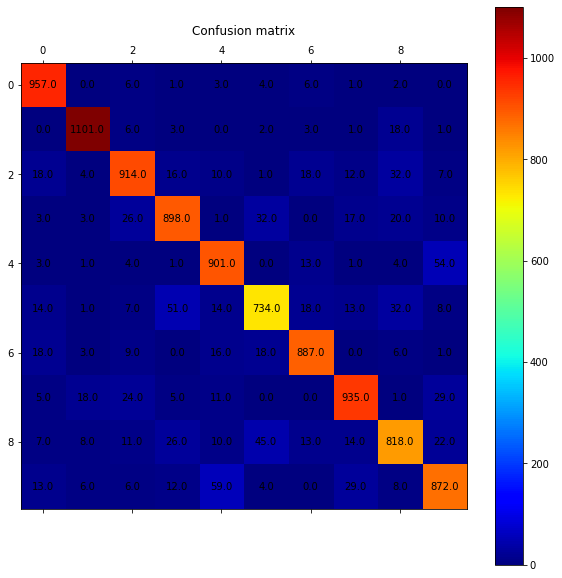

In [ ]:
def showTestResults(model):
  model.eval() # Desactiva las capas de dropout en test time y tmb se utiliza para batch norm, para el calculo de parametros en test time.
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

  # Genero un data loader para leer los datos de test 
  loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)
  x_test = list(loader_test)[0][0]
  y_test = list(loader_test)[0][1]

  # Muevo los tensores a la GPU
  x_test = x_test.to(device)

  # Realizo las predicciones del modelo
  pred = model(x_test)

  # Extraigo el índice de la predicción con mayor valor para decidir la clase asignada
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

  # Imprimo el reporte de clasificación (accuracy, etc)
  print(classification_report(y_test, pred_y))

  # Computo la matriz de confusión y la muestro
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')

  for (i, j), z in np.ndenumerate(conf_mat):
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
      
  plt.title("Confusion matrix")
  plt.colorbar()

showTestResults(net_dense)

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [ ]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)
        self.fc1 = nn.Linear(400, 120, bias = True)
        self.fc2 = nn.Linear(120, 84, bias = True)
        self.fc3 = nn.Linear(84, 10, bias = True)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1, 5*5*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

          

Epoch 0, loss = 0.369902
Epoch 1, loss = 0.312639
Epoch 2, loss = 0.162101
Epoch 3, loss = 0.0297363
Epoch 4, loss = 0.0279351


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

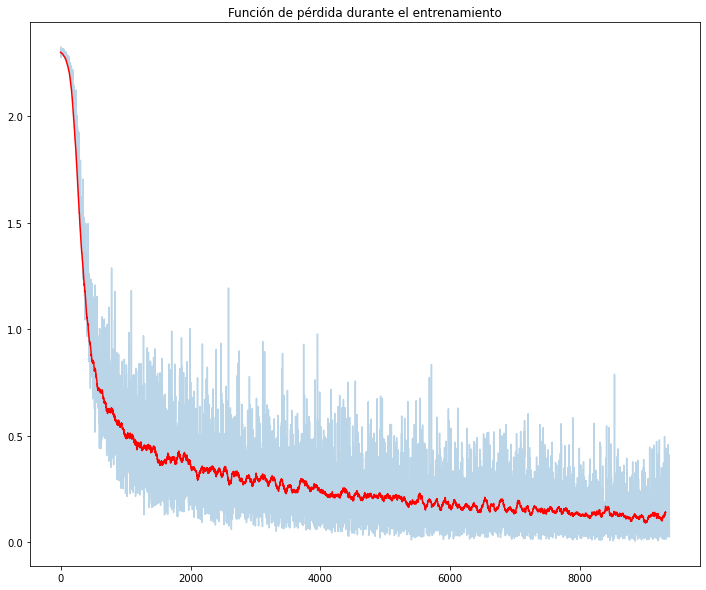

In [ ]:
# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetCNN()
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss() 

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardo el modelo

In [ ]:
torch.save(net.state_dict(), "./cnn20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikit-learn.

In [ ]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.98      0.97      0.98       982
           5       0.93      0.98      0.96       892
           6       0.98      0.96      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.97      0.93      0.95       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000



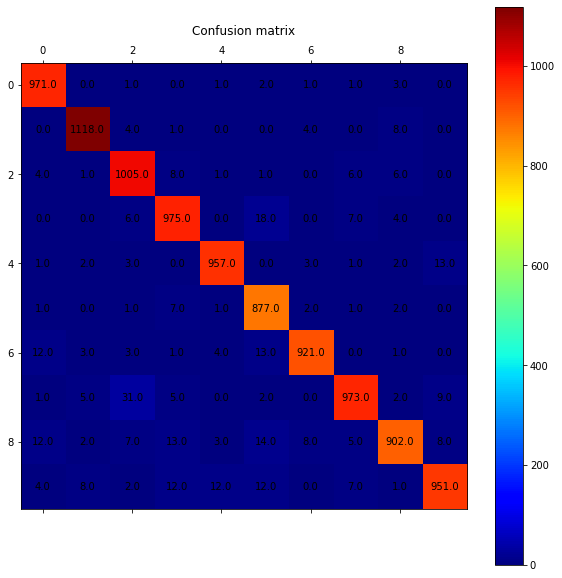

In [ ]:
# Mostramos los resultados
showTestResults(net)

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida por el perceptrón muticapa y la red neuronal convolucional. 

#**Continuación ejercicio 1 y ejercicio 3**
## Utilizamos DROP-OUT

In [ ]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)
        self.fc1 = nn.Linear(400, 120, bias = True)
        self.fc2 = nn.Linear(120, 84, bias = True)
        self.fc3 = nn.Linear(84, 10, bias = True)
        self.dropout = nn.Dropout(p=0.1, inplace=False)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1, 5*5*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(self.fc3(x))
        return x



Epoch 0, loss = 0.432164
Epoch 1, loss = 0.410197
Epoch 2, loss = 0.35005
Epoch 3, loss = 0.16615
Epoch 4, loss = 0.141886


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

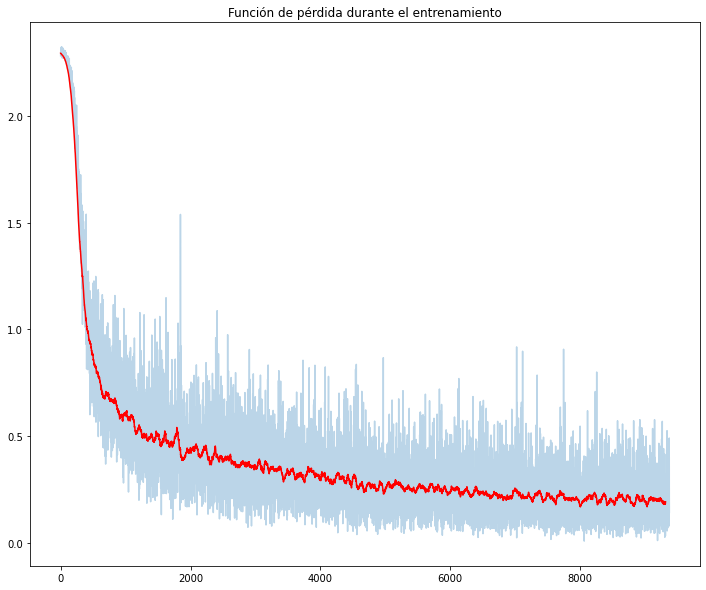

In [ ]:
net_dropout = NetCNN()
net_dropout.to(device)

optimizer = torch.optim.Adam(net_dropout.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net_dropout(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.97      0.96      1028
           8       0.95      0.96      0.95       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



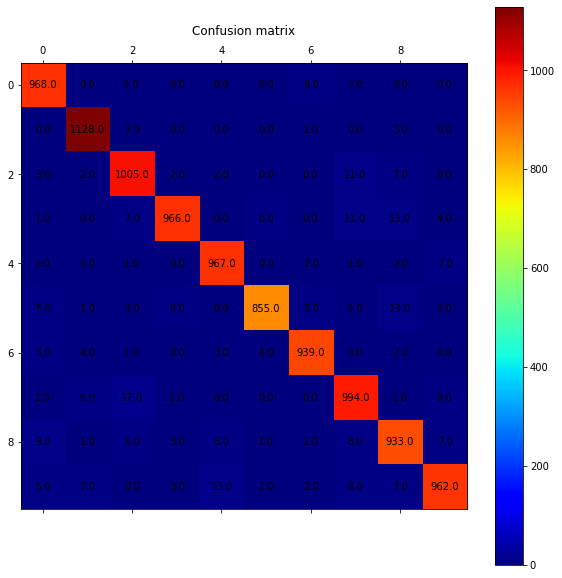

In [ ]:
showTestResults(net_dropout)

*Al utilizar el método de regularización DROP-OUT, no vemos una mejoría muy significativa en test time.*

## Aplicamos batch normalization

In [ ]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(400, 120, bias = True)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84, bias = True)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10, bias = True)
        self.fc3_bn = nn.BatchNorm1d(10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), 2)
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1, 5*5*16)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3_bn(self.fc3(x))
        return x

Epoch 0, loss = 0.511317
Epoch 1, loss = 0.374868
Epoch 2, loss = 0.324605
Epoch 3, loss = 0.222478
Epoch 4, loss = 0.136393


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

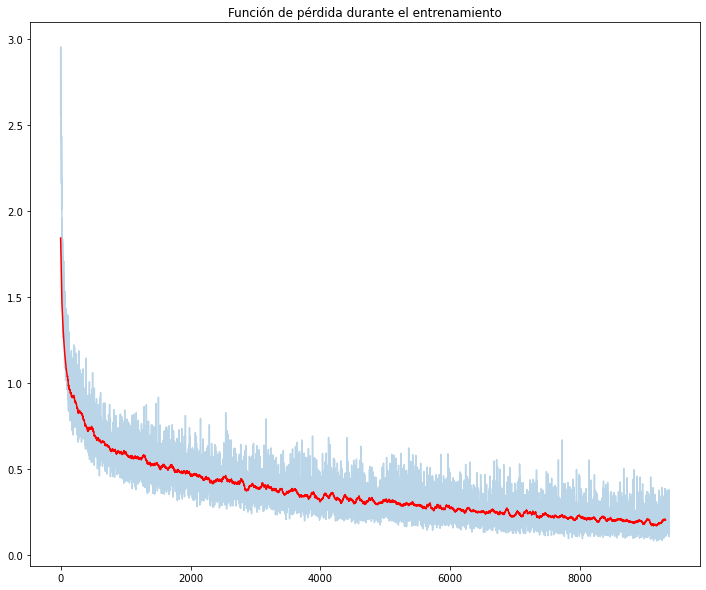

In [ ]:
device = torch.device('cuda:0')
net_batchnorm = NetCNN()
net_batchnorm.to(device)
optimizer = torch.optim.Adam(net_batchnorm.parameters(), lr=learning_rate)

criterion = torch.nn.CrossEntropyLoss() 
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
num_epochs = 5

loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net_batchnorm(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.98      0.98      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



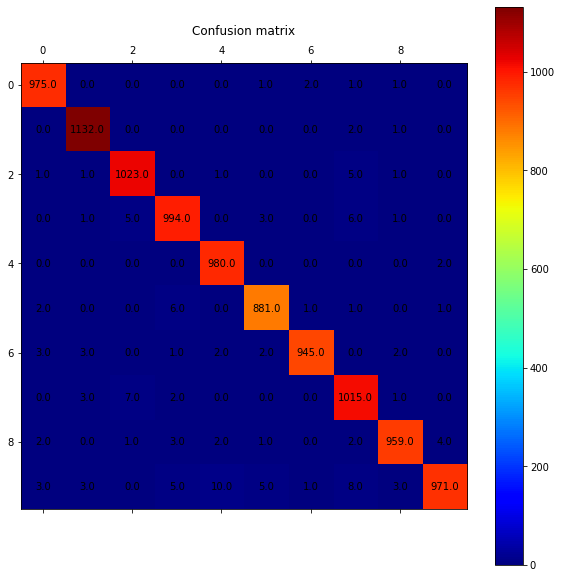

In [ ]:
showTestResults(net_batchnorm)

Vemos una buena mejoría al aplicar la regularización por batch normalization en la red.

In [ ]:
loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)

for data in loader_test:
  x_test, y_test=data
  x_test, y_test=x_test.cuda(), y_test.cuda()

In [ ]:
pd.DataFrame(y_test.to('cpu')).value_counts(normalize=True)

1    0.1135
2    0.1032
7    0.1028
3    0.1010
9    0.1009
4    0.0982
0    0.0980
8    0.0974
6    0.0958
5    0.0892
dtype: float64

*Observamos que el dataset está bastante balanceado, por lo que la métrica accuracy está bien aplicada*

In [ ]:
y_pred_dense      = torch.max(net_dense(x_test).to("cpu"), 1)[1].data.numpy()
y_pred_cnn        = torch.max(net(x_test).to("cpu"), 1)[1].data.numpy()
y_pred_dropout    = torch.max(net_dropout(x_test).to("cpu"), 1)[1].data.numpy()
y_pred_batchnorm  = torch.max(net_batchnorm(x_test).to("cpu"), 1)[1].data.numpy()

dense_score     = accuracy_score(y_test.to("cpu").data.numpy(), y_pred_dense)
cnn_score       = accuracy_score(y_test.to("cpu").data.numpy(), y_pred_cnn)
dropout_score   = accuracy_score(y_test.to("cpu").data.numpy(), y_pred_dropout)
batchnorm_score = accuracy_score(y_test.to("cpu").data.numpy(), y_pred_batchnorm)

In [ ]:
pd.DataFrame({'MLP (DENSE)':[dense_score], 'CNN (VANILLA)':[cnn_score], 'CNN_DROPOUT':[dropout_score], 'CNN_BATCHNORM':[batchnorm_score]}, index  = ['ACCURACY_SCORE'])

,MLP (DENSE),CNN (VANILLA),CNN_DROPOUT,CNN_BATCHNORM
ACCURACY_SCORE,0.9017,0.965,0.9717,0.9875


## **Conclusiones finales, ejercicio 3**



*   Si bien el caso analizado es de baja complejidad para los modelos implementados, observamos que el accuracy_score de las redes convolucionales CNN performa mejor que el de las FCN. Esto se debe probablemente a que las CNN sacan rédito de la estructura local, mientras que las FCN flatean la informacion y pierden esa estructura. Queremos añadir que, al aplicar técnicas de regularización (DROP-OUT y BATCH NORMALIZATION), logramos incluso mejorar la performance hasta dos puntos porcentuales. 

*   En los gráficos de entrenamiento, observamos que las redes normalizadas performan peor; en cambio, en test performan mucho mejor. Esto nos indica que la primera CNN tenía un pequeño grado de overfit, que con las técnicas de regularización logramos solucionar.





## **Ejercicio 2**

![NEURAL_NETWORK_page-0001.jpg](data:image/jpeg;base64,/9j/

---

4AAQSkZJRgABAQEAlgCWAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAFtB0EDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACq0l7ZxXEFpLd20V3chzbWsk8SXFwIwWcwQs4klCKCXMasFAJOADVmv5zv+Cr/hzxfJ+3P+z98XvhzFe3nxG/ZV/ZO+LH7VPg/SLKWSM+JU+Dnxu+D2qePPCE8UREt5F4x+E978QPC8dlHmS4vNXtVjV3Co2tKn7WfLzcvuyd2rq6SsnqrJtxTfRO/QipPkjzWvrFW8m9X11STaXW1j+i2WWKCKSeeSOGGFGllmldY4oo0Us8kkjkIiIoLM7EKqgkkAUkE8FzFHcW00VxBKoeKaCRJYpEPRo5IyyOp7MrEe9fkd/wAFH/ilpvx0/Z++AH7O/wAKdbe/T/goJrvh+KLWNKleG7j/AGXvDXhq2+NXxu8Y2cqMES3vfhvp+neESsrBJpPH9rbq6yyxuOI/ZO/aH0j9lL/gh18HP2gNXiivG+HP7MdpqPh/SZd5HiLxtqN/eaH4B8LqsREzP4m8aapoWhjyQ0qC/aVEbZimqMnTjJfFOqqcYW11uk276XnGUbW2i3fQn2q55R+zGHO5X06Oy/7dad79Uup+0sF3a3RnW2ube4a2me3uVgmjmNvcR8PBOI2YxTIeHik2uvdRSx3VrLPPaxXMElza+Wbm3jmjee3Eyl4TPErGSHzUBePzFXzFBZcjmv58/wBhX4TeNP8AgnR+078D/hn8Ttb1PUo/+CiXwFuvFvxM1bWLyS9+z/t5/De81j4kfEW2e7dhZ2MHi7wL4+1XS7J1EE3iDVPAlokEMzIsNr9Tft++E9S/ZZ8b6V/wVC+EaWttrHwo0PT/AAf+1v4B+32OjWXx5/ZsuNUtLaaeN9QuLPTZ/i38J765t9e+G15cXFrqGuWqXPgp7y+gl0jQrpuivaKEZqSnG9KdrKcruKi9fdvOMoJ66uDaSk+UVR8jk42cXacb6xjZPm21tFqTXZSSu46/rNJdWsU8FrLcwR3N0JTbW8k0aT3AhXfMYImYSTCJCHl8tW8tTufA5p09xBawyXFzPDbW8S7pZ55EhhjXIG6SWRlRFyQMswGSOa/JH/gn54cvP2sPHOvf8FRviiLS71D4p6Vq/gH9kbwML+x1i1+Bn7N+ka5qGnPczmwuLzTrT4tfFjWLG91z4jTQXF3qGgWn2bwYt7ZwLq2h2vpX/BYb/lGX+2L/ANkol/8AUh0Gp9l+9jS5tXKEJu2kZyaUktfe5G7N6XkpJaJNvn9yVS2iUpRV94pNpvtzWvbomr6uy/Riy1fSdSZ007VNOv3jAaRLK9trpo1JwGdYJZCoJ4BYAE8Vo1/Mt8Vfhj/wQ38J/sjX/jHRfE/7L3g34z6Z8GI9V8G+IPgL8YtItfjzZ/FtPBiT6BJ4P074c+MpfFmoeKx4uNoP7Mk0+7057tmi121GnG729vr+tftFftJaD/wSW/YU+P8A4s8f+B7n4/fBTxT8Y/2zbjT9X1Xwh8S/HvhX4TeCtHutB+G3iDWbCSx13SZvH+p6hCnxZtoLjTdb87z0kkt7qG6tpdPq6dmpTjFSmpe0puDShBzlKKv76srWVrSlFN63U+1eqajJ2i1yT5leUlFKTt7ru7310TdtNf6GNP8AEnh3Vry807Ste0XU9Q04ldQsNP1SxvbyxYNsIvLW2nkntiH+UidEIb5evFbVfkt8b/8AgkT+xtN8JPED/s/fCXRP2bvjb4K8NarrXwb+NfwcvdZ8D+PvBnjrRtNuLvw5qd94i0nU4NQ8S6dJfwQWuu2fiKfUXv8ATLi88m5stT+yanafCz/tL/FL/goR8I/+CRP7P+ueNPEXgPTf229E+MHi/wDas8T+AtRn8IeJfGHhX9lvQ5bTxV4M0rVNI+y3Og6P8ZPFdhet4hj0GSynstOaOyt5f7Jlu7O6mNGM1zQm+VNqbnFJxShKpzJRk1JOMJJJNPmsno+YbqOLtKKu0nHlldSbkoWbaTTTkruzVrtaqx/RxZeJPDup6hd6Tpuv6LqGqafn7fptlqljd6hZYbaftdnBPJcW2GIU+dGmG4PPFac1zbW7QrcXEEDXMogt1mljiaedgWWGEOymWVgrERoGcgEgYBr8svif/wAEeP2I9Z+G19onwV+Duhfs9fFnQNIurn4S/G74SX2veDviV4C8cWVpKfDfiN/F2l6rHrniFLXURAdVtfEN5qZ1Kye5XzYb5re/t/zs/wCGifGH7Vn7NP8AwQi+OXxCkS58eeJ/27vBmh+M79IYbf8AtjxN8Ol+MPw21nxBJBapHaQT+Ir3wjLr1zDZRQ2UNxqMsVnDBbpHCjjRjOzhOVuZxlzRSkn7OpUi1aTTUvZyW6cXunowdSUdJRV7Jq0m01zwhJapNNc6fVNdj+meqR1PTRbS3p1CyFnA7RzXZu4BbQyLIImjln8zyo3WVljZHcMJCEIDECrtfyd21ja6n/wQk/ba02+jMtjqH7ZXjyxvIg7xmS1u/wBtH4a29xGJI2WSMvDI6h42V0J3KwYAiaVL2n2uX95Shtf+JKSvuvh5b2690OpPk6X9ypLe3wJO23W9r9D+sJWV1V0ZWRlDK6kMrKwyGVgSCpBBBBIIOQcVHb3NvdwpcWs8NzbygmKe3lSaGQBipKSxsyOAylSVYgMCDyDX5Z/sA+N/FfwS8ZfED/gmz8a9cvta8a/s+aNbeKf2cfHOuSA3/wAaf2Q9Vvm0zwRqbT4jW88V/CC82fC7xwkMFtEn2DQLq0S8jmu79/ys+A/xA+JI/wCCWn/BJf8AZS+GfjTxB8Mb/wDbH+L/AIm+FPjz4k+ErxtL8YeGfhD4f+IXxN8UfEm08F6wg8zQfF3iHS7a20nS9bi3TWNrJqSwxGaeOaClQbbXMrKUUpWdnTlCpU9outlCm/dV3zXjdNEuqkk+V35ZXV9VOMoQ5O3xTWr0tZ7M/qIh8UeGbjWZ/Dlv4i0KfxDbIZLjQYdX0+XWbeNVDs8+lpcNfRIEIYtJAqhSGJwc1u1+Mfx4/wCCev8AwR3+EfgLSvBXxR0r4A/swa94kstXPw7+LPiH4t6V8KfjQniHQ47E3PjPwr8S/GHi/T/FfinxD4Z1HVdH1TUptQ1HXrFry/sU8QWVza6kLe5/Sr9mm78M3fwI+GMfg/47Q/tNeH9K8NQeHLT47ReJ/C3jKT4jzeGJ7jw7qOtX/ifwY8vh3WdXh1LTLvTNavLSae6bVrC9TVri41hL+eTOcIqKlB1Gm7e/TcU9N4yTcHqmnG/MvNXtcZScnGSgna/uzu/RxaUl3vaz8tL+5UUUVmWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVa3vbO8MwtLu2ujbytBcC3ninME6fehmETt5Uq/xRvtde4FWa/mn/4Jb3978C/2uvitNdXdwPh3+3P8fP21/C8Uc0rzWumftD/sx/Hjx94g0qGHzWEOnDx18EvFXiArBB+8v7z4YbmWVghg1hT54VJXs6cU1G3xXbur9Goxclo72aIlPllBWuptpu/w2Ss/O7aXS10f0nzXlnbS28NxdW1vNduY7WKaeKKW5kXbuS3jkdXmcb0ysYZhuXI+YZfcXNvaQvcXU8NtbxAGWe4lSGGMFgoLyyMqICzBQWYAsQByRX8zf7YviHUPj1/wUz/Zp+KNndXEnwy/ZO/b3/Zp/Y78FvFK8mk638WPH3gj4mfGn9oe/h5VEvvC8Phv4MeCL2MozJe6XfgFVAaT7x/4KM6Zb/tWfGr9l3/gm/HLdz+EvinrF/8AtGftSQ6ZdyWtxa/s6fBO9t5dD8P6k8JFxbWXxQ+L9x4b0GxvrYie1u/Dk8qyQ7Q5v2FnSvKynCVSbtf2cYavr7z5XF2096cYke1uqlo35ZRhDX43LRdNFzKXfSLZ+urTQrC1w0sS26xGZp2kUQrCF3mVpSQgiCAuZC20L8xOOaSGaG5ijnt5op4JVDxTQyJLFKjcq8ciFkdSOQykg9jX5m/8Ev8AxnrHiH9mzxJ+zD8XJYNf+J/7G3jrxb+yV8SodWt454/FfhfwSq2/wx8WTadeiZrzQPHPwjv/AAvJFdXwnj1q4ttYeUu3nxJ+e/xI+L3xe/4Ja+M9W/YD+C66P4m0P9rXWBL/AME4NU8U+JdHh079nbxb8QfGumeG/iF8OPiEmsXr6nL8Ofh3q/io/EP4T3P9m6nJrjyz+ApJNc1BrkaWlQcpzpqS54u6vpGUN3NPpaDjUs1rDms+aNm3VSjGbT5ZLW28Z7KLXW8k4X6StfR3X9HEF1a3JmW2ube4a2me3uBBNHKbe4jx5kEwjZjFMmRvifa65GVFVr3VtK00oNR1PT9PMoZoxe3ttamRVIDFBPJGXCkgMVyASAcZFfPH7JH7MPgv9kX4IeGvg/4Ru73X763nv/E/xC8fa0Wm8U/FL4oeJphqPjn4keLL2WW4ur3W/E+sNJP/AKXd3kmnaXDpmiw3Mlnpltj8n/8Ago54a/Zj8W/8FMv2D9G/a7HwqPwWm+BH7TU2qD4za7ofh3wMdcgk8IyeHxean4h1HStMS/8At4X+zoZLtZZrjCQpI/y1MKcZ1JRUpOKjOSajeUlCN9IX3l0V9Fa+txym4wUmoptxTTlaKcnbWVunV2t8rH7429zb3cKXFpcQ3VvKN0c9vLHNDIvTKSxsyOM8ZViKg1HU9N0izm1DVtQstLsLcBri+1G7gsrOBSQA01zcyRQxAkgAu6gkgda/nDutI/Y4+Gn7eP7Eeif8Eq/Engs+O/FPxJ16H9qTwV+zV8QLnxr8H7r9m+28MXbeI9b+Lmk+HNe8QfDzQ9W0XU209/BdzdjS9Zn1q5hKLdX0WgGH2b9m/wCA/wAPf+Ck/wAef2w/2if2uNIb4xeCvgt+1L8Sf2W/2c/gj4r1DUrr4T/D7wt8GI9J03W/HZ8DRXcGiaz40+Imp6tJeatqHiO01S4so7U2tqUsxp0On26CiueUpKCgpNOFql5VHTjHkckveaclJtLlTdr2TlVW3yqMXLmcU1K8GlFSb5rX0TSaSb5mlfqfuvp+o6fq1nDqGlX9lqdhcrvt77T7qC9s50BILQ3NtJJDKuQRuR2GQRnIov8AULDSrSfUNUvrPTbC2TzLm9v7mGztLdMgb57m4eOGJMkDdI6jJAzk1+Ffx7+BngL/AIJrftLfsW/HD9kzTJfhH8N/2jv2o/Af7JH7QnwI8NalqUfwo8bx/GXT9btvBHxDs/BVxd3GkeG/FngPVdBknXUvDdvp8l9bSwWckSWlxrqau/4HfBDwJ/wUp/ai/bV+Mn7V2my/Fn4X/syftN+L/wBkf9n/AOA/iPUtTb4VeDLz4QaTof8AwsH4hal4Ltru30nxT4s8a6r4itpY9U8RW+oCyslnsI45rW00NdGPYx5fac79ly81+Vc9/aez5OXm5b832ubl5dd/dH7R35OVc/Na3N7tuTn5r2va3S176ban7n6bqem6xZxahpGo2Oq2E4JgvtNu7e+s5gpKkxXNrJLDIAQQSjtggg81YjubaWae3iuIJLi1MQuYI5Y3mtjMnmQieJWLwmWP95F5ir5ifMuV5r8Hv2mvgH8O/wDgmx8a/wBkf9pf9kTR2+DXhH4q/tRfDL9mj9pD4KeEb/UrT4UfEfwR8ZG1LSNO8ZnwJJdz6FpXjj4ealp8N7oV/wCH7PSprsXbQXkjWqXkN97v+xp/ylH/AOCyf/YY/YF/9Zm1Ck6S5HUjJuPI5q8bSvGrCnKMkm0rOakmm01bRa2FUfMoONpcyi7O6s4SmpJ2Td+VpppNPvofrTcXNtaRGa7uILWEMiGW4ljhiDyMEjUySMqBndgiLnLMQqgkgUjXdolzHZvc26Xc0bSxWrTRrcyxJnfJHAWErxpg7nVSq4OSMGvyM/4Ljf8AJgfiL/stv7Nv/q7vBVfMX/BQn4O/Ff4pf8FNvhr4p/Z+1ubR/wBob9nf9gXxd+0N8ErU3Bh0fxj4w8FftH+ENA1b4aeJohJb/avD/wAT/AXjDxl4Duonu7OCO68QWV1dXUVpb3Acp0VNRbmop+11a0Xs1Ttd32k6iTdvdSbs7NBOo4uSUea3s9E9XzuV7eaUG0ur000P6Eprm3tvK+0TwwefNHbQ+dKkXnXEpIigi3svmTSkERxJl3IIVTim3d3a2FtPe31zb2dnaxPPc3d3NHb21vDGC0k088zJFDEigs8kjqigEsQK/DL9rH9ojwV+1j+zp/wS8+OvgRLmy03xX/wVA/Yjk1nw3qWU17wN4x0vx54g0Xxj4D8S2zxwzWniDwh4jg1DRNRjlghE7WqX9sj2N5azS69l8ONA/wCCi/7fn7Xfg/8AaPi1Dxj+zZ+xNdfCT4cfDH4A3Gr6rYfD3xd8TfG/hGXxv4z+KnxK0DTLyxj8YatojC28PeDLDXJNR0C00e4lvI9Lh1E3M90KjaPNNuKiqjmuW8ouFSNNRSuk3KUurSSTbbVrntLu0UpNuCi72T5oSnduzsko9E29rJ7ftTo2vaH4isxqPh/WdK13T2keJb/RtRs9Ts2ljxvjF1ZTTwGRMjegfcuRkDIrVr8XNN+BP/BLf4OftUfDvxZ+z1+018C/2Tfjb4H8bzeCviB8GPhH8ePhf4Zs/jJ9qefw+3wf+JnwW1LxJdWcutReILiGGxTTvDen+MbPV8w27LrcOi32jftHWc4qPLbntJX9+Dg1r/4DJbNSi2rPWz3qMnK9+W6dvdkpJ/qnurSV9OqCiiioLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr4A8efBzx9r3/AAUj+CXxjj8Iyal8ItA/ZG+OXwz8VeJZrjSZNNtfFPi/4hfDTV9G8O3ml3F4NTu/7X0jRNWn8yHTbjTlitpIru4ieSKKX7/oqoycb2t70ZQd+0kk2vNW0FKKla/SSl84ttfLXU/ET9jP9in45/C74qfG25+LGkC48Afs4fCfx5+y7+whI+r2GqXGvfCD4g+PfGHxRvfE15F9uuH0fxBpnhu5+EvwVgmuU02Z9K+H19GYha3Mtze+M+Gv2H/j58YP2cv+CWn7Efxo+F3iTwx8BPhl4evvib+2LdweMdP0a5HiL4faZrFr8KvhDaar4N8VReI57jWvE+tTa3rt/wCG7qO30uz0/SdTsdbi1a0gWH+iGitvrE7uVo30aaTXLJQnBSVn8X7yc7/zycuyWfsY2td21TWmqcoys9NvdjH/AAq3mfh3+1j/AMElvhp4Y+EsvxW/Yv8ACnxDt/2sfgd4q8GfGT4EjxT+0H8bvHul6r4s8AeKNK1688Ky6N8VvinrvhND4v8AD9rq/h6O5uorEi4v7eK41CLT5b2Kf3H4j/Cb41ftu/tF/C/QfjN8MNa+Fv7F3wK0nwL8Zde8GeKNV8N6hf8A7R37Q99ZQaz4d8FeINL0HV9VMnwv+At8z3XiC01pLPTfGnj+2to4tN8Q+G7Wx1W0/VOip9vUsrvmlHnUZyu5RU0k7O9tLNxuvdcpNatWfso3dvdi+XmircsuVtq/Xqk7PVJJ6b/mB8FPgd8Xf2Pv2wPGnhH4V+DL3xT+w3+03N4h+KUllpWoaNbxfsqftAKEuPFlrYaHf6lZag/wo+MmV1Sz0/wzZ6rF4W8aCeKLSdB0F7q+1D1j/gpf8KfiB8cP2EP2mfhN8K/Ddx4v+IXjn4dyaN4U8NWl3ptjc6xqZ1rSLoWkN3q97p+mwOYLaaTfeXtvFiMjzNxVT9z0VPtZc8KllzQ5HfX3nBqzlrq2lFNq17Jv3rtvkXLKF3yy5tP5VJO6j5XbaT2u1tZL5v8Agp+zh8G/h14U+Ht/p3wO+FPhHx5o/hDwvb6nrGi/DzwXpniG11y00Sxg1Fn1vSdKju3u1vY5hLdRXkhlkDSCZwwc/Mv7eX7OXxv8W/ED9mr9rr9ley8N+Iv2hf2Ttf8AGrWnwy8Xa0nhjQPjT8K/ihodt4f+Inw7fxPOj2Hh7xLLaWNreeDNa1lf7F0rVHu7q+If7Oy/oJ4v8a+Dfh9oV14o8e+LfDPgjwzYtEt74i8X69pXhrQrNpm2QrdavrN3ZafbtK/yRCW4QyN8qgnitDQte0PxRo+m+IvDOs6T4i8P6zaQ3+ka7oWo2er6PqthcLvgvdN1PT5riyvrSdCGhubWeWGRTuR2HNCnOMvaav4l73NKLUk1KDu9nGTTSkmlZqzSYOMWuXbZ+7ZNNNNSVuqaVm0101Wh+SnxM/aa/b6+PPw88R/Bv4K/8E/fil8D/ib480LUPBmr/F74+fET4S6d8KfhDD4gs5tK1TxppV14M8WeKfE/xJu9Ct7me40Kw0Lw3btcagtnf3NpdWNvcaddYXxW/wCCdvxF+DvwX/YL1r9ja78P+Jfjz/wTo/tOPwdoXjq9HhfQfjp4S+IXhqPw/wDHjwjqOrIbi18Ja78R2WXWNB1O9kuNI0HUZ57SeWCK4TVLP9nqKpVnGyhCEIpuTj70lNyi4NScndx5JSikmklJu7l7wnTTvzSlJtJJ6JxSakuVJWT5knd3u0ltofkZ44/aw/b/APix4I1n4Y/Bb/gnf8Vfg78ZPFOkXfhub4nfHD4mfCCx+DXwlvNXtpLC48bW2ueEPFfiTxJ8R08NNM9/pumeHvCtvdalcw28rWzwLLaS+HfHf9ij4mfs3fs6f8Evfhl+zl8LvFP7REX7Fv7SPgr4lePdJ8Kaj4P8M694js7Dw9491Xxx4l09PGviTQtHsz4j8deKL27s9MfVrmWxXVYbeWa4jtpbs/vJRTVbla5KcIxUnJxvN8zcJQ96TfNZRnJRSta7er1E6V7805NtJJ2iuVKUZaJK124q7d72toj4g+Dn7Ufx7+JHxE0Hwb43/YL+PvwT8M6smrNqHxL8ceNfgTq/hnw82n6NqGpWaajp/gv4l+IfEk7axfWltolmdP0i6EV9qNtNeGCyjubmH8vLH9jb9piH/gkp+1J+z0/wq1RfjN47/ai8V+PfCPgb+2vCv27WvCd/+1L4E8fWesw6j/b39h28U/hHSdQ1lbe91S2vFhtmt3tlvXitn/oiopRrcj9yEYrmpzteb1pylJayd7Pms12StbUbp8ytKTfuzje0VpNJPZW0tp+Nz8/P2+v2dviB8SfDnw9+P/7OlvaR/tb/ALKniS4+IvwVFxdQada/EPRry3Sx+JnwH8R6hcS28Efhj4u+FEm0Uvc3NnFY+IrbQb46lpdql/dV8FfDL9gf9ou+/wCCYH7Fvg7StN0n4Tfto/sefEV/jx8NvD/ji+s9Q8Oy+LtH+I/xC1G4+HHjPVfDN3qdt/wjXj7wX4nNle3Wl3cnk3cmlNcz2kEV95X78UURrTjCMFy+7PmTau7WknB62cHzz0f80rNJhKlGUnJ396PK0nZXvFqS7SXLHVdldOx+Nvjf9oT9ob4taTpPh74gf8EX/Gnj74yaJBeWmmWvxO8Y/sx+Ivgj4e1PUltE1W70v4wa3r+sXaaBcy2Fnc3r6V4Kj1LUrawtIfsct3Fbon1r/wAE5f2avGP7In7G/wAIPgF8QdS8M6p418It4/1nxHL4N+2N4Xs9S+IXxN8ZfEiXRNEm1C2s7u7sfD6+LU0KO+lsrIXzae13HaW0U0cSfbtFKVXmhyRgoR5lJpSnK7SaVueT5UuZ6RWrerdkOMLS5nJylZxTaitHa9+VK7dlq3p0SuFFFFZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFfP/wC1j8SfEnwa/ZY/aW+L/g02A8X/AAq/Z/8AjJ8SfCp1W1N9pg8SeBvh14j8T6GdSsllt2vLAanpdr9stVnhNxb+ZCJYy+9Wk5NRW8mor1k0l+LQm7Jt7JNv0Sbf4I+gKK/HP4F6d/wVZ+N3wR+Dnxotf2vf2XfD1r8XvhX8PfihbaBcfsneIdRn0ODx/wCEtI8Vw6PPqEfxrs47+bTI9WWylvI7S1S6eBp1t4FcRL337V/w/wDiR4e+Gln8S/i18R/2vfip4k0L4TaN4I0/wH+wtJ8QPhRBafGG20rxPrHir446no/w88d2Oua3pGsXsGh6dpfhnx3qni3wR4OtNOgtn8OeI77xBfXNaeySkoupBu7jaPNJpp2trGmt7q/Mlo/K8e093mUJWsnd2Ss1e+8ntbTlvqvO36nUV4B+yj4j8SeLv2Yv2evFHjPxz4b+JvjHX/gt8M9V8W/EPwfcQ3fhfxr4nvPB2kTa/wCJtDube2sYJ9P1nVmu76CWKw06NxMSum6cD9ig8w8R/wDBRb9g3wh4h17wn4p/bA/Z38P+J/C+s6p4d8R6Bq/xW8IWGraHr2iX0+m6vpGqWNxqiXFnqOm6hbXFle2k6JNb3MMsMqq6MBPJJylGMZScW0+WMpbNq+kW0m1pdL79CuaKSbaimk1zNLdJ21dm1fo2fZ1FeVfB/wCOfwb/AGgfDF540+B3xP8AA3xZ8Jafrd14avvEnw/8SaX4o0a08QWVjpup3mi3GoaTcXNtFqVtp+saVez2byCeO21GzmZAlxGzfNX7Quo/tx+MfjT4W+D/AOzT/wAIF8FvhYPh7eeN/iB+1J8RfBsfxYK+Jm11tH0f4T/D74Y2vjnwa8viBbKM+JNe8QeKLhNCGj3UNvpU/wDatlNa3qUG5OLag0m3z3jayu7prmvqrRUXJ30XVDkkk1eV7Jcut79tbW3u20l1Z91UV+bv7Dv7Rfx58dfGH9r/APZY/aPufh/4v+JH7I3ib4S2qfF/4Y6DqPhHwx8SfCnxo8Faj418Myal4P1DWfEQ8NeNNBs9Mkh8T6dY6xNpqPqFlBZQvHanVNV/SKicHCXK7PRNNO6alFSi07LRpp6pPo0mEZKSur7tWas002mnvs01u12YUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX4W6T+yN+0Jpn7F/wAWv7F8AvYftKfCX9vv4z/tl/s3+HNQ1jQ4/wDhLLvS/jnrnjLw5pR1K21OXTrOw+L3ww1jxT4HeDUr+wa3tvF5XWY7RY5oh+6VFaQqOF7JO8oSd/7jk7b7SUpKXk9LMiUFK176KS0/vJa+qcU15o/DuP8AYt+NXhT4A/8ABM/w3H4Wm8VfFXwn+3z8P/2uf2utXtL/AEWOTTvFfjjw/wDGbxR8YvFWpXd1qcCa5beHfGPxAsPCVm2kyajqF3pNhpbWtrPbwySR6nw//wCCd2n/ALVP7Q37V/7Un7b3w++IGh674o+JcHwv/Z18JaL8aPiD8Przw1+zh8MdKttN8Pa5c3HwV+IugCV/ilr9zqfjHUvD3iC+1KXRb+ET28NhJqF1HJ+2FFX9YqWdrRk+b3o3Ukp1FUklrZJtRjt8EVHuT7GGl7tLl912abjDkTfVtJt7/E2z8a/h1+yJr37BH7amofEH9l/4VfETxp+zP8fP2ffEen/Gzw3D8R9U8e+KNB+OnwZkvfEPwq8RnV/jJ4/vfEuqP8QvDeran8L9Cso9XuNI0fVmgvdZu/D+i5uQnw5/4J4aj+078MP2gfil+3roiWX7SX7W+l22mw6bpGo2erXv7Ivw18K6o2s/BX4cfCzxBaSzWlp4l8Ca3Bp/j/xhr2jTQWXi3x6ZF1WLU7S0ludS/ZWik69Te9p2hF1Ffnag243d+r5eay95QindJpnsobbxvJqDtypySTst+9tdHKTWrTXx3+xFrP7TkvwbXwP+1z4Ul034x/CjXtS+HV98RrW+0e+8N/Hrw74fcW3hj40eH003Uby80pvGOkrBP4g0XXrXSNWs/EMOo3J0qws760s7f5+/aO/Zg174x/8ABRr9j34neIfhNofxE+A/w++Cv7Q3h34gaj4q0/wrr/hrR/E3iqPw43g60vfDniCWe5vrq+nsbl7O6s9HvYbOSEvPcWpKFv1FoqVUanKcUouSmrRukudWfLrddWleyvZaJJVyJxjFtvlcXd2bfK7q+ln0T0u7X3ucb4M+HPw9+HNnPp/w98CeDPAmn3TpJc2PgzwvonhezuJIwwjee20SxsYZnjDuEaRGZQ7bSNxz+Smj+B/2qf8Agnz+0F+0j4l+EX7Pmt/tW/smftRfFXVv2hLvw98MvFng/QvjN8EvjN4wtLKD4lInhbx1q/h7SvHng/xpfadZanpS6FrNpeaEYBa3dugie51T9hdY8Q6B4eGmNr+uaPoY1rWLDw9ox1jU7LTBq2v6q7x6XoemG9ngF/rGpPHIlhplr5t7eOjrbwSFWA2KI1HHmulOM0lJS5ves7pqSfMpReqabtdppp2CUE7WfK4u8XG2l1ZqzVrNbppd1qrn46T+A/2nf2+f2iv2cvH3xo+AOs/sr/ss/srfEWL47+HfB3xH8WeEPEPxl+NPxu0XTL3Tfh1qd74c8C6t4h0X4eeE/h7NqWpapMura5d61rN5ObSC0a0vftuj1j4B/am/YK/aa/aL+JfwT+Amq/tVfssftXeOYvjT4r8EfD3xb4S8OfGT4K/Gu80u10zx3rWlaD441TQNF+IPhb4gvZWWotb6brFtrGm3cUFvJFaWulPc+Iv2UoqvbPbkj7Pl5PZ+9y25ue/Nfn5+f3ue976W5fdF7Nb80ufm5ufS9+Xlta3Ly8unLa3W99T8bNe8FftQ/wDBQj45fs5ax8Wv2edf/ZT/AGTv2aPi1on7QzaJ8UfFfg3WvjN8b/i94Jtb6L4aacPCfgLWPEel+BfA/hHUdRvdX8QHxDrl5d+JWkt7KysECC9suZ0if9qX9mL/AIKB/wDBQz4taB+xT8Yfj58Nv2lL/wDZYuvAPi34c+Mvgxo1mE+EfwKtvCXicX1l48+IfhrVo2/4SDVbnT7f/QFDvpN5Lzby2k0/7c0U/bbx5IcnI4KF5pJOcajfNzczk5RTbb1SSskkhez2fNLm5uZytG7ai4JWtypKLaSXrds/GP8Abi0j9pP9t/8AYQ8YeFtE/ZQ+Jvwq+J0Px2+Ck+mfDHx34p+Fd9r+ueFfCHxE8CeLdc8Y2WqeF/G+seGYdJtbFdWhNnfazbaxJPol55WnyJPZG5+o7/4SfEaX/gqL4V+PEXhi5f4SWP7BHjz4R3vjMXmmCzg+ImrftC/Drxlp3hlrA3w1lrm58N6LqWqLeJpraYkVq8Mt6l08UEn3zRU+1ai4qMVG1RJe87Kqqalq3d29mrX7u99LVyK/M22/cu9FfkcmtEuvM7+it1P5+f2tP2Gf2ifDv7Y/wR8Tfs0eC18Xfsv/ABg/ba/Zn/as/aF8LWur6JpI+Cfxg+DfxA0keN/i1omn6tqemm90T4s+BNSn1DxlpuiW2p6vc+LfB51VtgvLHT7r6W+KHww/aa/ZO/bF+K37W/7Nnwd/4aV+En7T/hj4fWH7RfwU0Lxh4c8GfFDwp8QfhTpNx4Z8J/FP4ayeMLrTvC/iXTdR8ITjR/E/g86jputX2qxxatFd3EYVbL9cKKr28moqUYyUYOnJNP34txd5NNPmjyQ5ZRs1ypu7vefZRTbTkm5Katb3Wk17qatyvmleLutXa2lvwK+Knwi+MH7dPxC+EMPhP/gnbp37Ivh/wn+0R8MPjz8Uv2kPjm3wb0b4p64nw58Vw+LNS8J+GPB/wtu/F/jHxBrPjK6jC3fiDxF4l0rRSyE38sk0wlg/fWiionUc1FWUYwvypOUviabblNuTvZdkkrJLrUYKN3dtytd2itlZaRSS3fdu+rCiiisywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAor83/H/APwU6+EHgj4yfFT4GaR8Ef2v/i940+C+p+HtH+Idx8Cv2cPGXxZ8O6DqHinw5YeKtDt7vWfCj3aW0l/pF+ksCX0NnJNJbXqwJKtrJJXqPw1/bIk+MHgn4l+JvAv7L37W+l+IPh+vhaDTPAnxh+C2qfAnW/iDqnjC/vtN0638G6h8T73QdCvtN0Sey+2eONak1GO18I6NPb6leR3LXFraXGjpVElJxaTs024rSVuV/HdJ3Tu4rR3dlqRzwbspJtX0Sb2vfaNrqz676bn2fRXzr+yd8ctT/aS/Z/8AAHxo1rwhaeAtX8YL4oj1LwjY+IZPFdnol74Y8Z+IvB9zb23iKXRfDsmrQyy6A11HdPommkrcCP7ONm5voqoknFuL0cW01vqnZ6rQpNNJrZpNejCiivL/AI0fGf4Z/s9fC/xh8ZfjD4rsfBXw48CaauqeJfEV/HdXEdpDNd2+n2Nra2NhBd6jqeqarqd5ZaVpGk6baXWo6rql7Z6fYW091cxRMJNtJJttpJJXbb0SSW7b2BtJNt2S1beiSXVnqFFfnn8Nv+ClfwS8d/FD4ffCTxV8OP2k/gH4m+MDXsPwcvv2iPgd4m+Fvhn4q39jZ/2lNpHhDX9QkvbP+2307ZeW2j6//YWo3Sz2drBbPqGoafZ3X6GU5QlBpSi43V1e2qva6abT1TTs3Zqzs9BRlGV3Fp2dna+j31TSe2u2q1V0FFFFSUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/OH/wT2/Zp0D9qn4B6v8X/AI0/tf8A7aVj451D43fHfw9NZeG/2z/ix4O0az0bwp8UfEmhaBa2Ph+DxL5NjDb6XZ28SrEFiYIDGiJhR/R5X89P/BNj/gmR+yx8Sv2ctT8Y/tPfskeGNX+LOrfHP4/PqGpfE3whrmk+KrzQk+K3iVfDM8tpqT6dctp0ui/ZX0q5FsILqxaGeCSWJ1kbpoyUaVVuUoPmpJOEYSl/y8ukp9Nr28rmNROU4JRjLSeknJL7HWPXtfzPvXxH8Kv2W/2dPBHwYt/GR+Kn7UHizQviN4s/4Zz8O/Eb4geJf2gPin4w+KHjXw9dWer6Z4Zj8X68dC1F9H8L2GrS/wDCT+NpbXwz8KPDbeItdvPEnhPSrnV7+X6I/ZK+C2p/An4RP4T1q28P6Tq/iP4i/Ff4p6j4S8HMzeCfAFz8WfiN4k+IR+H/AINLWWmibQPB0fiCPRE1CLS9It9b1C11DXrfRdFh1SPSbLlz+wD+xofBPgX4cL+z18P4fA/wzvfFmpeAfDlvaX9rYeFb7x1cWd34vutI+z6hFPBL4guLCzk1FjM4mMCKAqllb3n4WfCH4bfBPww/gz4V+EtN8F+GJNTu9ZfR9Le7e1bVL6K2hu7wm9ubqbzZ4rO2RwJdmIV2qDuJic04tKU5Nyu+ZKzSbcbWlaO7bSjrJ72STqMWpJtRSSsuVu60Sd7q72SV3oltds+dvjL+2Hrnwg8fan4Fsf2NP20fjFb6ba6Zcp48+DXw2+HfiTwDqZ1KwgvntdM1bxD8XPCeqT3WmNObDU45tEt0gv4J4oZLmJVnfs/2fv2lNV+PGoeJbDUf2Zv2nvgEvh2z067i1D9oHwP4M8Jaf4kbUJ7mFrPw1N4V+IvjiW9vNPFsJtRjvINPjhgubZopZ2d0j4z4y/BL9sTxr4+1PxD8IP24YPgl4FurXTItN+Hj/syfDb4ltpVza2EFvqV2fF3iTX7DVr7+1b6OfUBBPbJHYi4+yQF4olY9n+z98LP2lPh5qHiW5+PP7VUX7Rdhqdnp0Hh3To/gV4H+D58L3ltPcyahem88Jaxqc2t/2lDLbQC2vVhjs/svmws7TuFTVPk05Oay+1V5r6X0cFC/lzW7N6Aufm15uW7+zTtbpqpc/wCF+6OZ/bB+DvxP+NWi/D7w74c/aC1f9nf4NaN4n1HxV+0f4k8Fa9eeCfiX4j+HWhaDe3dp4W8KfEi1aP8A4V/pF3rCx3fjfxBDc6bqSeHrOSGx1W1ia9gu/wA9f2QdS0/wx/wUI1L4cfsg/tC/Ev8AaR/Y4uf2ddU1/wCMc/iT4w+I/wBor4Y/Cn422vi/T7TwbYeBvi/4g1XxNHaeLPE2gyahNr3gDTvFeoSpZLe63qlkv2XTU0j7z/bJ+PfxL/Z//wCFUeILD9n/AFr47/s8eI9d8T+FP2mz4I8Oat49+Inw/wDCWq6CsPhjxTo3w20mG7n8aeETqr39t8RbdLDUbjT/AA+Elt7GdrhwvwH+zrp/gX4m/wDBQr4b/GH9hn4HeNfgb+zX4Z+DfxO0b9p/xfL8FvFP7Ofwu+N3irXW0WL4SeGtC+Hvibw94Kl8W+OvAmq22r65rHjWDwgslhos8OjXevvHLYWVzrT5vYzvbkdOpyv93yc118f/AC89rdWpeq0cbkTt7SNvi54X+PmtZ/D9jks/f9H9qx+69FFFcpuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8g/8ABQj/AJMH/bg/7NB/aV/9Ux41r6+rH8Q+HtA8XaBrnhTxXoej+J/C3ifR9T8PeJfDXiHTLLWtA8Q6BrVlPpusaHrmj6lBc6dq2j6tp1zc2Gp6Zf21xZX9lcT2t1BLBLJG1RfLKMt+WUZW78soyt87WFJXjJd4tfemv1PxQ/Y5/Yb+MXir9kX9lfxPpv8AwUa/bQ8F6d4j/Zw+B+vWHg7wze/BNfDfhOy1j4ZeGNQtfDXh9dU+EGo6muiaFBcR6XpS6jqF/fCwtbcXd5dXHmTv95eIf2RPFV5rOj+KvBf7Wn7RXw28ZTfCvwX8JviV4j0KT4VeI/8Ahamn+CLfUItN8caxoXxB+Gfi/wAOeFPijLNrOtXNx4w8BaV4ajuW1N4b/SL6Cw0iPT/r/QNA0LwpoWi+F/C+i6T4b8M+G9J03QPDvh3QNNs9H0LQNC0ezh07SNF0XSNOhttP0rSdK0+2t7HTdNsbeCzsbOCG1tYYoIkRdarlWnKTd0k3JpclPaTbs7U0paW3vqrrXUiNOMUlZ3Sim+ae6SV1eWnXa2jttoedfCH4VeDPgd8LvAPwe+HlhPpngj4beFNG8HeGLO7vJ9RvY9J0OyisraXUNQuWa51DUboRm61G/uGM17ezT3MvzytXwX418W/tlW/jLxbB4c/4Jf8A7PXjbw9B4m16HQvGer/tceCdA1Xxdo0eq3aaX4n1PQbn9m7WbnRNQ1+xWDVb3SLjV9Vn025u5bOXUr6SFrqX9OaKmM7NtxU3LV8znu2237s4O7bd739EU43SSbiltyqO1rJe9GW1ulj5+/Zu1P4qar4E1K4+L37Pfgj9mrxMnim/hs/AfgH4maT8VdG1LRF0rRXtfFVx4i0bwH8PLW01K/vpNR0qbRn0S5ntrbRLS8fU501CO1s/Bv2iPjr+zx44+KGs/sCfFn4h/Ez4HeMvH3ww0P4q+HPHmgeOZfgqvivQtL8b263Oh/DL4taZ4hsNYbxfZahoDR+KvDFnBa3d34Sn1JH+26Vc3wT76ryb4ufAX4IfH7RbPw78cPhF8Nvi7omm3Ml5pemfEfwX4e8Y2ulXkqokt5pKa9p98dLvJY40ilurBre4kiURPI0eVpxlHn5pJpatcj1jLSzXPzc1mtpN3vvohSi+Wyab68y0ktbp8vLa/dLS22rPys/4JgR6B8L/ANo39uH9mD4OeLrH4yfs9fDDVfhZ430b40zQeFdZ8aTfFb4laPrN58Qvh98Q/i14U0zTYPjP4i0H+zNOuovEWvtqfjLwxYyR+FvE2sX0lvYpa/tZXC/Dn4X/AA1+D/haz8DfCf4f+C/hn4M0+SWay8KeAfDGi+EfDttcXG03NzFo+g2VhYLdXRRHurryPtFy6iSeSR/mruqKs1Um5JPVRV3bmk1FJylayvK12krLZBCLhFRbW7el7JNtqKvrZXsr6hRRRWZYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH5R/8ABZfxR4u8K/saQXPgvx543+G+qaz8ff2fPCt74p+Hvi/XPA3ii20DxP8AE3RdH121s/Enh690/U7GO8026nhuPLuRE6HEyOgKnQ0//gnJ8DLS/sbqD9sL9ui6mtry2uIbW5/bu+Ld3b3MsMySRwT2r+JGS5hmdRHLbspWZGaNgQxFZn/BZr4c658Vf2NrPwTofgvXfH7ar+0H+zsNZ8NeH9C1TxDd3XhqP4o6GfEU11p2kW11djSrbSmuZNUuzGsFpZiWa4lijVnHq+kf8Eov+Cc2gatpeu6N+yF8HtO1fRdRstW0rULfRbxbix1LTrmK8sbyBjqDBZra6hiniYggOikgjiuqM1CjD35wbnVvyRpyv/Dtzc2q626WbsYSi5VZ+7GSUafxOat8V7cunr8j84P2y/jnoXj748/D3x38TtD+OPhvRv2eP24P2dfAvwS8Dzfs6ftEXOj39t4f+Nfhj/hb/wAeZNf0z4YXvhDxZ4h8ajTZPBXwb0Pw7reua63w+sNVvfDtpdat8XNS0LT/AOg7UtZFj4ev/ENtpmr6ytno11rNvo2l2X/E/wBVFvYyX0Wmadp2pS6d/wATe+CLa2dlfzWP+myxwXUtr+8dM7xZ4I8JeOrfRbTxhoGneIbbw74q8N+N9Dh1KHz00vxb4P1SDW/DGv2gyvl6jomrWtvf2E3PlXESPg4xWvrVrqV9o2rWWjaoND1e80y/tdK1s2MGpjR9SuLWWKx1Q6bcvHbaiNPuniuzY3EiQXfk/Z5XWORmGU5xlGnFRceS6tzXVm4vTRNXak29XeXWyLhBxc22nzWe1ndKS11a6pLZWXTU/O7/AIeIeJ/+kcn/AAUk/wDDM/CH/wCiAr7s+GvjW4+IvgTw143uvBHjn4b3HiPThfy+BviVpem6L478NsZpof7P8S6Vo+s+IdMstRAiExhs9a1CLyZoW8/czInwn/wzN/wUS/6SdWv/AIhN8GP/AJrK+7PhroPjXwx4E8NaB8RfHq/FDxvpenC28R+P08K6X4IXxRqAmmc6kPCmi3F3pWhgwvFB9jsrmaEeT5u/dIwBNU7Lk5L315ZVZO1u1SEVb0d/KwQ57vm5rW6xppX/AO3JN/fofDXxJ/Yl8X/Hj4vfFrx9+0P+0p8YrD4RfZ9BsPgX8J/gX8W/H3wK8OfDnRdL0VW8S+LfHl74M1TQ7nxx461HxB9o1Sy1TXb6/wBF0DS86fDYPbeXHa6n/BLzxp8SfHv7Hng3XPiT4y8QfEv7N42+Lvhz4dfFPxdJ5/i34o/Bzwr8UPFfh34VfEDxJeeVA2qal4k8Habpt3Hr0kKzeJNOFh4immvZtVfULv4Q/ad/amb4n/tXfEn4FfH/AMHftR+Gv2Nfg5JomkSeC/hF+zj8cPGf/DXfjO6sYtR8RDx/4/8AA/hC/gtPgR4UnkTQP+FfaDqUSfFC9W+uPF+oXvhTZ4cl/X/9nP41fD345/DtfEfwx8KePfBXhLw5qr+B7Hw98QfhR4u+DepWK6FpOjzwQ6P4O8ZaH4f1BPDdvp+pWNnpl9YaeNIZ7W60+zk8zTriGHSopqjFSSafJJNKCjTXK7JNauc7pz3SsuZufwzBxdRuLtbnTu3zTd1dtPRRi1aPXtaO/vNFFFcxsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfzzfCD4xftH/C7/AIKL/wDBVm3+BP7H3iH9qCz1j4ofs4TeI9R0P41/CD4TJ4QubP4D6fHp1lcW3xP1nSrjWm1eK4u5459IWaGyFg8d4yPcQBv1O+Hfx9/ah17wD468VfEf9g74ifDzxZ4b1Dw7a+EfhjpPx1/Zy8d+I/iNZatcSQa1qel67D8QvDngfw9F4VjEV3fW3inxNpd3qds7rosV/dxraS7vwR/Zbsfgv8ff2tvjtbeMrvxBdftWeK/hl4pv/Dc+iQ6db+Cn+G3gNfA8NlaanHqV5JriatEP7RlnmstMNnIfsyRXCjzz9XVvVqQk1aEXaFJOd6ik3GnBSVubl3TjdR2V1rqZQhJJ3k1703y2g0lKcmne19mnq/J9j8/v+Ccui/Gr4ffAHRPg/wDGn4CeM/g5rXgG48UXcGseIfGPwc8WaL4v/wCE1+I3jrxcINAPww+JPjnUrSXQdO1XTIdWPiTT9CimurxU0eTU44LqSDE/bn8RfBXQ9d+HsfxW/wCCjHjz9hy7uNJ159G0Lwd8S/g34Ch+INvHeaet3q19b/FH4feNbvUZdClaGzhm0iewt7dNQkS6inkkieP9HKwdZ8K+F/ETwSeIPDeg67Jaq6W0ms6Pp+pvbpIVaRIGvbedoVkZVZ1jKhyqlgSBiPaXqOo01dttQ5Xq97e0jNavunbpYrk9xQTvZJJyutF35HF/c15n5S/sleLf2c9W+OHhyy+Hf/BXL4n/ALWXiqTTvEbWXwR8TfGP9nvxfpHiOGPQ7173UZ9C8AfCnwr4nuZPDtqsutwSWWtW8NtNZJcXkdxaxywv+pHjnwD4B+JOhf8ACNfEnwZ4S8d+Ghqek6wNC8a+H9I8S6KusaJqEGpaFqq6brdpe2S6npGqW9tf6TfLCLuwv4YLqzliuI0cWNM8D+C9EvI9R0bwh4X0jUIlkSK+0zw/pNheRpKhjlWO5tLSKdFkjZkkVXAdGKsCpIrxT9rL9l/wN+198Ftc+DPjvVfEnhqC71Xw94q8LeNfBl/HpnjDwF468H6tb674T8Y+Gr2aG5t4tT0fU7VC0c8Ekd1Yz3lnuge4S5hcpRnOL5pxWicmoOUdXdpUo007X6WlvrsgUXGLVoyerSvKz8m5ub1t6babn5WftVa58fdW/a2/Yzn/AG1fAfhD4Z/sqeDf2w/D158DPGXwS1hviLrPin4+3ieJtB+Adl8bdR8RXfhHV/hn4U1aG8urnUU8J+CfHGlz+IZYNG13xHo+nLa6sf3mr8v9M/YH+N3xB8dfB7xB+2D+2jrn7Svgr4DfEDQfiz8PPhronwM8B/BDR9T+KHhBLhPBnjL4m6r4a1rxHqPjW48MS3c+p2Gj6avhHQJ9Y8q7vdMuLZJLCb9QKdWUWqcYuL5IyT5FJQ1ldNKfvcz1c3tzWta1iaaknNtNczTXM4uWkbO/LpZbR62vfcKKKKxNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivwj/Z18e/tC/t+/EH9pqfU/wBuvxd+zBr/AMGfj98S/hJ4X/Zd+C/hL4MReK/A/h3wDqo0rRfGXxOufih4L8a+MfGs/i9Ue7mfT00nwctxZ3ttpE8MovdN0vSFNzU5cyjGCjzNqTtzNpaRTe6d3ol1d2k4lNRcVZtyvZJpXsrvWTS22WrfRaNn7uUV+efh/wCGnx11H9nb4o/D39v346eHl8L+EfHA1dfj98JfEEXwO1f4j/AXwnqGj+KJU+M8Vtptno3wyfxFDp2p+G/iXB8O9e0y01DwXd3djpmtaBNPdX93p/sR/DjTvCeq/HPxr8M/D2v+AP2bfiVrvgbUfgb8PtefxDZK8eieF5bLxv8AFTRPCPiW4l1TwJ4e+KGqXWmf2R4evLXR7zU7Xwmnji60Sxbxej3A4JKT503F2TSbhK9rWk7O7TcuXlulF81na4pNuK5Wrq7u1zLfeKvomrXvZtrlvrb75or4j+Lv/BRX9kX4FfEPxD8Kvif8QvFuh+OfCp0oa5pemfAz4/eMbG1Ot6JpviLTfI8R+Cvhf4i8M6j52kavYXEn9maxefZJppLG8+z6ha3VrB6R+z3+138Av2pn8Wp8EPFuv+KG8DLoT+Jhrfwx+Kvw6FiviQ6wNHNs3xL8E+D11c3J0HVPOGinUDYeREdQFqLyy+0pwmo8zhJRsnzNO1ns7+fQfPFvlUo32tfW63Vj6Uor5/8A2i2/aPufB+keHv2Yovh7pnjjxV4kt9C1v4i/Ex7y/wDD/wAJfB8umapdat4+svBWnCG7+I3ie0ubXT9J8M+DpNU0PSbrV9XttS8QatDoWmahbXXzl/wSn+NPxT/aF/YI+A/xe+Nfi6Tx38TvFbfFOHxP4sl0bw/4fk1h/DXxp+I3hLSZW0fwtpejaDY/ZtC0HS7IJp+m2yyC2E8/nXUs9xKcj9m6l42UlFq/vXkpNNq1kvde7u97W1DmXPyWd3Fyvb3dGk0nfV+8ulvO5+htFFFQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVx/xD8c6B8MPAHjn4leKpbmHwv8ADzwf4m8c+JJrO3N3eRaB4S0W91/WJbW1Vka5uY9O0+4eC3V1M0oWMMpbI7CvPfi14o+HXgr4YeP/ABX8Xr3S9O+FmheEdevviJe65Zz6holt4Nj064XxFJrFlb215Nc6UNLe5GoxLazq1mZvMjMe+mtWlZu7Sst3qtF5vZebQnonqlo9XstHq/Jbvyufmb8Nf2p/+ClPx5+FXhz9pT4P/sqfsxw/CHxx4fg8b/Dz4WePv2hfGmnfHjxr4Jv4ft3h++bWtE+FupfCnwprXivSntdQ0/SNW1e7g0n7alprOoxTW8jP7T4r+MHxV+Ln7O/wn+O0Hi7xz+wX4Bn07WvE37QMHj/4W2F/+0N4GSxdvDukeEfDfhn4ieBPGvhGyt7zxYZr2/8AFGveANauNW8KxaFfeHdItRr011p/z98Nv2AvE3w5+HmkeIP+Cd3/AAUJ+M/wj+D/AIi0lfGnw1+H3jPTfh/+0n8AdO0DxHGfEGnWfg7T/HuiW/jHw74M1Fbxbpl0/wAbSanAbu7vhePezTBtX9k34z/tUfty/s1/BT9ozwR8TPh98J/iz8P/ABh8ZPht8S/C9x4O1rx9+zf8dRoOvyeDZvEthZaf4u8JeMtNggn8P2XibwP4h0bxXcQ6RqN94m0LUdM1/TLyOS06pKDvKCpqEZ2vy1IzgpKfLGpGftIyb5Wudc3LNXceV2WCcvhk5uUo3spQcZWcbyhKPI0ldPl0vF2Uubf6j/YE+LfxB+Nv7PcHjzx94os/iDBP8Rvinonw6+KMGg6Z4S1D4rfCbw5441jRfh78RPEXg7SIrOx8J+I/EWh2ccmraHFpHh5opYFu5PDegveNpdt9bSeKvC8TvFL4k0COSN2jkjk1jTkeN0JV0dGuAyurAqysAVIIIBFeFfswfAXU/gJ4Q8cWnibxfYeN/HfxW+LXjr42/EXXNC8NP4L8I/8ACaeP57FtQ07wX4Rm1vxNeaB4Z02y0vTbS2h1PxJr2r6nfR6hr+r6pcalq90E/Jbxx8PP2HZ/GvjCfWf+CGv7TPjPWJvFPiCXVfGGnfs2/A/UNP8AFepSatdvfeJLHULz49WV5fWeu3Rl1S1vLqytLm5guknntbeV2iTNRhUqVLX5b3XIqaVnbpUqU1a97W335YppK+aUYwva9tebnb/8kjPy39Ltpt/vjZX9jqUP2nTr20v7fe0fn2VzDdQ71xuTzYHkTeuRuXdkZGQMivgH9vv9tvxZ+yD8PvEWt/Df4AeM/jr4v8O/DzxJ8VfEEkM48I/CvwB4A8JhzquvePfiNfW9zawarfNDc23hPwN4fstY8V+J7q1u2S10zSrW51aL1L9ivR/hdofwZay+EP7LXjf9kDwkfF2uzH4R/EDwV4X8Ba+2qyQaYL3xT/YXhDxZ4z0k2OtIltBbXp1n7VcNp0qzWkCwxtJwX/BUj/lHR+2p/wBm5/E//wBRu8qYRiq0YyjzR9pGNpO17yjHVwlJaXbtGVnp71rjk26cpJ8r5XK6V9k3pzJduquux9e/DLxbN4/+G/w+8d3FlHps/jXwR4T8Wz6dDM1xDYTeI9BsNYksorh0ieeO1e9aBJnjjaVYw7IhYqO3rxn9nH/k3r4D/wDZGfhf/wCoRodezVnJWlJLZSkl6JtfoWtl6L8kFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXwr/wUq/aP+In7Jn7Fvxm+O/wq0fTNV8b+ELXwpZ6Vc65p99q+heGIvFnjfw54Q1HxtrWk6Zm/1PTvB2na7deIZbOBJI5ZLCL7dG2nLeY+atO+B/7a2q/C7SPjV+zD/wAFQL39ofx/d2Gn+ILHSviP8P8A4Dah+zB8VyTb3N3oVqnwv8E2Hi34daLqkLOlpqnhzxjrOraV+6ileYvNMusaXNFTc4wi5OEXJSackk3dxjJRVpLWW/RNJtQ52lyqMpNRUnbl2baVk2nJ6PRfNptJ/r/RX4Vf8FS/2odJ1n4UfHH9mGb41+Afgh4z8Ffsp+O/jJ8aPsvxV0fw14t1vxvJ8NfEusfBn9n74RT6rd+G/FPifUPGfjzSrbxJ4x1HRtGivG+HujaL4Ru9MhufjBZrp363+Bfih4El+Afh74tWvi3S/Efw/wBL+GcPiu+8X+Fbl/Gun3Wj+HNAa516+0yTwqutXPiCez/s3UIpLPRYdR1G4vraWwtrWe/xblSpSjCE3f35NJWe1k4u9rPmvolraze6SFUTlKKt7qu3db3s1a91y9W7a3XS57NRX5t/8PcP2CP+isePP/EZv2p//nK197eAfHXhj4neCvC/xD8FX11qfhLxnolh4i8O6he6Prfh67vNI1OBbmyuLjQ/EmnaRr2lTSwurPY6vplhf27Ex3NrDICgmUJx1lCUU9E5Jq7+Y1KMtIyT9Hc66ivzZ8Z/Br9vj44/FL4w31x+1HqH7Ivwi8Oa1aaF+z/4b+D3gn4UfEHxF4zsLPSLW4vPib8V9e+Inh3xLdLHqOvXF1aWHw80JfC8VvpNkqapeXNy6aldenf8E7fjl8Rv2jf2P/hR8V/iy2j3nxA1Ofx/4Z8Qa/4esV0zw/4zl+HXxL8YfDu08e6LpyYistP8cWHha18Ux29rHDp8cmqyDSoY9L+xCqlTtDmU4Ss4qSje8XOLlHVpRezT5W+Vqz7iU7y5eWSum03bVRaT0u2t01dK6d12PtiiiisywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5a+Pf7bH7K/7MWs6L4Z+OHxn8L+C/FviKzbUtF8FxQa34q8c6hpavNEdXh8E+DNK8ReKxo7S211DHq0mjx6dLNaXcMV08lrcLH0PwW/av8A2c/2ivCPiLxz8Evi94P+I/h7wf5y+L38PXk8ms+E5YILm6a38UeFrq2tvFPh67kt7K7ltbPWNGs7q8W2n+yQzmJwv55eOvhF+1p+y9+3j+0D+2B8EP2ffDX7XXw6/af8FfCTQ/Fnhey+I/hP4a/G34Oal8I/DS+Fzb+B774hC18MeIfA3iq2hg17V/Dlpr2m6jqfiIW8zRWh0K0fXvRP2cf2if2W/iH+0f8AG7xVc/s6fF79nH9tjRfgrp+rfFfwF8R/h9qdj8TviB8GvDerSPp3ifwjo/w/1nxh4X+MOn2evGLQNM1/wzDqnjW8un0zwxDG8C2Wmx9DpQ5OaPNN8kZOUZ02lJ25oyp6VIKLfLz63dpfDJWxU5c1pcsVzSSTjNNpXs4z1hJtK/LppdbrX67/AGcP2nvCH7TVv8Vbrwl4Q+JPg0fCb4mf8Ky1mx+KHhX/AIQvXdTvZ/AXgb4k6Xr9l4aur648QaTous+FviF4evbKy8Xab4b8V2ryT22t+GtJuojBX0lX5d/sSfFWHVvj1+2ZZ3nwt/aP8HQfGn9o2D4p/DzW/iV+zH8fvhl4W1bwZpH7NH7PvgK7vr3xX49+HXh7w7oV+/irwL4n0uy0PXNS0/W9RbT1uLGwuLW8sprj6I/aN8O/tPaz4h8PzfAn9qT4N/AXQ4dFli1vQviV8D0+Kmpa5qxvpnj1bTtUb4t/Dv8AsyxjszFZtYDT7/fPE9x9sXzPISJ00qjimoJqLXM3JK8Itq8VNv3nJbbqzsVGb5OZ3k7tOySbtJpOzcUtLPfZ9T68pkkkcMckssiRRRI0kssjKkccaKWeSR2IVERQWZmIVVBJIAJr4k+Avhf9rrSfH8N38Zv2wfgV8avBQ0nUo5fBHw//AGek+G/iGXU3WIWGpp4mX41+OjHZ6ewka6sv7Af7WJUX7XbbMt9N/Ff4V+CPjb8PfEvws+JOlTa94E8Y21pYeKNCh1TVdGXW9LttSstSm0e8vtFvdP1E6VqbWKWOs2UN3FFqukz3ul3glsry4hkhxUZJOSktLygm7LrZSUG2u2i213tSbabUWnrZSsvT4XLT8fI5z4OftEfA/wDaEg8ZXfwQ+J/hL4o2Pw/8VXPgnxdqXg3Uk1nStJ8UWlvDdz6UNVt1Onag6W1xDMt1pd1e2MqSAxXL849mr8if+CYvhnw54L+Mv/BTvwl4Q0DRvC3hbw5+2fDo/h/w54d0yy0bQtE0mw+DPw5t7LTNJ0nTobex0+wtIESG2tLSCKCGNQkaKoAr9dqqrFQm4xbaSi1zWv70IS1tp9q2goScopu17yTte3uylHS+vTqFFFFZlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIcgEgZIBwM4yewz2z61+DPiH4of8Edv2xdY8W6v+2X8P/gz+zt+0n4F1/WvC/wAQfCX7RviLRf2fvj5ok/hq/udO0S+j+IGj+JPB2peNdO1HQ7bT9Y8Nav4S8XeI7O20++t7axu1eMhv3nrjfFHw6+H3jeazufGngTwb4vuNO/5B8/ijwxomvzWPzF/9Dl1axu3tfnZm/cMnzMW6kmtKc1Btv2ibtaVOfJJd1rpJPqntZNX1RE4uVvha1vGceaL7PumvLe+vRn4XfsIfCzRf2tPAv7ZPwRuviJ8d/iV+wB4a/aE+GGp/sf8AxK8TeNfFieKtdi8G21r4r8a6B4X8d+JIX8SeL/hT4C+KOi6Avgu61B9T0u9SzIS7u54L9U/Zb4QfBC0+D0mvyWvxP+NvxF/4SBNMR0+L/wATtb+Ikekf2Y1+ytoCawANJe++3sNTa35vltLAS/8AHpHXtEFvBawQ2trDFbW1tFHBb28EaQwQQQoI4oYYY1WOKKKNVSONFVERQqgKAKlp1KspuVvdi2ny6PVKKcm+Ve9LlUpNcqcm9O5CmopdZLrquraSV3pHmtFO9l1PiP4uy/8ABR9fiH4hHwGsv2I5fhODpX/CKSfF3VPjvb/ENh/YmmnXP+Ehh8G6RdeG0I8Sf2wulf2bPJu0Qaa13tv2ukX0j9nt/wBsJ38W/wDDVlt+zXbxhdC/4QT/AIZ7vfiheO7k6v8A8JL/AMJb/wALHsLFY1VRoH9hf2P5pcnV/wC0NgWy3/SlFS53jy8lNaJcyjaWnXm5nq+vu666IajZ35pvV6OXu69Lcuy6aniPxs/aU+AP7N2naFq3x7+L/gH4RaZ4nvbvTvD19498RWHh621m/sIIrm9tNPlv5YluZ7W3mimnjjJaOORGYAMK/KL/AIIXftLfs/65+xL+z7+z3o/xg8Aal8cNEtvjdrOrfCuz8R6fP4307Spvjr8SvEMWoXegpKb2G1k0PWtJ1VZnjCmx1C0nzsmUn9stY8O+H/EUcEXiDQtG1yK2d5LaPWNMstTjt5HUK7wJewTrE7qArtGFZlABJAFU9K8F+DtCuxf6J4T8NaPfCN4he6VoWl6fdiKTHmRC4tLWGYRybRvQPtbA3A4FUpwVKUHGTlKUZcylGycVNR05b2tN31vorWE4yc4yTjZJxtZ3tJxb1va/u6aW11OlooorIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqlqWm6drOnX+kavYWWq6Tqtldabqml6lawX2nalp19BJa3thf2V1HLbXlleW0stvdWtxFJBcQSSRSxvG7KbtFAH5oTf8Eiv2GPL1PSdK8A/Efwp4F1y5u7vXfhL4K/aH/aB8HfCDV5b+R5b2K4+Gvhz4l6b4VtrC6d38/SNM0+w0iRGeJrExO6N9/fD74eeBvhP4K8OfDn4aeE9B8DeBPCOmx6R4a8KeGdNttJ0TRtPid5fIsrG1SOJDLPLNdXUzBri8vJ7i9u5Z7q4mmk/OSH/AIKTeMvFPxL+OXw/+Dv7DX7R3xs0/wDZ/wDiz4h+Dnjfxp4J8QfBLTtGfxZ4bhs7u9i0yw8ZfErw1rNykthqFje24NkgeO5jjZ1nWSNPUvhr+3FH+0T4E+O2m/AP4U+M9L/ai+B76Nofif8AZq/aGtbX4TeLvCviPxdD5/hDVPF15b6h4i0d/A+qadHf+JLPXPDGsaydc0TSbmLSwt/fack28415Je0cnFcrfNOMlHmSUZSXO3G6lH3prZpNq6TyjKkn7qSbulaLTfLe6i+VJ2afuxfTRdV99UV8Dfs2/tD/ABe8Y/tAfFD4CfEnXfgT8WLfwP8ADTwZ8Ql+LP7Oml+JtC8KeG9e8SeJPEnh6/8AhD490XxD49+KC2Pji1t9Di8TaRPb+LrS71Pw5NJe3/hTRVeza6++aylFwdnbZNNO6aaunsn96T8tm9IyUldX3a17p2fV/g3/AJFfGv7SX7AX7LP7W/iGDxN8fPBHizxhqMHhKDwMbbSvjP8AG3wDoF14Xt9S1nVk07UvCvw7+InhTwxqrve6/qjXGoalpF1qd3bzQWN1eTWNjYW9t9lV+aHiz/goxfSeLPjBp/wH/ZJ/aB/aZ+H/AOzz4o1rwT8aPir8NLr4XaToGkeMfCtvFdeNPCXw+0Px1488NeKfiz4l8GLL9j8QaX4R0l/J1ZRp9rcXbTW801U1Uu3TbTitZKSha7slzNxSbeiV7t6Lymbha07NPo05Xtrsk27LVu1ktz6Q/Zu/Y4/Z/wD2SovFEHwJ8M+KfDVv4wt/Dtprlv4i+LHxb+Jlu1t4UXV00KDSrf4oeOfGUPh6K0TXNRSVPD6aYt9G9smoC6TT9PFr9P15l8Gfi/4A+P3wq8BfGj4W62niL4f/ABJ8N6f4p8L6ssMltLPp2oR5Nve2cwWfT9U0+5SfTtW025VLnTdTtLuxuUSe3kUem1MnJyfO25XtLmvzXWlnfW6tb5FRUUly2UbXVtrPXT1vcKKKKkYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzD+178dtB/Zy+CWtfEzxn8KPGHxe+HVvq2iaB8T9D8G6BZ+LLnw78OfEl3/ZPi3xxr/hW58258ReEPC+m3D3XibS9MsNUvZdMkllls10yHUb2z/CP9qiw/4Ix6J8C/H/xr/Y7+L3w1+FP7T954V1PUvgEv7F3xd1vwz8Wda+LU9lNL8PvCo+Bfw28RRtLZa/4ofS9G1zSPEPw+sY9P0q9vA9zobj7XD/T1XEaX8MvhtoevT+KtF+H3gfR/FF0ZmufEml+E9B0/XrhrgETtPrFpYQ6hMZgSJjJcMZASH3ZralVVO38RNSu+SooxmtGozjJSVtGrpNtSaa2ZlODnf4LWsuaN5RevvRkmnfrZtWaTvujwPwR8MdQ/aA/Y+8G+Dv2q/CNtH8RPjD+zV4e8H/tA2cFlZaRrtr4l8d/DC10P4mWFreWduH0LVLbUNV1q3g/s9tmjXiqti7JbROfoG90bVfDngC/0H4Z2nh6217RvCd7p3gO08Sm+h8LR65Z6TLD4bj8Rvo0TamuiNqSWf9tS6ZC+omya6ktEe6KA9lRWbk230XM5KOvKm3slfZK0fRJGiilbvZR5urt3fe+vrqfm353/AAV+/wCgd/wTb/8AB1+09/8AKCvvbwCfHh8FeFz8UU8Ix/EU6JYHxqngGTWZvBS+I/IX+1F8Ly+IooNdk0QXO/7A2rQx35g2m4RZMiuuopynzJLkhG3WEeVv196Wgox5ftTl/ildfL3Ufg38fv8AgoT8G/jN+0h8Xf2TvGH7Unw1/ZV/Z0+CuqJ4H+OninVvH2neFPjZ8f8AxfJbbvE3wm+F9zLdW998NfhroAkk0D4k/Em0RPGmuakLvwx8P7vQI4tQ8UR/rh+zj48/Z68efCXw1L+y74m+Hvib4M+EreLwH4Wk+F97p994O0SDwtZ2llH4b01tLZrS3/sezazha1Q74keIvln3H0W7+HvgG/uri9vvA/hC8vLuaS4uru78NaLcXVzcTOZJp7i4msnlmmldmeSWR2d3JZmJJNbulaNpGhWgsNE0rTdGsRI8ws9KsbXT7QSyY8yUW9pFDD5km1d77NzbRuJwKqc4SjGMYyjy205ouLdrSk0oqTlJ7Nt8qtFJJazGMlJuTUr31s00r3UVrZJdktXq23tpUUUVkaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH5u+Nfg/8A8FBPhn8bviX8SP2aPjL8I/i18LfivfaXrt58Cf2sdX+J+mwfCbX7DTIdMvx8GviH4DsPGNxpPhPX2gXUrvwXqvg59M02/MsumXEL3NxLJB8Av2UP2g7z9q/VP22P2u/HHwovfijZfBub4DfDP4WfATT/ABUPhr4B8D6h4ph8Ya7q+qeL/HMWn+LPHHi3WdUgjt1nuNB8PaTplmboQafO89mNK+0tS+PPwN0XVrzQNY+M/wAKNJ13T7ybTr/RdS+IvhCw1ax1C3kaKexvNNutYivLa8glVoprWaFJ45FZHRWBFdpq/jHwl4f8K6l4613xP4f0fwTo+jXXiLVvF+p6xp9l4Z03QLG2e9vNbvtduLiPTLXSbWzjkurjUJrlLSK3RpnlEalq1dSdrcsU5R5OZU7TlHRWvondKKbUeZq127tvPkje/M2ovms53inq726Wu2k5WWtkradHXzZ8bv2O/wBlr9pLWtG8R/Hv4DfDT4ta74e0uTRND1bxx4ZstcvtL0mW7lvpNOsp7pGeG1e8mluWiU7TNI74yxruPgn8c/hf+0T4Fj+JXwg8Ry+KvBcviHxV4Wj1abQvEXhuQ654J8Q6j4V8S2T6V4q0nRNZiOna7pV/ZedNp8cFz5Hn2kk9tJHM/rdQnKEtHKEldOzcZLutGmvNF+7JdJReuqTT7PVNHyl8IP2GP2PfgB4xi+IXwV/Zx+E3wx8bw6dfaRF4p8HeE9P0fWY9M1NY11CxS9tkWUW14sMSzxg7ZAig9K9b+Mx+Ng+Husf8M8j4WN8VvP0r/hHx8Zm8Wp8Pfs39qWn9t/2w3ghX8Sef/Yv27+yvsSmM6p9k+14tPOr1Kihzk5KUm5tW+NuV0uju7teV18g5Uk0lyp/y2ja/VWWj87M/HH9lT9m3/gpN8CfjV8XvHPivWf2HtW8F/tI/HrS/i/8AGO18PXPx6fxRoVk2i+HvC2u6b8M11LSbHSRdDQtCFxpK+KZ76H+1pj9su/sZ8tP2Orz7QPi18KvFfibVfBfhf4mfD7xJ4x0Lz/7b8J6B4z8Oax4m0f7NIIbn+1dB07UrnVNP+zzMsU/2u1h8qQhJNrECvQaqpOU5JyjGLsl7sOS6SSTau76JJPsuu5MIqKtGTkrt6y5rNtt2dlbVttd302CiiisywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMbxFqE+k+H9d1W2WJ7nTNG1PULdJlZoWnsrKe5iWZUeN2iaSJRIqSRsUJCupIYfiv+yR8dv8AgrZ+1d+zZ8Mv2mPCfiD/AIJ7afpnxN0TVNa0rwH4n+GP7RGk3sK6Z4h1jw+1lfeKNH+Lmvw2MtzPo0kqXsOhatFbxXCF7Gd0KH9mvG3/ACJni7/sWNf/APTVd1/Ph/wSq/Z2/bF8ef8ABPT9mzVfA3/BQTxJ8Hvhtr3hDxGNK+H3hn9m/wCCmv634V0//hPfF1pe2elfEXxbb6rqk9xdXMd3fQ6nf6PcXlhJeCO1Ki0gcdFJR9lOT9mmqlOKdSEpqzjUbSUdU20n8t0Y1G+eKXO04TbUJKOqlFJtvtd/fsfefwU+PHjD9vX9nGfxNq3jbWv2OdZ+DHx2+IXwu/a10vwfq2kajfi/+C9rqdn4y8JeDPi9qjafH4E8MajqeoeFfFeo+PLXRrnXbHQLDVvClhe2Et4/jCH3j9iK68b3vw48e3Ov+MfG/wAQvhzL8YvFzfs6eNviTcNf+OvE/wAChpHhcaJrOs6xcWOn6p4i0u98bjx9N4D8T6zDLqXiX4at4M1x77UrW/tNQufFLr/gmV4I0T9nX4efs4/C34seOfB/h3wp8YJPjl4+8Q+LdL8OfFTWvj38QbiXUdUu9T+NVl4ltLXQfGNveeKbvTPFV1pNzpaaFcar4X8MJPpUtppMUDfb/wAI/BvxL8F6LqVh8TvjFefGbVbrUxdadrd54F8JeAn0nThaW8I0lNO8IQQWV4n2mOa7+2XKm6zcGDPlRRgKpKnyyVNrlc24xcWnGKejTabfNro5vlhyxs5XY4Kd4uSd1GzkpXTdtmrpK2m0dZXldKyMf4i/tNfs3fB/XovCvxa/aD+CHwu8Tz6bb6zB4c+IvxX8B+Cdem0i7nura01WLR/Euv6ZqEmm3VzY3tvb3yW7Ws09ndRRytJbyqk3w2/aS/Z1+Mus3nhz4QfHz4LfFXxDp2mSa3qGg/Db4p+BvHOs2OjQ3VpYzaveaX4Y13VL610yK+1Cws5L+eBLVLq9tLdpRNcwo/y9+1NH8QG+JFkfC/8AwTR8C/tead/wimmB/il4k+IX7PXhbULC6/tDWPN8HJpvxT0+68SPbaTH5Opx3cEg0qWTW5Y7VBcQ3hN79lFPHq+PddPir/gnB4I/Y6sP+EQuxB8RfDPj/wCAPiu98Q3f9s6Js8FTWHwosLXXoLW8h8/XXvL+RtISbQIYZUN7PYsq5I+z5rvmtf8AiULXv/Lze0+Vub5D53z8ulr2+Cr/AOlW5Pnex1n7b/7Tfir9m3wB8O7X4X+FNC8cfHH4+fGXwP8As/8AwS8N+K76+07wcPHfjltRum8S+ObvSVbWIvBXg/w/outeINeGkql/eLZ2ulW9zYy6il9b+F+G/wBoL9rj4B/tLfAX4GftfX/wH+Ivgr9qMeNvD/w2+KXwT8HeNvhxdeCPix4K8Nv4yk8C+NfDfjDxt48t9Y8P+K9AtdRg8HeItJ1Ow1P+2tOltNZ0tYLmG4i5z/gqHcW/grxj/wAE6/jl4iuItP8Ah18Jf25/AMXxF168cQaP4Q0T4j+EvF/gXS/GHiK+lK2uleH9K8Salo9hfateSxW1jLrFq80iRu7rV/bn1XS/iL+2r/wS3+DnhLUrPV/Gmj/Hjxn+0P4gsdLuoby58O/C34d/CrxHb3PiTXFtnlbStF8R6tr9hoOhXt95FtruptLY6dJczwzJHpCMXCmnGLU4YiU5tXcXTT5bSv7vLaLatrz63TREpNSk+ZpxlSUYp6NTavdW9695K99OXS1mfrjRRRXKbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8737HfxJ/a88GfHv8A4Kcab+zx+y/8PPjj4Yvv+CgHxTudY8T+Mf2jovg3daF4gbw14PgOlJ4df4U+PZdY0+PT4rC/OqQanZySS3c1kLFDa/aZvrf4P/sqftmeHfFP7X/7WXibxh8B/C/7X/7R2lfCfQvh/wCB9Ah8W+Kvgd8NvB3wdULpXhPxN4l1HS9F8V+JdW8dafPfaV4q8U2PhxU8L3lx/bPhrTtVt4odGj+3fgJ+zJ4G/Z48Q/tA+JPB2s+K9Wvf2jvjb4g+PHjSHxNeaRdWukeLPEml6PpN7pnhhNL0TSJbTw7Db6LbSWttqs2sakk0k7TarMjRxxfRtdE615S5IwSlGEZScW5TUY0rqXNJqzlDVRUeZJapGMaVkuaUrpzaSkkouTnqrRTuoy0u3Zt6H5EQ/AzUfCWq/H/9oH49eC/C/wCxp8FdY+AQ8A+OvAf7Jvj/AOIHiHxX4q8R/wDCa23ifUPjdqmr/CP4YfDrWbHxf4esUPg/wfe+EfDOv+O9R0XXtfl1vVLG0i0zRrf4x/4S/wD4JTf9Hmf8FLf/AA4f/BTv/wCY6v6RaKSrtXvzdEuSairJWV+aFWTfm5XtZdEN0l05er96PM7t3drSgkvJR/NnJ+An0WXwN4Ml8N3+r6r4dk8J+HX0DVPEEusXGvalor6PZtpV/rc/iFItfm1e8sTBcalLrkcesSXkkz6miXrTqPzL/wCCMW6L9il7fUiF8V2X7Rf7VNv49WUj7ZF4uj+PnjuS+XU9x8xb0ae+mNJ5/wC98kwlvlK1+sFfmn4//wCCafhnxD4w+LmufC/9pX9pr9nPwd+0Jruo+Kfjp8Kvgx4r8Gab4J8b+Kdes4bDxZ4s0dvFHgTxRr/w+8VeNrWGNPGWteDNZ0yTW3SO4aG3ulM7zCUXGpCUnHnlCSlyuXwud01Gz1U7p7cy1sndOSkpQlFc3KpRauo/Eo2avdaONmt7PS7Vnxf/AARO3v8A8E8vhnPb8eHLv4lftH3fgoLxB/wiFx+0P8TpNKa0XotlLIbua02funt5I5IiYnQn9YK4D4V/C/wL8FPhv4J+Evwy0C18L+APh54c0vwp4T0G0aaWPTtH0m2S2tkkubmSa7vryba1zqGpX09xf6lfzXN/f3FxeXM8z9/U1JKdSc0rKU5SSe9m9L+drX82yoR5YRi94xSdtrpdPLt5WCiiioKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/O3/go3+0n8cv2cfCH7Mlt+z5D8Lj8QP2h/wBsf4PfsxpqHxd0DxR4k8I6Fp3xT0Px9L/br6Z4Q8V+D9Xe703WPDujSF11OeJtObUYBYyXM9tcWvz78ef2nv8Agol+wz4Ab9oT9prR/wBkH41fs8eE/EXhDTfi0fgVo/xg+GfxY8HeHvGPirSPB8Pi3QbDx34s+IHhjxhBo+ra7p32rQhLoeo3izRxx3VvbG81TTov+Cz2k+JNe8Kf8E8NE8HeLH8B+LdX/wCCp/7K2meGPG6aHpviZ/CGv33h74u22keJk8OawRpOvNod/JBqQ0fUyLDUjbfY7siCaQ16R4p/4J2fFv49poXhj9sv9uD4j/tD/B3R/E2geLdR+Cfh34Q/CX4G+C/HmqeF9Ut9Z0Sw+I994N03U/FPijwzb6naWt9P4di1zSrK4vLS0uw0VzawTJ1w9lGnRlNU7SdXnThKVSSjNJKEotKLs7RbaSeruk0+eXO51FFzulT5WpRUItxbbknum9Wkm2tFZ2MH9vv9of4syW+q+F/2dvF994O0L4EeP/2edT/aC+JOiiFri81n4l/GL4Z+HPCv7PWgXs0cscWqav4R8YTfEb4oXdri80Dwg/gPw+25PibPLpn6318I/tCf8E4f2TP2hdN8Wvr3wd+HWheOPG3izwr4v8Q/EvTPAvhy48ZalqXh7xj4c8U6ib7Ubq08y8bxTZ+H28M65cXEjzTaNqd5HuZtgr7a0PRNI8NaLo/hzw/ptno2g+H9L0/RNE0jToI7XT9K0jSrSGw03TbG1iCxW1nY2UENrawRqscMESRoAqgVjOVNwpqKalFy5rxSbuo6uSbv7ylZP4VZW3vpFTUpuTTTty2bsrOWlmtNLX7u79Pmg/t2/sQKSrftk/sqKykhlP7Q3wiBBBwQQfF+QQeCDyDXv3gbx/4E+J/hnT/Gvw18a+EviH4N1ZrxNK8W+BvEmjeLfDOpvp17caZqCafr2gXuoaVetYajaXen3i213IbW9tbi0nCTwyRr+STxfGLe+P8Aghd8JpBubEh+M37GYLjJ+chtH3At94g88881+lv7Oy60vwj8MjxD8A9H/Zk1bztd+0/BfQdb8E+ItL8KD/hINT8ie31f4dwW/hG6PiG38rxJMumRK8E+rSW9+W1CK6YupCMYpxbve2tSjLo+lOTl82rd9bBCcpOztt/JVj+M0l8t/wAT43+IX7Qv7Unxh/as+K/7Lf7IV18FfAdh+zh4O+HOu/HX4vfGrwr4v+IJPjX4t6bqHiXwJ8OPAvgjwp4v8CRMU8IacniDxP4m1fxDcrax6raafa6NBcRw3WoerfsU/tMePvjpZfGz4cfG7w14U8JftC/sy/Fe8+E3xZsPAVxqs3gPxGLnRdN8U+CviN4Hi16W517TfC/jnwxq1ve2Oj67eXmr6bdWV/Bd3EieQx+cf2V9Q0/4e/8ABUD/AIKc/D7xZf2mj+I/izbfsr/HH4a2mqXEVpe+Nfh9pvwiu/h/4p1bQYZ2STULDwb4w0C60PVpLfzEspJ7YvtDyCN3/BPK9s/iJ+1f/wAFT/j74Tu4NW+Gfj79on4U/Dbwh4isJUudG8Q6x8BPgtoXgzx1qGh3sRa11TTE1/UBZJq1hJPYXlxa3CW9zMbeTbpOMeSaUYpQpUJxml7zlU5ea8r6qXNNJWsvZ6WaleIylzRfM25VKsZRb0UY3tZW0atHXrza3uj9a6KKK5TcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAzNb1rSfDejav4i1/UbPR9C0HTL/Wta1fUZ47XT9K0nS7WW+1LUb66lZYrazsbOCa5up5WWOGCJ5HYKpNfG+g/Hv9qb4q6XZeNfgn+y78P4vhprttDqXhHXP2jP2hPEvwV8Z+K9Bu0WbS/E1r8OvAn7O/x7vvD2j63ZvFqWl2XjXWvDPjGKwuLb+3vCWg6i0+nW23/wAFByf+GFP2w1BIWb9mr40W8gBI3wXPw/163uImx1SaCWSKRejI7KeCa7H41/Hlvhtqvhn4XfDfwdJ8VPj147sby98D/DCx1SPQNL0zw5pk0FlqnxF+Jvis2WpwfD34WeH7q4trO9199K1fWdZ1Sa38N+CPDXinxHMulppFe6moqUnJr3m+WKjFSbdpR76tuyS2bZEnq1dxSinpa7bk0ktH22Su2+yOM/4TP9v7/o239j3/AMTb+NP/ANL9o/4TP9v7/o239j3/AMTb+NP/ANL9qha/sv8AxD+IqjVf2lf2jPil4ovrv97L8OvgJ4r8Vfs1fCLQA+X/ALO0u6+GmvaX8a/FEcQb7Ne3/jn4uavY6yIvtEHhfw/b3MulJcf9hf4HWg8/wrrX7QXgLWE+e31/wb+1X+0rp9/HOAds97Y3/wAVNT8PeIsE72tPFeh69p07gNc2UxAqr01o1Tv/AHadRx+91ot+qiK0+nNbznBP7lTaX3+o/wD4TT9v7/o2z9j0+3/DbfxpGf8Azn7XYfCP48694t8ca78Hfi38NZfg98Z9B8NweNoPDtr4rtvH/gfxz4Fl1KPRbnxh8MvH0GjeF7vxFpmg67PZ6J4r0zxD4O8G+KvDV/qugTan4dj0jxL4c1XVfJtW8T/tC/spRvrvxE1/VP2n/wBnSwBk8SeOo/C+laZ+0b8H9IjH73xP4q8PeBNJ0jwh8bfAekQr9o8Q6h4K8I+C/iN4Z0yKbVf+EZ+Jf+n3Gm6njvW9D8R/tYfsT+L/AAvqum63o3iX4X/tMy6N4j0W8t9Q03XPCmv6H8GPENtNp2p2ckttqGi6tJpehavbzW8strdmy0+7jdxHE9Fk7+7CzjJxnDmWsY81mpSdtE7xkk9U02lcLtW1ldOKcZcr0btdWS6vSSbWlmlsfa9FFFYmgUUUUAFFFFABRRRQAUUUUAecfFv4qeE/gr4A134j+NJNR/sXRDpdpDp+iadPrPiLxF4g8RaxYeG/CfhHwvotr/pOteKvGHijV9H8M+GtIgKPqOt6rY2nmQrK0qfP1v8AEr9ujXIU1TQ/2UfgD4c0q7UTWekfFb9sLxZ4f8fWcLjckXiPRfhl+yZ8ZfBOnaiikLcWuhfEnxVZxSh0i1S4QLK8v7YAEifswW8gDwT/ALYfwPM0Lcxymym8Q6naGRD8rm21Gxsr6DcD5V1a286YkiRhf+Jfx38b6v4/1L4Dfs0+HvD/AIw+K2iW2nXXxJ8d+Mn1D/hT/wAA9P1q1S+0c+OP7FuLTWvGnxD1vTZYtX8M/B7wxqOkatfaNNa694v8VfD/AMN6roOtazrGPuxajGTfM25t8sYxaV9JRS1erd23ZRTe+cnq7yaS5UlG15Npvqm3otlZbtu21H/hM/2/v+jbf2Pf/E2/jT/9L9o/4TP9v7/o239j3/xNv40//S/arQfsd23ipRf/AB5+Pf7RHxm12f8AeXVvp3xZ8Z/AX4eWsrZ3WmjfDb9nzW/hvpE+jwglLKDx3ffEDW0jCvqHiLU7wG8aSX9iP4baQpuvhf8AEn9pT4N69GC1prPgz9o74t+JNPt5QMpNcfDv4veJ/ib8I9aZG+b/AIqD4e6qGBdGykjqzvT29z1VKpy/+nlL58vyC0/73pzwv/6bt8r/ADJG8b/t9xAySfs0fsjTonzPDZfts/GBryVF5ZLVLz9gextHuGGRClze2kDSbVluYELSr6n8EPjbafGHT/FdlqPhPXfhv8SPht4jHg/4ofDLxRPpl5rPhHxBLpVhr2mXFrq2i3V7ovifwl4n8P6rp3iDwh4t0e5ey1jS7s293b6T4h03XtA0fxSx+MXxc/Z68Q6F4S/amutA8YfDTxRrOn+GfBf7UvhPRT4T03T/ABHrN3Fp/h3wl+0D4FW71DT/AAFqviG/nttI8P8AxP8AC+oN8NvE3iK5g0bVtB+F2pal4b0rxBteBVWD9vb9p2GECOK5/ZP/AGI9VnjT5Um1K4+LP7e2lz30ijhrqXTdE0iykmPztbabZxElIIwBxTUvdgrR5oyhzWdpRTWspfzapqMotaqz1E9VrLfllGVrq6k09Eu26bTXpp9g0UUViaBRRRQAUUUUAFFFFABTJJI4Y5JZZEiiiRpJZZGVI440Us8kjsQqIigszMQqqCSQATT68R/aZnmtv2b/ANoK5t5ZILi3+CPxXngmidklhmi8B69JFLG6kMkkbqro6kMrAEEEU0rtLu0vvaX6ibsm+yb+5N/oeH+H/wBo39oL4y6fD40/Zs/Z08CeJPhHqm6fwd8SPj18etb+Ca/ErRC5Wy8Z+AvCXgj4E/HzxBL4H12MC98M6140j8Eajr+kSWuuWGhPo2oabf3m5/wmf7f3/Rtv7Hv/AIm38af/AKX7WfF8ctJ+C3wP/Z08H+GfCWo/Eb4tePvhl4M0j4SfBrwrcWWnap4jOieDfD/9q6zquqXgOl+Bvhp4NtrvT5/Gnj3WI20vQLe80zS9Ps9c8V674Y8L66ln+zl8Yfiig1f9pb9oTx2j3iiQ/CD9mbxR4k+BHww8OJICf7P/AOFheFLrSP2gfHN/AhW2vfEN98Q/COhaw0TXlj8N/CwuJLBNfdV2404xu1FyU5Tkk2rpKcb7at8sb3SvbTO7e0pylZNpOMYq6Ttdxdt9F70ravfXR/4TP9v7/o239j3/AMTb+NP/ANL9o/4TP9v7/o239j3/AMTb+NP/ANL9pjfsKfASAGbQr74++E9WXLw+IPC/7WX7Umla2k/O2e6ul+MEsOs4YlpLbxBbavYXOWW8tLiN3Rue1Q/tL/swxv4gk8ReJP2uvgZp4M3iTSdU0HQrX9qL4e6PGS9zrvhi78F6T4e8K/HrRdHtwXuvBc/hPwx8VpNOt7i90bxP8T/E0ln4W1AvB6RVNvopQnG/kn7aUb9k3G+17h7y+JzS7xlGVvNr2advRPvax6N8M/j54w1L4jJ8Fvjr8K7b4O/FTUvDWqeMvBh8O+Ok+J/wv+Jfhvw/eaXp/ip/Anj6fwr8P9dl1/whda5ob+I/C3i34feENZj03WtP1nQ4de0mPV7zSfqCvhX4seM/CPxC+J3/AATc+I/gHXtL8T+FvGXx88fXPh7xTolyl1Ya34W139ib9qbW1FtdJgvZXl5o2jXk9tIEeO90u2W5ijubPZH91VE0lytLluneOujjJxdr3a2vZt2d1ftcW3zK97NWemqcVJbaPfdbqwUUUVBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8n/ABG+NPxO1n4nal8Cv2cPC3hHXfHHhfRtF174p/Ej4k3mrw/DD4RWfidLmbwrotzo/hvyvEXxF+I3iKxs7jW7bwFpWseEbPSPC5s/EHinxr4fTXfCVh4m+sK+Nv2IB/wk3wt8Y/HKYB7r9pj4y/Ev422l39433gK91eLwD8ELzzSAZUuPgJ4B+F0wIzEjSOluXgEbvcbJSk0naySezlJvdaXSim7Xs3a+mjmV21FO17ttb2XbtdtK9tNbakw8A/t4sAz/ALUX7L6O3LLD+xX8ShCrHkrEJf24JZRGpyE8yWSTaBvdmyxX/hAP27/+jpP2Y/8AxCz4jf8A0blfYVFP2j/lp/8AgqAuRd5/+ByPj3/hAP27/wDo6T9mP/xCz4jf/RuUf8IB+3f/ANHSfsx/+IWfEb/6NyvsKij2j/lp/wDgqAci7z/8DkfHv/CAft3/APR0n7Mf/iFnxG/+jco/4QD9u/8A6Ok/Zj/8Qs+I3/0blfYVFHtH/LT/APBUA5F3n/4HI+Pf+EA/bv8A+jpP2Y//ABCz4jf/AEblH/CAft3/APR0n7Mf/iFnxG/+jcr7Coo9o/5af/gqAci7z/8AA5Hx7/wgH7d//R0n7Mf/AIhZ8Rv/AKNyj/hAP27/APo6T9mP/wAQs+I3/wBG5X2FRR7R/wAtP/wVAORd5/8Agcj49/4QD9u//o6T9mP/AMQs+I3/ANG5R/wgH7d//R0n7Mf/AIhZ8Rv/AKNyvsKij2j/AJaf/gqAci7z/wDA5Hx7/wAIB+3f/wBHSfsx/wDiFnxG/wDo3KQ+Af28lBaP9qH9l53UbkSf9iz4leS7DlUl8n9uCKby2OA/lSJJtJ2MrYNfYdBIAJJwBySegHqaXtH/AC0//BUA5F3n/wCByPnj9nb4seLviTpvxL8NfEnRNA0L4p/BD4oXnwk+I0fhC51C68G6vrH/AAhHgX4neG/FHhM6uo1ez0jxV8OviZ4J1+TRNUlvr3wzq2oan4al1fXRpC63qP0PXxv+w7nxJ8I/Evxumy9z+0x8X/iX8d7S56i98Da/rS+EvgndhzzJ5vwC8FfCsFx+7LIwgJtxFX2RRNJTkkrWdmlsmkuZLfRS5ktXZK3QcG3FN63V79Wru1/PltcKKKKgo/l8/Zr8R/8ABLfR/jV/wUstv25Lf9jub4lyf8FEf2g5/DjftC+FvhnrnjUeAWtPCUdmuhXfjHSNQ1qPQP7fj8Rm0t9OmW3XVTqkkEQupZ2f6O/4Jw698FfAvxA/4KI/Er4bXdp8Ov8AglqNd+DmqfBzV/iIdR8JfA2PxtD4bvoPjl4k+F8XxDFjbaX8P7zxfPocN5frHbeG73VxpcXhw/YrOO3tvsz9hn9lzxb8JvFn7c2u/GLwB4bgb4yft2fGT41fC6/u5PC/ia71P4aeLdI8F2/h/WPMsp9SuNDkurzStU3aNqRsNVtGjMtzYwieNpP0oAAAAAAAAAAwABwAAOAAOAB0rrq1o+/FOclKNOLvUTguWNJt042aUrxcU21y+9vdowhTfuyfLFxc3pBqTu6itN3V1Zptdfd2sfln/wAEv/j58D/iT4R+O3g34e/F74a+OPFsf7XP7bHxGk8NeE/Gvh7X9dT4f+MP2rPiXqvhTxq2l6XqF1er4V8SaZrejajoevGH+zNUstV0+6srmaG8t3k+xP2gda/ap0e18Lt+y/4A+B/ju9uLjVl8YxfGn4j+M/h5b6baxx2B0STw9L4P+H3j2TVZrqV9TXUo7+LTEtI4LNreS6a4mW3+ia+dv2gv2Z/Bv7R9p4Xs/F/jb42+DI/Cdxq1zYSfBj41fEX4N3GoPrEdhFcJ4guPh9ruiS6/Dbrp0LadDqjXMenPNePaCJry4MmLlGVTmatFu7Ulz9EtVF07q6WzVvO2unLJQ5U7tbNPl6t7tTtu+jPJPhf4r/4KNX/j3w3Z/GP4L/si+GvhpPdzr4s1z4ffHb4qeKfGWn2Isbp7eXQvD+vfBTwzpGpXL6itnDLDe67p0aWktxOsryxRwy8H/wAFdfil4x+Dn/BOb9p/xt4A1e78P+LpPC/hTwNpOu6fPLaaho//AAtb4k+C/hZf6np95bslzY39lpnjO9uLK/tZIruxuo4ru1liuIY5F7v4X/sBfCz4TePfDfxE0L4s/tba/q3he7nvLLR/iB+1h8cvH3g6+knsbqwaPXPCHijxhqOg65bJFdySxW2pWVxFFdx290irPbxOvoH7bP7N8H7Xf7Kfxv8A2c5NXh0C7+J3g2XTtB125SaWz0Xxdo2o6f4n8F6rfx26tcyadp/i3Q9Fu9RS1H2p7KGdbUicxkUpU1WpS93kU4OVoSgrKabvGU6jemr11StbvLU3TmteZxko3kpO7i0rNRhbXy87n5d/8FGv2Uf2d/2Kv2G9E+Pv7Ofwj8DfC/4r/sZ+NfgD4y+HPxD8H+GtJ8P+O9Wjj+K3gTwF4v0rxn4t0qzt9e8Zaf488LeJtch8X2HiS+1S18S3tytxq0VzL+8H701+IvxZ8Gft+/ty/Dr4cfsn/Hj9lrQvgR4BuPHPws139qH44S/G34deOvC/xA8LfCjxVofjbUNC+DngrwldXXji2vPiX4l8M6Td2dx440rQLbwdpzT2GoJrE+J6/bqiq3yU4zmpzUqrbU1UtGThypyTe8lOSV9E72jewU0uabjFxi4wSTi4e8lK+jS2TjFu2rW7tcKKKKwNQooooAKKyte13RvC+h6z4m8R6pY6J4e8O6VqOu69rWp3MVnpukaNpFnNqGqapqF3OyQ2tjp9jbz3d3czOsUFvDJLIyopI+PtH/aO/aD+I+n2viz4Ofsk6hqPw71eCO98LeJvjN8XNE+DGu+LdGuUEun+I9M8AWnhH4j+KND0XVrdkvNNtvHtv4N8WfZJYZdS8K6ZJIIRSi5XatZaXbUVftdta9bK7trotROSWjvfeyTbt3slt56H2tRXx7/wtL9tP/o0X4W/+JZN/wDOBo/4Wl+2n/0aL8Lf/Esm/wDnA0+R94f+DIf5i5l2l/4BL/I+wqK+Pf8AhaX7af8A0aL8Lf8AxLJv/nA0f8LS/bT/AOjRfhb/AOJZN/8AOBo5H3h/4Mh/mHMu0v8AwCX+R9hUV8e/8LS/bT/6NF+Fv/iWTf8AzgaP+Fpftp/9Gi/C3/xLJv8A5wNHI+8P/BkP8w5l2l/4BL/I+wqK+Pf+Fpftp/8ARovwt/8AEsm/+cDR/wALS/bT/wCjRfhb/wCJZN/84GjkfeH/AIMh/mHMu0v/AACX+R9hUV8e/wDC0v20/wDo0X4W/wDiWTf/ADgaP+Fpftp/9Gi/C3/xLJv/AJwNHI+8P/BkP8w5l2l/4BL/ACPsKivj3/haX7af/Rovwt/8Syb/AOcDR/wtL9tP/o0X4W/+JZN/84GjkfeH/gyH+Ycy7S/8Al/kfYVFfGE/7TfxR+HN9olx+0h+zvN8LPAGva9ovhc/FXwR8UtC+LfgvwfrfiTUrbRfDo+JELeHvAXizwpoOs63e2OjR+LLHwz4i8NaPf31nJ4r1Lw7pUkmpxfZ9KUXG17WezTUk7b6ptXXVaNaaapjTTvbpummmr7aPuFFFFSMKK/KPUv2+/2iviDcfFrxr+yT+xxF+0H8A/gn4r8W+B9a8eX3xpsvAfjP4t+J/h9K9p4/svgH8P4vAvi1/GFl4b1GC60rSdU1fWtEg8eaza3Gk+F43mjWeX9M/A/ic+NvBfhLxkfD/iXwm3ivw1ofiNvC3jPSZtB8X+Gn1rTLbUX0DxTok7NLpPiHR2uTp+s6c7yGz1G3uIBLIqCRrlTlBJysr6WUotp2TtKKbcXZp2a/G6UxnGV7X01vZpNXaum1Zq6a0f4Wb6O5toLy3uLS6iSe2uoZba4glUNHNBOjRTRSKeGSSNmR1PBViD1rj/hz8N/AXwh8FaB8OPhh4S0LwL4D8LW09n4c8J+GrCHTND0W1uby51GeDT7CALDbxTX15dXcioAGnuJZD8zmvza8Uft2ftU67+1f+09+zL+zd+xj4M+MsH7Lr/BePxb438U/tP2Hwlk1J/jV8M7P4iaELTw3f/CTxOEFn/xOdJnMGuX24aZBfSfZjqKWdv6Vd/tU/tV/DX9n/wDac+Ov7R/7I3gz4UxfAn4Ta/8AE3wd4d8L/tJ6f8T/APhZlx4X8P8AiXXtb0G/1TT/AIX6A3gdLdNI0q3g1STTfEf2o6xNImng6Y0d1XsqiSV4+9yNR9pDmfPbkfJzXu1Nbq6Td7K5PtIXbtL3eZOXJKy5b8y5rbXi/Jteh+iNFfnlq/7d8ul2/wDwTlnHwujn/wCG+30BJl/4TRo/+FVf238Irb4pkxn/AIRWT/hNvszXH9hgMPCfnBP7S/dFvsC/UHx88X/HHwT4Hg1j9n74M+Hvjp46fX7CyuPBfib4qWnwf06Dw/Pa6hJqGup4rvfCnjGGa6sbqDTraLR/7KR7xL+W4W8hFkY55dOScU0lzOSV5RS92ThK7bsrSi1d9r7NFKcWm1d2Sbsm370VJWW7umnp+h7bRX4p+Cf+CiP7fPxA+OHxv/Z58N/8E6fhpP8AEr9nux+Gmo/Eqxuv229ItNLsbX4taBe+JfBraXq0nwF+zas9zpVhcyXqW3NhMqwzfO4r1r4o/ty/tR+Gv2hvhZ+yv8NP2PPBPxA+NPjD9lLSf2mfH2k65+0zbeCPD/w+m/4TNfAPizwTpviE/CLxDbeNE8O+JJ7OCz8RQR6EddtJpbuLRLJINsluhUTt7l+Xn/iU9IcqlzN81kmmmm976E+1g1f3rc3L8EtZXastNXdNNdD9LPGXgvwh8RfC2u+B/H3hfQPGvgzxPp82k+I/CvinSLDXvD2uaZcY86x1XSNTgubG+tZCqsYbmCRA6JIAHRWHiPwF/Y5/Zb/Zeutdv/2fvgT8OPhTqfieJLbX9Y8KeH7a11vVLGKZbmLTLnW5/tGrHSIblUuIdIS8TTIrhEnjtFlVXHyhp/7efx0+GXxa+C/wx/bK/Y/b4CaH+0D49svhN8MPi58Pfjn4b+OfgK6+KmsWd3e+HPBPiy1g8IeAfE/hK78SpY3Vtod62k6xaXl5Gw3R2drqt5pnW/G79ubxjpHx/wBS/ZP/AGUv2fdQ/ac+PPhLwvovjH4sm98faT8KPhN8E9B8Ux+d4VX4gfEDU9H8S3UnijxFZtHq+jeC9B8OX+rajosg1GOeKGO6a1FTrL3E/dknN2qL2bjFqLlKSnyWjKyfNqm0rNtJnPTfvNe8moq8HzptXSScebVXatpa7vZM/RaivzA8O/t6fF/4afGX4WfBX9t/9mKH9ns/HTxHH4F+Dnxm+H/xX0/4y/BnxZ8R7qJ59M+HfiDUj4W8E+JfAHirXwhtfC1rrOiX1t4jvFkSyuo4ra/lsum+LX7Zvxfuv2lfFP7JX7JnwC0L4yfE74a+CPCvjz4w+Nfib8UP+FTfCr4Z2Hjv7VN4K0SS703wj468W+LvE3iCxsp9RFho3h+1sNPsWinl1W4mjvrSyXsZ3taNuVz5uaPJypqLlz35bKTUX1u0uW7Q/aQte7vdR5eWXNzNXS5bX1SbXSyvex+jNFfEP7PP7S/xx8afFjxX8BP2j/2X9e+B/wAQ/Dng208f6H448HeJ7j4t/AD4h+F59XGg3H9gfE6Lwr4Tbw94wtNTbMnw98WaNYeI5dLin1q0+16dGZq+3qiUXF2dtk7pqSaeqacW00/+HSehUZKSur7tappprdNNJ/1o2FFFec/Fj4qeD/gv4E1j4h+Obq+g0PSZdLsYbPSNMvNc8QeINf8AEOrWPh7wt4T8L6DpsU+o6/4q8WeJNU0vw74b0SwhkutT1jUrO0jC+YXRJNtJK7bskurY20k29EtWz0aivjiD4y/tfavEmo6L+xloukaXdKJrKw+I/wC0v4T8OeM4IH+aNdc0TwP4C+KPhrTr3YVM1rp3jjXI4XLRm6ZkJMv/AAtL9tP/AKNF+Fv/AIlk3/zgarkfeH/gyH+ZPMu0v/AJf5H2FRXx7/wtL9tP/o0X4W/+JZN/84Gj/haX7af/AEaL8Lf/ABLJv/nA0cj7w/8ABkP8w5l2l/4BL/I+wqK+Pf8AhaX7af8A0aL8Lf8AxLJv/nA0f8LS/bT/AOjRfhb/AOJZN/8AOBo5H3h/4Mh/mHMu0v8AwCX+R9hUV8e/8LS/bT/6NF+Fv/iWTf8AzgaP+Fpftp/9Gi/C3/xLJv8A5wNHI+8P/BkP8w5l2l/4BL/I+wqK+Pf+Fpftp/8ARovwt/8AEsm/+cDR/wALS/bT/wCjRfhb/wCJZN/84GjkfeH/AIMh/mHMu0v/AACX+R9hUV8e/wDC0v20/wDo0X4W/wDiWTf/ADgaP+Fpftp/9Gi/C3/xLJv/AJwNHI+8P/BkP8w5l2l/4BL/ACPsKivj3/haX7af/Rovwt/8Syb/AOcDWr4M/aN8Ww/ELwv8K/j38F9V+CXir4gtqtv8M9fsvGehfEr4YePta0PSb3xDq3gzSvGOlWug6zo3ju08N6Zq3iW38O+LfBnh6LXdB0fW73wvqevSaFrlvpp7OWtuV2TdozjJ2W7snd2WrtfTW1k7HMut1d21jJK721atr521Pq2iiioKPk74tftwfsx/BT4y/Cv9nvx58TtOtvjN8YvFPh7wj4O+H2i2Wp+I9di1LxVc/Y/D1z4pj0S0vYPBml6xc5j0u/8AFE+lR6osV3PpgvLbTtSmtPYfjN8aPhh+z58OPEfxa+MXi/TvA/w/8KQQTaxr2opd3GJb26hsNN03TtN023vdW1vWtX1C5ttO0bQ9Gsb/AFfV9Rubex06yubmaOJvy/8A+Cknw28AeC/Gn7AHinwp4O8O+H/E3xK/4K5fsr+IviB4h0vS7W11vxlrVj8Ovi/oun6h4j1VIxfatLp2kWVrpumreTyxafYwrbWUcERZWyv+CsF/8Rrv41/8EwPBfgPQvD3id9d/a21XxHY6H4z1C+0zwO/xH8EfDvVb74Ya54wm0y3utRutE8Hapqeq+MbvStOiOp6tFoUlhpcttqU1pd2/RGlCbo2ckpxqObbiv4bbfLpaKaVlfmt8Tv8ACYucoqpezcXBRsn9uyV9btpu7ta+y7n278Av27fgH+0R471H4VeGH+JXgX4q2Hhj/hOofhp8a/hL8Qvg34z1vwGb6HTU8beGdL8faBoyeJPDbX08NvJeaNc3k1m0sTX9taRyxO/uHxz+Nfw+/Zz+Evjj42/FXU7vRvh78O9JTW/FOqWOl3+tXdnp73tpp6ywaXpcFzf3rm6vbdPKtYJJArF9u1GI/Pzwr8Zf2ifhP+2/8BfgN+13oX7OHxLvf2h/APxjl+AHx2+DHw88T+APFfhPxB8LdI0jxl8Sfhv4n0Txr4x+I95B4c1bwxcWep6VrOheKrH7feaclpqukXcmbmw6j/gsl/yjG/bC/wCyZW3/AKl3hmk6cfa0o2tCo6eqnzpqU+STjLli9GmrSimmmndWY+dqnUle8oKe8eWzUeZJx5pLZp6Ss01a2pVg/wCCt37LN1BDc23hD9rG4triKOe3uIP2O/2jZoJ4JkEkU0Msfw8aOWKWNleORGZHRgykqQa+u9P/AGnfhJqPxp8Ffs+xaprVv8VPH/wWf4/eHfDuoeGdd0/d8NotYtdBmv8AUr27sorXSdXg1W8htZ/D2oSW+sQt5hktFET7fhj4eftw/tMWXgDwNZ23/BL/APaw1K3tPB3hm2t9RtfGX7OyWuoQwaLZRRXtslx8WIp1gukRZ4VnijmWORRJGjhlGBr9zNe/8Fv/AIHXlzZT6bcXf/BM/wAd3M+nXTQvc2E0/wAdtNllsrh7eSWBp7V3aCZoJZIWkjYxyOhVjTpRvJcrjywqyT9rCpdwUbXUdlrrffZbC537vvKV5wi/3coWUm7777adj9H/AIJ/tAfDH9oTT/iHqfwv1e91iz+F3xb8d/BDxi99o+paM1h8Q/hveWtj4r0u3j1O3t3v7SyuLyBYNVtBLp96rF7WeRVYj5Y+OP8AwU//AGYf2dvE/jjwx8UrD49aT/wrufyfFXijTv2cfjNrngGyT7Na3TXkPjzSvB9z4UvNOSO7hSTULbVZLNJ98DTCWN1Hj/8AwSE/5Ej9un/tJ9+2b/6lHh2vVf8Agrr/AMo0/wBsn/sjWs/+l+mUvZwWI9k1Jxc4QTUuVrm9ld35Wnbnell01Dnk6PtE0pKMpP3bp8vPpa6t8K1u+p0/wf8A+Cjn7O/xu1K/0/wbpXx2sYNO8Ea98Q59e8a/s8fGHwJ4Vk8L+HdNXV767tPFHirwjpeh3dxNp7i40yyt76S61Rc/YI58V5V4f/4LA/sieKdEsPFXh/Rf2n9Y8G6laLqFp400n9kb9onVvCk2nNnOow6zpXw9vba5sVCuzXNn9oiIjfazFcH6U03/AJMSsP8As0q1/wDVOx1+MP7Gf7fPxt/Zc/4Jd/BPxtqP7APxx8c/Cb4TfBKy1O7+K/h/4j/BNPDuseHbO/vBN4oTw5D4x1P4j6dodsZzNqc0/gme60jTre91fUbSDTbO4uY7jShNTcacm1VjTUXWjG91PW8oxu20kopaX6ilOUXFOaScHNv2blazjpZN2STbbf4H70fBj9o74HftC/C6L40fBz4l+G/G3wxY6ol14rtZ59MtdGn0OMTa1ZeJrHXbfS9W8K6lo8DJc6ppniWw0rULC0lgu7u2itp4ZZPjC4/4K6fsdTNq+peEJ/jr8UfAHh28vrHxD8YfhR+zZ8cPiF8HtHm0uV4dTlk+IPh3wRd6LqVjYPFL52p6C+radIkbS2t1cRbXb8qvj78OPi18Hf8Agj7+318dPE2peEfC3iH9uj46+G/j9r2jfB/xIPFvg/4bfCD48/Eb4QeFrzR9O8V2VpZ6f4xvNb8CzXn/AAl3ibSrOPSNct/Ekxt43t4GuZf6X/h94N8G/DvwL4P8CfDzSNL0HwJ4Q8N6N4d8IaNoscMelad4d0qwgs9JtrAQfunt0s4oisyljPkzu8jyM7TOFKmnJ81ROpKEUpKKXJGDk3JRfM1KbjGyjFqDk90hxlObS92LUFKTcW780pKNk5KyaipO7bXMl0bOJ+H/AO0R8Dvin8HYv2gvAHxS8HeJPgs+g6t4nm+I9rq8Ft4a0zRNAgubnxBea7d3/wBkfw8/h6Kzuz4gs9ci0++0J7S5h1a2s5reWNPin/h7h+yf/ZB8dLon7S7/AAQVnY/tIR/sq/HmT4BfYo5TBJq4+ICeBzE2hJKrK2tDTzpmxWmFyYAZa+RvgF8AvDHxS+Pf/Bdn9ivQL2fwh8B/HmrfBeTSD4agi/s3wZ8Tf2g/gHrN98YNV0HTY5INOe9tvE1poOp6jo6G1tS9nb6TdKkBIX1bwf4h/wCCl/7J3wV0j4UfFT9kz4JftofCv4Z+ArPwM3iv4BfFRfA3j3xB8MvC+hR6FC2s/BH4n+D00TxP4mn8L2Swar4W8KeJ4LPWLoy2ejW1ybiK1lfsqSclfmd6bjGVSNJ+zqU4zTTcXGU05crTcY6KVmpWivaTaTtyq005KDqLnhNxtZNSUWlzJ2b1a6a/sD4W8U+G/HHhrw/4y8Ha7pXifwn4r0bTfEPhrxHod9b6lo2u6FrFpDf6Vq2lahavLbXun6hZTw3VpcwSPFNDKkiMVYGt6vm/9kL4nfA34zfs0/B/4mfs2aFpfhX4I+KvCcdz4C8KaP4a0rwdZeFLGxv73SdT8Lf8IvoajRdEvPDev2GraJqdjpDT6ZHqdjdmxu7y2aK7m+kK5pLllKNmrNq0rcys2rO2l1aztpe9tLGyd0ndO6TutndJ3V9bPpfW24UV4n8afjjofwZsvC9q3hvxV8QvH3xB1ubwz8NPhZ4CtdLu/GXjrXbXTrnWNRSyk13VdB8N6DoOgaRZ3OreJ/F/i3X9B8L+HrCOIX+qrqGoaTp+o+UL8Vv2z5lEsX7H/wAO7eKQb44NS/ats4NQiRuVS9h034J6vYRXKjAmjs9U1C2V8iK7nQCRmoSavok9uaUY3to7Xabs9L2tfS99k5JO2ra3sm7etlZfffyPsOivj3/haX7af/Rovwt/8Syb/wCcDR/wtL9tP/o0X4W/+JZN/wDOBp8j7w/8GQ/zDmXaX/gEv8j7Cor49/4Wl+2n/wBGi/C3/wASyb/5wNH/AAtL9tP/AKNF+Fv/AIlk3/zgaOR94f8AgyH+Ycy7S/8AAJf5H2FRXx7/AMLS/bT/AOjRfhb/AOJZN/8AOBo/4Wl+2n/0aL8Lf/Esm/8AnA0cj7w/8GQ/zDmXaX/gEv8AI+wqK+Pf+Fpftp/9Gi/C3/xLJv8A5wNH/C0v20/+jRfhb/4lk3/zgaOR94f+DIf5hzLtL/wCX+R9hUV8e/8AC0v20/8Ao0X4W/8AiWTf/OBo/wCFpftp/wDRovwt/wDEsm/+cDRyPvD/AMGQ/wAw5l2l/wCAS/yPsKivj3/haX7af/Rovwt/8Syb/wCcDR/wtL9tP/o0X4W/h+1kc/r8AgPzI+tHI+8P/BkP8w5l2l/4BL/I+wqK+dPhF8frjx54v8Q/Cr4hfDjxH8GfjJ4Y0Oz8WXXgjxDqmheJNJ8T+C7++k0qHxv8OfGvhu6uNK8X+GrXV4xo2uRXFtoPivwvqs+nQ+J/C2j2uveGr3W/oupacXZqz0fRpp7NNNpp9Gm1+jTTV16fNbpp2afkwoor8y/hn/wUab4r/tjeFP2bPD/7P/j/AMP/AAz8c/D34l+N/A/x5+IN03gx/H5+F+raPpGt3Xgv4V6jojeKbjwLeXWt2seh+N/El94ZOv8Al3N1ougX2lJDqdy4wlNScVdQi5Sd0rJb7tXfkrvd2srilKMbJu3M0lo3dv0Wnq7I/TSivir9qH9rLX/g744+FXwH+C/wq/4Xt+0r8arfxNrXg74eXHjGy+H/AIV8OeBfBcVq/i34k/EjxvdaVr7eG/C2lz39jpul21poWp6v4r1uc6NotubiK4lg6b9mX44fGz4o3/xM8GfH79mzxB+z94/+F+qeH7N7+z8RS/EL4P8AxM0nxJpc2pWXiH4VfEz/AIRvwoniAaebeWz8VaDc6Ha6l4Uvp7Cyv5bi5uJktX7OSjztJJq6vKKk1fl5lG/M430ul36JtHPHm5db7PR2TtezlaydtbX/ABsn7n47+F3w7+J58GN8QvBvh/xifh1488P/ABR8CnX9Og1A+FPiJ4VS+j8N+MtE85W+w+INETU9QXTtRixPbC8nEbDzDXeV8Nft4ftc+MP2RPB3wN1T4f8Awf0/42+N/j1+0v8ADf8AZo8J+D9U+IifC/T4fEXxM0Xxpf6Lq934ol8JeM4Y7eLUvCtrpk9vNpcESw6q9+9/Eth9nuuN8IfHn/gpHqnizwvpnjD/AIJ9fCrwn4R1HxFoth4p8U2P7bGheJL3w14cvNStrfXPEFn4di+CWmy6/daNpkl1qNvoseo2EmqzWyWKXtq04njapzcIyvFRfNy81SMfhfvcsZO+9tlq+7E5xUmrScvdvywb3Xu3aXa/eyP0Xor4K8J/tsy+J/ir/wAFCPhofhrHZL+wppPgDVItZHi9rg/FD/hOPhFrHxTMEmn/APCMwDwZ/ZjaUNDEi3vin7YJ/wC0jHamL7BJ7b+yX8eH/ag/Zr+C/wC0HJ4WXwS/xd8CaP41bwkmtHxEugHVUd/7NXXG0rQzqgg2Y+1nSNPMuc/Zo8YKlTnFXkrK8Vuvtw9pHZ9YO/ls7PQanGTsnd+90f2Zcj+6WnnvsfRFFfi5+0D/AMFDf28P2bh8Orr4hf8ABPH4bx6X8Wvjf4I+APgC8079tXSr6XU/HfxHvNStfB8eo2lv8CJH0jT77+zLiS9vriSSDTvlWZ2yGPqfxZ/bj/an/Zu/ZV/aN/aY/aP/AGNfBvgE/BjTvh1f+C/Bnhf9p2w+IC/Eo+L/ABvaeD/EUOoeINP+EumnwOPCy6tomo2skmieIv8AhIDfXFoiab9ie5kv2FT3bcj53ywtUptyfMo2SUru0mk+ivqT7WHvX51yq8rwkrKzlrp1SbXc+x/j5+yT+zP+1Hb6Hb/tCfBL4ffFk+GXuG8O3vi3Qbe81bREu2ja9ttL1uH7PrFjY3zwwPf6fb30djfSQW8l3bzPBCyesfD/AOHngP4UeDtC+Hvwy8HeGvAHgbwxaGx8P+EvCOjWGgeH9HtWmkuJY7HS9Ngt7SA3F1NPd3cqxedd3lxcXl1JNczzSv8AnVqP7Uf/AAUp8OaJd+LNa/4Jq+B9f0HTrGXVr7Sfh5+2p4a1/wAcyaZbwNd3MmhaBrXwX8N2HiDUxbI7Wmix63YXuoThLS0Ml1LFC/c65/wUv/Z70r9iz4dfttWFr418Q+DPjDLoPh34UfDjRdEhu/in49+KPiPV9S8N6d8JdD0GG+lsbrxlH4j0XXdMvlt9TuNNii0LVdQs73ULWG3a6HTquMY35483LGMainFTkm7WjJqLaTd2ldKTvo7CnTu3blfLduUHFuKaV7uN2k2lu91pqj9DaK/KbWf2t/8Ago94P8L3PxR8X/8ABNPRLjwBp1jJrWu+CPAf7V3hrxj8etD8O2sRu7++t/Bw+GumeFPFmvWlikk//CG+HvGUmpXVyDp2n3t7dCMT+m/ET/gpH8FfDn7HXw8/bE+HGleJPjD4d+NOt+DfA/wW8CeHRY6P4p8cfFDx5rtz4W0b4e31xqs50rwvqumeI9P1jS/Fd3fT3dvosuhastmmsXEdla369jU0slLmlyJwnCS5mm+VuMrJ2TetlZNptJ2ftIa3bVlzNSjKL5drpNXau0tLu7SaV0foZRX5aeJP2t/28vgvYaT8QPj3+wh4d1P4TXmr6HY+Kj+zN8ctU+N3xf8AhnYa9qVnpUOp6l8MLn4S+EJfiLDpt5f20esRfDzWL67tLYXOpw2lzY20zp+pKOsiJIudrqrruVkbawDDcjhXQ4IyrqrKeGAIIqZQcLXcWnezjKMldbq8Xo1dbpd02tRxkpXSumrXUouL12eq1Tt0b87DqKK+cfix+0HL4I8Z6T8Jvhz8NvFPxr+MmseHh4wfwV4Y1Hw/4d0fwd4Lk1G60ez8afErxv4p1Cw0Xwj4f1jWNP1PSfDlraxeIPF/iq/0jXB4Y8J6xZ+HPEt7o8pOTsvXokkt222kku7f6JttJXfp830SV235JH0dRXx7/wALS/bT/wCjRfhcPY/tZHP44+ARGfXBI9CaP+Fpftp/9Gi/C3/xLJv/AJwNVyPvD/wZD/MXMu0v/AJf5H2FRXx7/wALS/bT/wCjRfhb/wCJZN/84Gj/AIWl+2n/ANGi/C3/AMSyb/5wNHI+8P8AwZD/ADDmXaX/AIBL/I+wqK+Pf+Fpftp/9Gi/C3/xLJv/AJwNH/C0v20/+jRfhb/4lk3/AM4GjkfeH/gyH+Ycy7S/8Al/kfYVFfHv/C0v20/+jRfhb/4lk3/zgaP+Fpftp/8ARovwt/8AEsm/+cDRyPvD/wAGQ/zDmXaX/gEv8j7Cor49/wCFpftp/wDRovwt/wDEsm/+cDR/wtL9tP8A6NF+Fv8A4lk3/wA4GjkfeH/gyH+Ycy7S/wDAJf5H2FRXx7/wtL9tP/o0X4W/+JZN/wDOBo/4Wl+2n/0aL8Lf/Esm/wDnA0cj7w/8GQ/zDmXaX/gEv8j7Cor48PxV/bPiBkk/ZB+HE0aAs8Vh+1dbTXsiryUtYr74H6ZZyXDDiJLrULKBnIEt1ChMi+t/BT426J8aNJ8SNF4d8TeAvG/gHxJJ4M+Jvwx8cQaZb+MfAHitNN07W4NP1NtD1PW/D+saXrOg6vpPiLwx4p8M63rPhvxJoOqWd9pupPKLy1s04SSvo0t3GUZWvtezbV3pe1r6XvuKSbtqm9rpq9t7XWv33PaKKKKkoKKKKACiiigAooooAKKKKACiiigD48/4KFOsf7Cf7YUjnCJ+zd8Y3Y9cKvgPW2Y4HJwAaP2N/COqXfgS9/aK8fWEkHxh/ahOlfFLxYl+obUPBvge/tJLn4PfBu3JL/YtM+FfgLUbDS9RsLSQWF/8QtR8f+MFjF/4s1CSTK/4KS/aD/wT+/bO+zb/ADP+GafjFv8AL/1ptv8AhB9Y+2CHv55tPPEGOfO2YwcV9l6abA6dp50o250s2VqdNNps+yGwMEZsza+X8n2f7P5fkbPk8rbt4xWt7UbL7VR3fkoRdvRuzfouxna9W/aCsvNykr+qV0vVl2iiisjQOvWvx+8NeENR+CX/AAUb+EHwL0y18j4M3Pgv9oL42fBG1X5LTwdH8Qbbw1Y/Fn4U6LAMJb+GfCfjjRbTx54ds4VFromnfF1PCmmRWmh+G9Is4P2Br8/fj4bb/h4F/wAE9xFj+1/+EM/bRZ9uN/8AwjQ8F/CVdV34+byDr7eEc5+TzhDk7toOtJ6zXR06nycYSafqtV6SaIqLSL6qcPuckmvno/VI/QKiiisiwooooAKKKKACiiigAooooA/OT/gpp448RfDj4RfB3xj4M0i08Q+OtK/ad+E8Xw+8O38skNj4i+IerW3irRvAPh+9mh/fRWet+MNQ0XTLqSANPHb3UjwI8qojfWnwB+DWlfAj4YaH4EtNRuPEevNLfeJPiF461KONde+JXxN8TXDat48+IniORP8AWav4r8QXF3fm3Vvsmj6ebDQNJitNF0jTbK2+Yf2/zYCX9iE6tt/ssf8ABQb9nUXHmY8v7e1p47Twvu3fKG/4TFvDvkZ5+0+SE/eFK/QWtZO1KnHu6jfnaSSXort+ruZpfvJvsoJeV4tt/OyXogooorI0Oe8W+E/DXjzwt4i8E+M9D03xN4S8W6LqfhzxL4e1i2jvdK1vQtZs5rDVNL1C1lBjntL2znmt542HzI5wQcEflv8AsKXHjPRv2yP20fg747vtY8Qav+zt8Dv2M/g5pHjbXJpLvUvHngCHx7+2x8RfhZ4i1LUZmefV/ENn8MviJ4R8J+NdbnYza1488M+KNVkCNdmNP1pr4m+Gh0o/8FBP2vRppg+0r+zH+w4NfEWzzRrn/Ce/tvsn2nb83mHw6fD2zzPm8ny8fJtrWD9yrHdOF15NTpq/zT5X307IiS96m9mpWfmnGbt8mrr59z7ZooorIsKKKKACiiigAooooAK8L/ahIH7NH7RBJAA+BfxbJJOAAPAHiAkkngADkk9K90r5q/bPFwf2PP2rxab/ALUf2avjqLby8+Z9o/4Vd4p8nZjnf5m3bjndjFVDWcF3nFffKK/UmXwy/wAMv/SZHgn/AATv8JXniT4U6N+1F41hW58c/HHwX4Qs/BMk2Zl8Hfs3+EbAWHwW8JaC0nNnZeLdF3/GXxWsIV77xr8RdTtp7i903QfDq2X6IV4h+zKdEb9m79n1vDXk/wDCON8EPhQdA+z7fI/sQ+A9AOleTs+TyfsPkeXt+XZt28Yr2+nUd5ze3vNJdkm0l8kl87vqwgrQit9E2+7aTb+bf3W7BRRRUFH46/EPw1d/BD/goh+xz8MNBtZYvhD8dfjv8Zv2hfB2lW8bf2Z4B+Kfh39kn9pjw98d9JsAMw6bonxHu/iH8P8A4kaXo8SxRt42uPi5raB/7YeO2/Yqvhz9ps6R/wANO/8ABOBZjb/2+f2ifjO2nb9n2k6Kv7FX7S41zyM/P5f9oN4bM+35ciHfzsr7jrWo+aNJvfkab7tVJK/q0km+rXe5nBWdRLbnTS7XhF2++9vWwUUUVkaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzJ+2V411zwJ+zL8XNQ8I3H2Xx54k8PW3wv8AhpPlsx/FP4ya1pfwl+GDhUZZJBH498aeHpHiiZZZI0dUdGIdfbvAHgrQvhr4E8E/Drwvb/ZPDXgDwj4b8FeHbTCj7LoXhXRrLQtIt8KFUeTp9hbx4VQo28ADAr5j/aD/AOK6/aB/ZB+DMf72yt/Gvjf9pXxnbD5km8K/ATw3baF4ZhuBysLR/Gz4u/CXxFZNIC88nhS6W3UmGea3+yat6Qgv5nKb/wDSI/hGT+ZK1lJ9ko/+3P8AFoKKKKgoKKKKACiiigAooooAKKKKACiiigAr5g/bP8Y654K/Zj+LVx4RuvsfjzxdoVl8JvhrcjcXg+J/xr13SvhD8Np0jRlkl+zeN/G2g3UkUTI7wwyYkjAMifT9fG3x/wD+K6/aH/ZC+Dcf72ysPF3j39pjxlbAb45vDPwM8M23hbwtbXXVYWHxl+Mnww8TacX/AHlxN4Nuhbqy211JBcF76b2jeT9IJy/GyXzJm/ddt3aK9ZNR/C7fyPp/wL4N0P4deCPB3w+8MWwsvDXgXwr4e8G+HrMbcWmh+GNIs9E0m2G1VXEFhY28Xyqq/JwoGBXVUV/Nr8S/jJ8B/wBpz9sD9rvSf2qo/wBpL4qfDj9mvxto3wW+C/7OP7N+kftFeIX8OT+HfDVpq3xa/aA+Jukfs5taalFcX/inWYvDvgjxL4z1Ow0+00vRdU0/w7Zarqmm6ld6dVOm6rk7u0VzSaXNJ80rKy5optyerckkrtvZNTmoKO2r5Vd2Wivq7O1ktLJtuytu1/SVRXxp+wHffDvUP2XPAN18Jv2hvGf7Tvw3e68TDwd8TfiLeXN946h0UeItSNt4I8U3Wq2OneJX1XwES3hd4/F9nD4nt4NOgttTRBDBGn5x/ty+EPhD8U/+CpX7Onww/aI8c6x4W+DN1+x58T/FFzYw/Gvxj8FNFu/GelfEvTbTRLq513wl4x8GTXF8lld6hFDaS6i4uYg26CUW6GMjSvUnBtpQU23yPmtBXa5G1JN9m7p336pztCMkk+ZxSXMre9f7SurabrfQ/eeivze/Zi/Zb/YG+F/xTtfGP7O3j2bxL8R7HRNYtodOH7W/xO+MiLo1/FFaarcy+C/E/wAWPGGkTJEssKDUptGeWwlljeC4glkVm/GGPx/47/4h8/Efi/8A4TXxb/wliftJmyTxR/wkms/8JEln/wAN3aXpX2Rdb+2/2ktt/ZjNp3kC5EX2BjZ7Ps5MdXGgpySjN2c6VO84OLvU59bcz0XJ31vpaxMqrim3FaRnO0ZKStDl0vZavm+VvM/q/orifiR8PfDHxY8CeKvhv40h1S48K+M9HutC16DRfEGveFdWl068AWdLDxH4Y1HSPEGj3JCjy77SNTsr2E5MVwhJr+eT4nfsAfs6+HP+Cm37MH7Oej/8LstfhD8SP2d/jZ498YeGG/ab/aMuJtU8U+DtS0y38PaimvXHxRl8Q2CWMNzMrWWnapa2N3v3XltOyqRFKnCfMpTcXGMp2UOZOMI8z15469Era90XOUo2tFSTajrLl1k7LTlend/gf0o0V/Pt/wAFAvgJ8D/ghN/wTa/Z7g8ReNvA37PHir9rLxda/Eb+3Pj98VtNubzQ9X+H2uapfwa78VNX8fxeNLPS/wC04baW3STxbb21iwWGz8iNzG3j/wC294J/Ys/ZS+B2ofE39hD9qPxl4K/a20/xF4Jt/gj4F+GH7YfxM+OeqfF7xbqnjLQtMHgbWvg54q+J/wASbTxr4e1ewvb4ajbHQ4bKCRbeW9nmh/4lt/pGgpeztOX71yUH7KTirTcE5yUny7Xe/LHVuyZDquPPeMfcS5v3iTd481oppc2mi2u9Ef000V+M/wC0pq3xW/au/bi+Ef7Ag+Ivjb4L/Cjw5+zE/wC1T+1BdfCLxNeeEfGfxCn1PxrH8OvC/wAGtM8daXINd8PeGV1mK91fxNJo1xDL4h8P3E2nPfQXUVncW/I/ta/sDeFP2RfgF8Sv2pP2EvGfxb+Avxm/Z78H658YZdPk+NHxb+I3w4+LXhv4e6fP4n8X+Cvin4E+JvjbxfpXiOx1rwzpurrZ3FoNM1OLXBp1213KYUVZVKPuRlU5Z1EnFcrlFKTcYc8k1bma+zGVk03vYbqP3moXjBtSfMk24pOXLFp35U+rV2mltc/caiv59f26fjhJ8UtD/wCCb/xu+MR+NXhr/gnF8Zfh5ffEr9puP4LXnj+1/sjX/Hfw28KeKfhDp/xn1X4XGD4gp8KbW91fUoLxNBmtra51O2lk1VZbuHQoa9s/ZR+E/wCw1rvxm8AfE/8A4Jx/thWPh7SvDkOsT/GT9nfwX8ZNf+K/hD4seFNS05rKyuPE/wALvH/j/Utd+HOv+H9Tltr/AEjxtpWjWU6SrNYXlldLeXZcdC0OeTkrqe1OUoRlCUo8k5xb5ZtxejjZXi22ndHtby5Uk9Y7zUZNSSlzRi0rxSfe7s7K6s/2eooorA1Pjz/goEok/Yu/aOtXG631D4a6tpV9CeY7rTdXntNM1OxnXpJbX+n3dzZ3ULApNbTyxOCjsD9hAAAAAAAAAAYAA4AAHAAHQV8fft//APJmv7QX/Yiy/wDp10yvsKrf8OP+Of8A6TAn7T/wr85BRRRUFBRRRQAUUUUAFFFFABRRRQAUUUUAfLX7clnbX/7Ff7XlpeQpPby/sx/HgtG4PDxfC7xTLDKjAho5oJo454Jo2WWCeOOaJ0lRGH0N4UuZ73wv4bvLqVp7q70DR7m5mfG+aefTraWaV8ADdJI7O2ABknAFeBfts/8AJmf7XH/Zsfx7/wDVVeK6928Ff8ib4S/7FnQf/TVaVf8Ay7X+N/8ApESftv8AwL/0tnTUyRWaN1R/LdkZUkADFGKkK+08HaSGweDjB4p9FQUfzDf8E8f2WvGniL/glzZeOrz9r/8AaS+DHxP+D1v+0rYaVofw2+J0ngb4c/CPxd8Nvij8Tb3ULf4heArKyGl/Ei51jxDaXPjLxvcfEk6xf3OjeI00bSJ9C06y06SL9wv2C/jT4z/aK/Y1/Zt+NvxEtYbXx18R/hR4X8QeK2trRNPtdQ1yS1Nrf63aWESpDY2fiGa1bXbSzt1Fta22oxQW37hI68n+Jv8AwS9/ZV+KfjHx94p1aD4v+FtI+L2tSeI/jV8Lvht8c/in8Ovg98Z/EFxHDDqOtfEj4beEvE2meHda1PWYbeFNevLW306bXJUe81VrvULi6u5/vbw54d0Hwh4f0Lwn4W0fTvD3hnwxo+meHvDugaPaQ2Gk6JoWjWUOnaTpGmWNskdvZ6fp1hbW9nZ2sCJDb28McUaqiKB01qsaibV3KVRz1hGPs046wTWs05tu70sk/icjGlTcLLRKMFHSTfM1LSTT0jaOnfVrZI/AfwLpP7ZGp/8ABVX/AIKzH9k7xr+zt4Qjguf2Fv8AhPB8efAnxB8aPqDyfs0D/hGT4WPgXxp4QGmraqmvjWhqg1A3ZuNKNkbUW119o+nf2ndK/bA0z/gnj/wUJH7WPjP9nvxfNP8Asu/FQ+BD8BvA3j/wXHp8cfw58b/8JKPFI8deM/F7ak90z6CdGOmHTxaLb6oLwXRubU2/6FeBv2ffhj8OfjD8dfjt4V0m+s/iP+0dJ8M5PirqlxrGo3tlrD/CPwnP4J8EGw0m5nk0/RRp/h+4ltroaZBbjUZmF1eebOocdX8Vvhl4R+NHwy8f/CLx/ZXGpeB/ib4P8Q+BfF2n2l9daZdXvhzxRpdzo+sWtvqNjJDeWM09jdzxx3drLHcQOwkidXUEJ1k503yx5YKheXIvafu1T5rS5r7waXdWWgKk1Ga5neTq2XM+T33O11a20lfzuz8LPFv/ACD/APg3T/67eA//AFkfTK/oSr4q+Ln7AP7Onxq+HvwF+Gni7TvHmneH/wBmiy0yw+Dd94I+JvjbwL4p8KQ6R4TsvBNlJH4s8L6xpuv3VynhywgspLqe+aeUmaWSRpJ5Sy/BP9g74O/ATx9Y/Efwb41/aN1vXdPsdT0+Cw+I/wC0p8Z/iX4Wkg1W1ezuZLrwp408YaxoN1cxROXs7qexknspwtxbPHMquFUlTnFPmkpR9raPJdPnqzqR95SVtJJPR2a6jhGcG9E0/Z681rctOMHpy66ptaq67Hyx+yb/AMpcP+Ctv/YofsEf+qZ8VV5B+0ZpP7QOs/8ABaTwFa/s3eNfhb4D8eJ/wTQ12fUNZ+LngXxH8QfDM/hZP2mok1DTrXRPDHjLwNqFvrM+pyaNcWupSavNaQWdrqFtJp8013BcWv62+DP2evhf4B+NXxp/aB8NaRf2nxN/aAsfhxp/xN1afWdRvLHVrX4UaFeeG/BaWOj3E76do7WGlX9zDdPp0EDahIyz3ZllRWD5v2fvhlcftD2P7Ukuk3x+MenfB68+BNrrg1jURpqfDi/8Y2/ju50ttBE/9kvet4ktorpdWa2OoJCDaLMLdilUq0VNytf/AGdUknFNcypwhqm7ON4v5W0F7OTio3/5fOo2m17rnOWjSve0l876n4zeHvD37Qfxn/4KSfD74C/8FDfjF4PeL9nxfDv7WX7JfgH4O/DKTwH8Lv2gvFOg2Gq6Hf8AjXUPEnijxb4u8WDxf8D9T1G8L/DaC9864tLqXxZ9rbw6lxFfe6fsEanpvg//AIKB/wDBVv4V+L7iCx+LHiX4xfDD4yaFb6gyQal4s+DOufDmysPCmpaEZCJNY0XwfdSSaHqctkZ4ND1LVbfT7s291c+Uf0W+Mf7Nnwo+OviT4OeNPHmj6i3jT4B+PY/iN8KvF3h/XNT8N+IvDGvtaGw1O0TUtJuLeXUPDPiOx8qy8U+FdS+16B4ktba0g1ewu47aFV89/aT/AGG/2c/2qtZ8K+MPih4V1qw+JngOCa18D/F74b+MvFXww+K/hSzuHmkl0/TPHPgjVdG1efSjJdXk0Wj6vJqek21xe3t3a2MF3dTzuOtCS5ZXhGVJQkoRXLCUaimpRimuaM2rzTfMns2lFJezkndWk4zck5Sd5RcHHlk7OzinaLtZrdJtt/GP/BZ67sde+Cn7Ovwb0SWG5+Mvxd/bL/Z2074NaPbMkuvR674b8a22ueIPFtlaoTc22keFvDkd6uv6/tj0/RodYtF1C6t1v4fM9B+LP7Lvwk/aI/ae8dfF39mv9rHxv+zx+2L8JvDXhf4Z/GXVPg1qng/xRbXGganBN4j8D6H8b/hN4z0fW/D3iB0s1kvfDk94mnXMljBDHcS3sWm6WNP9q+BH/BPb9m74BfENvjJpGneP/iZ8al0q40Kz+MXx5+KHjj40/ETRtEukljudL8N6z471nVYPDEFzDcXNtdz+HbHTL69s7u6sb27uLKd7c2vjl+wH+zz8dviPD8atSt/iN8L/AI4RaNb+HZfjN8BPir48+CvxG1PQLUItto+v614D1vSrfxNaWyRW8Fq/iKw1S6tLS1trG0uYLGFbahVIRUYRnNKKqe/yRalKo4txlTk3enaCVm3Jy96ytYbhJuUpRi3Jx93masoKSTU0lad5N7Wtpc+b/gx8d/2q/gv+274V/Yh/ae+I/wAOv2i9L+K3wW8V/F74XfGfwf8AD2P4T+P9HuPBGsQafrfh34n+AdI1zXfCa6TqFpJLJ4e8T6C2lpc6nZzWUlnM1y8GkfrJXyN+z3+xD8A/2bfFfif4keDNM8ZeLvi/410uDQ/Fvxq+MXxE8Z/F/wCLOu6DazxXUGgzeNPHms6zqGnaGtzb2txNo+hjStOvbizsrm/trq4srSWH65rKrKEpJwVrRSk1FQUpK95KCbUU7pWT6Xsr2LgpJNSfVtJycmo6WTk0nK2uvna7tcK+PP2sEWfxV+xjZzKJLS7/AGw/Cb3Nu4DRTtpfwZ+Oevac0qHKubLWdJ0zU7YkExXtja3CYkhRh9h18fftV/8AI6fsVf8AZ4Oh/wDqg/2g6UPiXpL/ANImOfwv1j/6VE+waKKKgoKKKKACiiigAooooAKKKKACiiigAr47/bSVY/BvwQ1BAEvtM/bE/ZFbT7pRia0bWPj14K8L6oYH6xm/8Pa9rOj3JXHm2Gp3lu2UmcH7Er49/bV/5ED4Pf8AZ4X7Gf8A60x8M6un8cfX/wBtkTP4Jen6xPsKiiioKPyV/ap/YY/bL/aV8feB9fj/AG2fhr4N8E/B39ofw5+0X8FvB7/snx6/qfhPxP4KtfEen+ENP8R+KV+NujN4ys9O07xRqUGoGXR9JTVZjDcNb2xjEdez/FD9jv4q/Hf4B+A/B3xf/aHsbj9pP4R/FXSfjV8Jv2kfh98JNO8HWng74geFr7UT4WuZvhVfeLvEuna7oJ8ParqHhfxd4evvFCWfivTb65kkfT7gWzW/6B0Vr7adoJcq5PhahBNX3u0tVK75k7qV3damfs43k3zPm0leUmn20vo10as10Pzk+FH7HHxs1D9pHwT+1P8Atd/H7wt8ZvHfwe8FeMvBHwO8F/DL4VS/Cn4d/D4/ESKxsPH3je6h1Txp468Q+I/GXivRNNstClafVLDRtK01Jo7awupZLaax9+/bN/Z1k/a1/Zf+Mf7OUXi5PAUnxX8MR+HE8XyaE3iZNCMesaZqv2xtBXV9AbUgRpxg8gaxYEed5vnHy/Lf6doqXUm5RndJw5eS0Uox5XzJKKVrc1297tttu5XJHllHVqV+a7bburO7eu2nkkrWMDwpoZ8M+FvDXhs3IvT4f0DRtDN4Ifs4uzpOnW1gbkW5lmMAnNv5oh86Xyt+zzZNu8/LmsfsqS6t+3Z4N/bQHjmOCHwl+zV4j/Z8Pw5PhtpZb+TX/iBb+OB4sHiz+3Y0tktVg/sw6IfDlw05b7Z/a0QH2Y/YVFJSknJp6yUovRaqXxL526bdBuKdr9GmvWOx+P3w2/YJ/bX+AutfHBPgJ+3P8MfBvgb4zftC/Fr9oOTwv4q/ZEi8c6poWt/FbXl1a90n/hJJvjnozahb6baW2n2CTjS7FLiS2mu1tLb7SbeL6k+Lv7MPxV/aB/Yg+I37Lnxj+N/h/Xvid8TfBniPwl4h+Nfh74UjwvoQOqeJLnUtGv7X4WxeN78QjR9BGl6Jc2y+NQdUu7KfVzPZm8NjB9u0VbrTk4yfJzRlGSkoQUrxtZtpXfwrR6OyuQqcUmlzcrTTi5SatK97J7bvba55HbfC17f4DW/wU/ttXeD4RxfC3/hJP7OKqzxeDV8J/wBt/wBk/biVViv2/wDs7+0iQD9m+3E/6RXnn7Kv7Ndh+zn+yl8Kv2Xdf1vT/idpfw9+Hg+Hus6zfeG49J0vxjp0ovo78Xvhe61PxBDb2OoWt9LaXWmXGp6nFLA0kcssiSMg+n6KjnlZxvo5Kb2+JJpO+60k9tPuRfKrp21UeVf4W07fgj89/gP+wLoHwt/Zz+Mn7HXxD8aH4zfsw+N9Z8cWPwx8Ca9od7pniH4V/CXxzNdXr/CqXxifEurXfii08JandzXvgjxQlj4f13QXeNYmf7BpJ0/xrwd+xp/wUN+DXhSx+D3wZ/4KJ+G5Pg/oNjH4f8B6t8ZP2YtD+JHxo+HfhKyiFpo2hweL7Px/4Z8OePLjRLJI7ew1XxZ4XjYQxQWr2RsraG2X9baKv207ybcZcz5pKUISTla3NZqyk1u1bm15k7kezhpa6suVOMpJ8t78t07ta6J3t0asfnp4G/4JxfCTwj+yv8Xv2Z9Q8a/E7xLqf7Qep+IPGPxu+PNx4kOlfGXx38UvEtzZahd/ERtf06FLfSrzS9Q0zTG8P6BDa3GgWenaemm6paa2uoa7cav58v7M3/BTWLwk/wALE/4KH/Dafwo+mnQ1+Ld3+yjG/wC0JBoxgNoCuqQ/GCH4fT+KEstsK+MLjwk1698Trktg9+Cj/qZRR7ad224yvLm9+EJWlZK6utNElZe7ZJctkh+zjoleNly+7KUdLt2dnrq27vW7eup4J+y/+zn8P/2SvgH8NP2dvhcupnwR8MNDn0nS7rW7mK71nVbzUtV1HxD4g13V7i3gtLVtT8QeJNY1fXL9LK0tLGG61CWGxtLW0jht4/e6KKzbcm5Sbbk223u23dt+rZSSSSSskkkuyWiR8eeLEWf9vz4DCZRKLD9kT9q65slcbltri9+MX7HNtdXEKnhJ5raCO3aUDzBAZIlYRzSq/wBh18feJv8Ak/z4Jf8AZn37Un/q6f2Pq+waqe1P/r3H/wBKqEx+3/jf5QCiiioLCiiigAooooAKKKKACiiigAooooA+O/iyiwftmfse30IEd3ceBf2p9BnuEG2WbRr3SvhFrd1psjjlrSfVvDehahJCTtN1pdnLjdCtfYlfHvxe/wCTwf2N/wDsW/2nf/UW+HlfYVXLaH+D/wBvmTHef+P/ANsgFflL8XP+UxP7HX/Zn/7Tv/qW/Dqv1WmiWeKWFy4SaN4mMbtHIFkUoxSRCHRwCSrqQynDKQQDX5a3H/BHz9ku88Sab4yu/E37VF14v0bTb7RtH8V3H7XP7QM/iTStI1SSGbU9K03XJfHbapY6bqM1tby31ja3UVrdyW8L3EUjRIVuk4Rc3OUo3hOCtDm+NWu/eja1ttb36WJqKTUVFJ2lGTvK3wu9tnv+B8/ftA/CDxB8Tv8AgtH4E0K7+K/xE+D/AIO8bf8ABNrXNKt9e+GGvL4N8ceLLvwT+0a+t+Jvh74W8bpbXGr+FJLiHxH4S8XeI9V8Iyad4qn0bw5HpMOq2Ol3t80vtn7HfiH4lfCr9uD9qv8AYv1f4w/Ej47/AAn8A/C34N/Gj4e+I/i94kbx18SfhtqPxAuNe0rxB8OPEXj+6hj1vxRY6idMtfEvhgeI5LjVNL0geR9qvTPcXk/1d8XP2KPgd8avAnwl8FeMo/iBBqnwItLC3+EHxX8L/E7xx4W+OPgK4s9AtPDF1qukfFzRtatfGlxqniDRrG3t/Fdxq2pajH4ouIotR1yC91K2tLu33/2b/wBkr4MfssWPjJfhhpviW98T/ErWrPxF8TviV8Q/Gfib4kfFH4ka3pto9hpd/wCM/HfjDUtV13VhpNjJNbaVYC4t9L01bm9lsrGC51C/murdWDpcru2qUaajyRspRm2qvP8AEnytrl3u2vh1JVOSnzaK83Ny5ne0opOHLs/eW+1knvofn1/wWhh8a3HhH/gnlB8N77w3pnxCm/4Km/srxeBtR8ZWGo6r4SsPFsnh34ur4evPE+maPfaZq2o6BbasbSbV7HTNRsL+6sEngtLy2neOZPo3wL4a/wCCqdv418JT/En4tfsLan8PYfEmiy+OdN8G/Bv436V4uv8AwlHqNu3iGz8ManrHxZ1PSdO1+50oXUOk3up6df2FrfvBNd2dzAjwv9SfGj9n74Y/H5vhK/xM0m+1Zvgj8avA/wC0D8PfsOsajpH9mfE74dxaxD4W1a8GnTwf2pY2cevakJ9Hv/O069MqG5gkMMe32qo9qlTpwUYNx9pdygpNc801yttNaLto7Mr2fvzk3JJ8llGTXwxad0lrr+Fz8HfhT/ydN/wcEf8AYp/AL/1kfxfX2v8A8EnP+Ubf7GX/AGQrwh/6Jmr6A0b9lb4M6D4w/aW8daboWpReI/2trPw3YfG66k1/V5odftvCfgq9+H2ippdpJcm38Om38MahdWkr6Olq1xO63kxa4RHHyJ4e/wCCQ37KnhLRNM8NeFPF37WHhnw5otpHYaN4f8Pftf8A7Qui6JpNjCCIbLTNK03x7bWFhaRAkR21rBFCgJCoK0lUp1IuLlKGtFp8nNf2dBUpLSUbe8rre67ExhODTSjL+Jf3rfHVc1vF9HZ+fc4r/gsD/wAir/wT8/7So/sZ/wDp38ZVtf8ABcj/AJRW/tbf9gD4bf8Aq6/hrX258T/2X/hJ8YvCnwZ8HfELTte1/SPgL8Svhl8XPh5LP4p11dWt/HnwihuIPBmta7rIvf7R8SPALq4l1SLWri7j1q4le41MXEpLnf8A2g/gH8Nf2oPg940+BPxg0q91v4cfEC20q08TaXp2r6hoN7dw6Nr+leJbBYNW0qe21CzMWr6Lp87tbzIZY4ngk3RSyK0QqRi8O3e1KpKUtN06sJq2ur5YvTTXS/UcoSkqy0/eQSWuzUJRd9Nrvft9x+On7Z/jf/gqn+zz8ArP4i+JP2gv2ebX4Rrr3hLw38Z/iB8EP2afGc/xV+DHwt8VzxaHrfxa8O6H4y+MfiTRfEp8GveWc2o2kNnb39hb3Da7CWttMu2g5j9p34Q/CD9jr4f/APBGRPCOtjVf2TfgF+1J4RtNX8e6pf2OpaO9z8T/AAr4ivfBfxh8TaxZJFotrpV54z1XVPFFz4ihS10DTJtdhNrJa201lG379a74Y8P+KPDGseDPEmkWOveFfEOhah4Z17QdWt0vdN1nQNWsJdL1PSdStZg0d3Y6hp089ndwSqyTwTSRuCrEV4J4R/ZC+AnhP9my2/ZGm8HP41+AFpoN34Wg8CfEnVtT8ewp4auNRl1W00Q6r4jub3WGstBvJI38Lu18bzwwllpcehXVguk6YLSo10lG8VHlnLmVOMYqcZ05Qu+06ak+W/utN6J3bl0m27O94xScm5csoyjKy/uTcVe2qaW6sl9B6zr2ieHdD1TxPr+r6bovhzQ9Kvdc1nXdUvbex0jStG060kvr/VdQ1G5kjtbTTrKyhlu7q8nlSCC3jeaSRY1LD+dn9in4V/s2fGv/AIJq23wz/aa14fDr4WftaftkfGHxF+ywsmv/APCv/G1ne658VdY1X4QzfC28uoWm0vxab7QdW1vwzbmwuLbUtNu5Fn0/UdF1SWC7+8bb/gj3+x4trY+GdXuv2ifFnwl0ue1m0v4B+Lv2nvjh4g+CFjHYTRz6fYr4EvfGbQXml2MsMJi0zU7y+sZY4Ugu4LmAvE/2p8XP2YvgH8dfhAnwE+KPwt8LeI/hHa22i2uj+C4bWXw/p/hhfDcC2vhyfwbc+G5tI1LwZe+H7Rfsei3/AIWvdIvdMsmlsrOeG0mmgkUZ06a5YzqPmnCTmoqEoKHM48qcpXlzSu9VHlTir8103Gc3dxgrRlFRcnJScuW92lG0bRsrXd2m9rH5c/tEab+3x/wTw+BvjD9ojwz+2rYftR/Cr4K6dp+t+JPg7+1B8K/CGl+MNf8ABkeqafpuoWmk/H34dzeHNfuvGptrvGjXPinw1ra6rq7wrcfaWePTbv8AZXwP4qtPHXgvwh430+1vLGw8Y+F9A8VWVlqEfk39naeIdJtNXtrW+hyfKvLeG8SK5jydkyOueK/P+1/4JU/sxXt7oC/EnxF+0h8efCPhTU7DWfC/wr+Pv7S/xi+K3wl0XUdKkWXS5h8PfEnimfw/rEOnsirb2HiW21vT2iAhuLSeIKg/SZVVFVEVURFCoigKqqoAVVUABVUAAAAAAAAYqas4SjFK0ppycpqmqScWlyxcU7NpptytHe2q1KhGUW73UWlaLm52avd3eyasrXe19B1fHnwYVZf2tv207qQB7mKL9m/SY52GZU0y0+HOt6pa2CueRa2+o67rN7FCDsS51O9lUB7iQt9h18e/BX/k6/8AbW/6/P2d/wD1VUtRH4an+Bf+lwKlvD/E/wD0mR9hUUUVBQUUUUAFFFFABRRRQAUUUUAFFFFABXx34EVbb9vf9p22gAit739lL9inXbqFMLHPrFz8Vf27NDuNSkUcNeT6R4d0LTpZj872mk2ELEpbRhfsSvj3wX/yf9+0p/2Z7+xF/wCrp/4KC1cNqn/Xt/8ApVMmW8P8a/8ASZn2FRRRUFBRRRQAUUUUAFFFFABRRRQAUUUUAfHn/BQpFk/YT/bCjcZST9m74xo45GVbwHrasMjnkEjjmm/sb+LNT0zwTf8A7Nnj7UJZvi/+y8mk/DXxBJqDqNR8b/Dm0tprT4MfGa2yE+36f8TPAumWc+tX9qhstP8AiXo3xC8ICQ3nhe7Ak/4KD/8AJi37X/8A2bh8Yf8A1BdbruPjd8Ah8S9T8NfETwJ4uu/hP8ePh/bX9r4D+Kel6ZDrUR0fU5YLjWPAHxE8Kz3Wn2vxC+FviO5tLOfW/CV5qOl39nf2tp4i8H+IfCfiyw0/xBa7Jr2SjLROpJqVr8slCKTfXlabUrarRpOzTyaftHJatQimtrpyle3S6aur6PVNq919E0V8X2v7S3xW+HCDSv2j/wBm34madc2g8qT4mfs5eHPEH7Rvwt8QKhK/b7Dwx4F0y9+P3hm4mRRdXmia78JLvT9Kab7Bp/jPxULaTUZLT/txfCK9H2fwl4H/AGoPHWtP8sGheHv2Qf2nNNnebtBe6741+FXhHwZ4fdmwm/xT4o0K3RifMmQK5WPZz6K67xcWvvUrffZ90i+ePV2fZpp/db8r+p9ikgAkkAAEkk4AA5JJPAAHU1+PvhXxdqXxu/4KLfB34+abdGb4NP4K+P8A8GPgXOvzWvjHTvh7a+G774nfF3SJclZvDnjfxxr0XgzwzeRM1pr+gfCbTfGOly3WieKNLu5vpjVvBn7Qf7VkbaJ8V9Du/wBmr9nW+Bj8RfC3T/Fema3+0B8YNKkGZfDPxC8Y+BtS1Hwb8IfAmpRMbTxL4Z+HHivxz4w8W6dJJpsvxB8GafLqujatsfEPR9I8O/tW/sTeH9A0vT9E0LQ/AP7Sej6Lo2k2dvp2laRpOmeFvhZZadpmmafaRw2tjp9hZww2tnZ20UVvbW8UcMMaRoqi4WhzK6cpQqJ2aaiuRtq60cnZLRtRV9W3pErys7NRUoNX0cnzKztukrt62bdtElr9p0UUViahRRRQAUUUUAFFFFABRRRQB+cv/BTLwLr/AMSvhF8HvBXhDWrfw1411n9pv4UHwF4mvIXuLTwz8QNNtPFWreA/El1BF+9mttA8X2OjatPFCVmlis3SF0kZXX6v/Z++M+nfHb4ZaR42i02bwz4mtbm+8K/EvwDqEscmufDP4o+GJv7M8d/D7X1Q8ah4c1uOeG1vVX7Hr+iS6T4m0eW70LW9Lvrnyj9r37/7LX/Z4XwY/wDSfxZWj8T/AICeMrPx9e/Hn9m7xPofgP4warZ6bp/xB8LeLba/uvhD8etI0SD7Lo1l8R7LR1bWPDfjXQrEDS/Cfxg8LQXviPQ9LEGi+I9A8f8AhSw03wvZ7aOnCLdnebjJ7J80U1Le0XprZ8sldppu2eqnKSu9Ippb2s2mu7W1rq6dr3Sv9Y0V8Zwfte3vhJRYfHv9nL9or4T61APLutQ8H/C7xd+0p8O76RRlrzQfGn7O+h/EHU4dFkIPkXXxC8G/DnVwB/p+g6ezIrSS/tq+CtaU2vws+Dn7U/xe12QbbXSdE/Zs+LHw20uaZgRHHN8Qv2gfDnwd+FtiNwxObvxvFJbIC8sQLRrJHs5/y6d04uP/AIFzW/FFc8e/ys7/AHct/wAD6j8ZeMfC3w88JeJPHfjfXdN8MeD/AAfompeI/E3iLV7hbXTNF0PR7SW+1LUr24fiO3tbWGSV8BnbaEjR5GVG/Lz9hax8a6j+2P8Atn/F74gafq/h3xB+0V8DP2M/jLZ+Btcje21L4f8Agi48ffts/Dz4W+FtSsJAH0nxGfhd8O/BviDxxo7jdpPxA17xXp7NKbfz5PpDTPgx8Wvj34l8P+Nv2qk8N+G/AvhPWdP8T+BP2XPBWsT+KfDS+JdIuor/AMPeM/jp45uLDSYviZ4m8O30NvqvhrwJoei6d8NPBviG3h1q4uviXruleGPFGhbHgr/k/v8AaX/7M/8A2Hf/AFdH/BQqrjaMKkU05On7zWqSU6bUU+rvrJrTRRTercu7lBtNJS0T3bcZ3bXTTRJ66tu2iPsCiiisTQKKKKACiiigAooooAK8L/agAP7NH7RAIBB+BfxbBBGQQfAHiAEEHggjqK90rwz9qD/k2n9of/shnxa/9QHxBVR+KP8Aij/6VEmXwy/wy/8ASZHzB/wTx8WXnhX4X6N+yx42nS28bfBfwT4T1f4frMfJXxp+zZ4us0v/AIQ+J9ARyPtdt4E0+V/gr4uWHMuneK/AL6hdW9jpfirwy19+iVfG7/AbSvjF8Ef2fNd0zxJrHw1+Lnw5+HfhDVfhV8X/AArDZz+I/Beoan4O0O31fTLzT9Qjk0vxf4C8V29raWXjj4f6/HNofiaztLG5B03xFo3hzxDolO0/aD+OXwrQaP8AtHfs9eM9dSzAiHxk/Zc8P6v8YvAHiGKMYF/d/CbSpb/9oDwRqtyuJ7jwzYeDPiZoemvvtbT4i666Ryy3Nc8nKNuZt80W0ne7u43aUlLeyfNFtqzVmTF8sUpbWXLKzatZWUrJ2a2vazSTundH2pRXx037cvwYuQYPD/hL9p7xVrDfLFoGi/saftY2+pGbnEN9ceIPg1oWieHySCpn8T6volnG42TXMbcVz2qWP7TH7T8b6BrGg67+yN8CL8NF4jSbxNoeo/tR/EfSJPluPD1hdeBNW1/wZ8A/D2sWzGLUPEuk+MvGnxVm064uLLR7b4U+IYYNfgn2cl8XuLq5W/CKblJ9kl6tLUrnX2fefaP6uySXm38nsfLPj7xHdfHP/goX+xx8WtCupJvg/wDBL48fGb9nnwDq1vKx0z4gfEnXv2Sf2m9f+PniDTypEGp6B4D1L4efD74aaLq8ZlT/AITLSvi3psDLBZLNefsZXw18X/B/hb4ffEr/AIJt+BvBGgaX4W8H+E/2i/GmgeGvDmiWkVhpOi6Npf7C37XNrYadYWkKrHDb20EaIigFmwXdnkZmP3LTqNNU7aJRlGKe9lOW9urbbfm7LRImCadS7u3JN9ruEdvJaJeSvu2FFFFZmgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVDVdU0/Q9L1LWtWu4dP0rSLC81TU7+5fy7ey0/T7eS7vbudzwkNtbQyzSv/CiMe1AHyL8Jf8Aiv8A9rr9qL4lMTNpXws0T4U/sweF3PMEOsaZoU3xz+KN/YOf9YNWm+L3w38N6q8bNCmo/Dn7F8t3Y3ij7Jr5F/YZ0vUE/Zr8FeO9dtJrLxP8dtR8YftH+Jba7TZf2N/8fvFus/FTTtBvkPMc3g/w14n0HwVFASxtLLw3a2heTyN7fXVXU+JrpG0F/wBuJRf3tSZMPhT/AJry/wDAndfhyhRRRUFBRRRQAUUUUAFFFFABRRRQAUUUUAFfG3wi/wCK+/a3/am+JjfvtL+GWlfCj9l/ws55gi1PQtAn+OHxO1DT3/j/ALVvvjJ4E8Mau6ExLqPw2Wywt1YXYP1xq+radoOk6prusXkOn6RounXurapf3LbLex07TraW8vryd/4Iba2hlmlb+FEY9q+V/wBhnSdSh/Zp8C+Ntfs57HxT8cr3xb+0b4ptbtdt/Yar+0B4t1n4sW2g3wydk3hDQ/Fej+C4YdzC0svDlpZq7rbq7XHSE335YL5vml/5LFfeS9ZRXa8n8tF+Mn9x9c1+Luhav4m/4J9/tbftm+I/EH7Of7QPxa+EH7WvjDwV8b/h58QP2dPhLrXxm1PTfGtp4Rj8M/ED4Z/EDQ/CYl17w3dv4gtV8Q+CdVv7MeGNQsfEN7BNq9nqFveR1+0VFEJ8vMnHmjOKjKN3G9pKSaau01JdmmrprqiUebladnFtp2T3TTTT0aafddD81/8Agl58Ifib8Mvg38aPGPxW8EX3ws1/9pb9rP49ftP6T8JNWls5Nc+FnhH4r61pb+GPBuvxadNcadY65DpuiprWp6ZZykabda09ldQ2eoQ3ljbeT/tFfss6R8ev+Cp3wC8Q/Fj4AaV8YPgJoP7HvxS0fWNV8f8Aw3sfHPwv0n4gTfEfSLzw/p99Pr+k6l4ctPFUmmSX9zpUExTUzZvdy2w8lpSf2AoqvbS9pOolaU4yjo2uVSjGOjTveMYqzvd6tu7ZPs1yRhuouL1Sd2nJ6pq1m5PpppbY+ePhh+yL+yp8EvEzeNPg3+zX8B/hT4vbTbvR28U/Dn4TeBPBfiFtJvpLeW90w6z4d0LTtQOn3ctpayXNmbj7PO9tA0sbGJCv8/tx+zr+0DZ/8EF/FPwdb4HfFi4+MC/H6fxND8KLTwH4in+I17okP7aun+Nf7QsvCC2I1q5tpfCcEniGCdLXyZNIH9oCQWn74f1E0U4V5wab99qpTneUpN/u+a0btt2fO766dOoTpRkmvhThOFopL4+W7tZK65V016n56+C/+ChNl4z8Y+E/ByfsX/8ABQrwu3izxLoXhpfE3jT9ljX/AA94O8OtruqWuljXfFmvza7NDofhrSDdDUNd1eWKWPTdLt7q9kjdYCp4T4tfDX4har/wVp/ZG+KWm+CfFN/8NvCv7MPx+8OeJvHlpoeo3HhLQPEGu6rpEmjaLq+vx27aZp+qarHFJJp9jc3MdzdpG7QRuqMR+otFJVFFtwhy3hODTnKXxq17tKzS2Wz6j5G0lKV7SjJNRjH4Xe2je/fddD8o/wDgo78CtV+Ofxq/4JxafP8ACSf4t/Dbwx+1Dq2s/FvTr3wUPG3gvRvB8/w512zXUPHthd6dqWi23h+XUntbYT65CLF7xoIwTMUFefftZfsdaT+zN8SPgn+3Z+w/+zf4QHjr4H6pJ4Q+MvwI+DHw08NaJffGv4B+O762sfFT+FPDXhrSLGCb4sfD67lh8U+E9QsYbTUtTsYtS0vU7zUrCzsNFn/Z2inGtKKhFfDCM4uN5cs4zk3JSSdtnZNK6smndCdKLcn9qTi1KyvFxSScXa/S7TdndpqzPyG/aj8FfG34Sftc/Bz/AIKRfAH4ReL/AI6+G7z4B3f7PH7RvwR8M2kei/GJ/hbqPimP4l+DvHXgPwj4pk0V9Y8Z+FvEtzNaeIfBt++neJJLKO00SKC3SfVtR0Dgf2lf2nvjj+298GfG/wCyl+y5+yD+1b4E8S/Hnw9qHwx8dfGH9pz4N6t8CfhX8IPh34vgbRPiHrN/eeLL2LV/GniSPwte6ppul+GfB1hqE8tze/b4r2d7KHTtR/beihVkuRunGUqaShJykrKLcoKUVpPkb0u43SSldITpv3kptRm25JKO7SUuVvWPMlrv1as2fmz488d/HH9hhP2c/h/8O/2cvF37Qf7HHgX4KaH8J/E2ofBfRLjxf+0b8P8AxZ4EsNH8PeDNePgAa9YQ+Mvh9qfhbTRbapZeFtJvfEmn6wl1qL3S28OnaLrvxV8TtKm/bP8A2sP2L/Hn7Mn7HXxp+BviD4GftCeHviz8av2qvjB8C7/9m97r4OaVpmrWnjL4M6cPFNpofjr4nXnxKXUItJuLaHR77S9CCF2uhp+q6/c2P790URrcvvKC57STnzTSlzqabnBe7J2nLdpN2bjdat076cz5bxajyxduXlaUZbxXurZNrVJ66FFFFYmh8e/t/wD/ACZr+0F/2Isv/p10yvsKvj39v/8A5M1/aC/7EWX/ANOumV9hVb/hx/xz/wDSYE/af+FfnIKKKKgoKKKKACiiigAooooAKKKKACiiigD5j/bZ/wCTM/2uP+zY/j3/AOqq8V17t4K/5E3wl/2LOg/+mq0rwn9tn/kzP9rj/s2P49/+qq8V17t4K/5E3wl/2LOg/wDpqtKv/l2v8b/9IRP2/wDtxf8ApTOmoooqCgooooAKKKKACiiigAooooAKKKKACiiigAooooAK+Pv2q/8AkdP2Kv8As8HQ/wD1Qf7QdfYNfH37Vf8AyOn7FX/Z4Oh/+qD/AGg6uHxL0l/6RMmfwv1j/wClRPsGiiioKCiiigAooooAKKKKACiiigAooooAK+Pf21f+RA+D3/Z4X7Gf/rTHwzr7Cr49/bV/5ED4Pf8AZ4X7Gf8A60x8M6un8cfX9JET+CXp+sT7CoooqCwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPj7xN/yf58Ev+zPv2pP/V0/sfV9g18feJv+T/Pgl/2Z9+1J/wCrp/Y+r7Bq57U/+vcf/SqhEft/45flAKKKKgsKKKKACiiigAooooAKKKKACiiigD49+L3/ACeD+xv/ANi3+07/AOot8PK+wq+Pfi9/yeD+xv8A9i3+07/6i3w8r7Cq5bQ/wf8At8yI7z/x/wDtkAoooqCwooooAKKKKACiiigAooooAKKKKACiiigAooooAK+Pfgr/AMnX/trf9fn7O/8A6qqWvsKvj34K/wDJ1/7a3/X5+zv/AOqqlq4/DU/wL/0uBMt4f4n/AOkyPsKiiioKCiiigAooooAKKKKACiiigAooooAK+PfBf/J/37Sn/Znv7EX/AKun/goLX2FXx74L/wCT/v2lP+zPf2Iv/V0/8FBauG1T/r2//SqZMt4f41/6TM+wqKKKgoKKKKACiiigAooooAKKKKACiiigD4+/4KD/APJi37X/AP2bh8Yf/UF1uvsGvj7/AIKD/wDJi37X/wD2bh8Yf/UF1uvrXUNQsNIsL3VdVvrPTNL020uL/UdS1C5hsrDT7Gzhe4u729vLl4re1tLWCOSe4uZ5I4YIUeWV1RWYX/y7j/18l/6RAj7cv8Ef/SpFyivjGH9sL/hYDN/wzR8Dfit+0Xo25ki+JujL4X+G3wRu9rFftOhfEr4p674Xf4h6Q7ALD4h+EHhv4laBK3mIup74Zljsv8bf2r9GBvfEf7FN3rGloPMltfhV+0L8MfFfitYRkt5ejfEWy+Deg3FwijP2eLxefMb5IZJXKhj2cutk+0pQi/uck16Oz8h88el2u6jJr70rP5XPsWvj74t/8nifsd/9il+1B/6j/wAMa9F+Ev7Snwt+MOr6t4Q0W813wn8TfDllHqPij4P/ABM8N6t8Pvin4f0+Wb7NHrE/hDxHb2l1rXhia6P2Wz8b+E5fEPgfU7j91pXiS+YGvOvi3/yeJ+x3/wBil+1B/wCo/wDDGnBNSaaafJPR/wCCX4Po1dPo2KTTimndc0dv8S/Hydmux9g0UUVmWFFFFABRRRQAUUUUAFFFFAHx7+179/8AZa/7PC+DH/pP4sr7Cr49/a9+/wDstf8AZ4XwY/8ASfxZX0l49+IPgb4WeE9Y8d/Ejxb4e8D+DdAgW41jxL4o1Wz0bR7BJJUggSa9vZYYjcXdzLDaWNpGz3V9ezwWdnDPdTxQvbTcKaSbb50ktW3zrZIlaSm3oly3b0Xws7CivjSD9qH4meO1+1/Az9kz4w+NfDkoD6f49+Kd/wCGP2ePCOsxNkxz6VoXxCvZfjW1tKu2aG+1L4N6Zpt3bSQ3GnX17HJkSSftA/tGeFVN58Rf2LfHNxokeWvNU+B3xU+G3xeutMgAJe7ufC3iG6+EvjHVYoxjdZ+D9A8Va3Kx22mj3WM0ezl/dT7OcE/u5vwun5Bzx87d+WVvv5fx2Psevj/wV/yf3+0v/wBmf/sO/wDq6P8AgoVXtHwk+OPwt+OWj6jrPwz8VQa4dB1D+xvFWg3un6t4a8a+CNeESzt4d8feA/FFho3jPwL4hSBkuDofizQtH1M20kV2lq9rNFM/i/gr/k/v9pf/ALM//Yd/9XR/wUKpxTXtE001Td01Zr3qf9f5rUTafI0005rVf4Zn2BRRRWZYUUUUAFFFFABRRRQAV4Z+1B/ybT+0P/2Qz4tf+oD4gr3OvDP2oP8Ak2n9of8A7IZ8Wv8A1AfEFVH4o/4o/wDpUSZfDL/DL/0mR0nwR/5Ix8Iv+yYeAf8A1FNJr0+vLPgtLFB8E/hNPPJHDDD8LPAks00rrHFFFH4S0p5JJJHIRI0QFndiFVQWYgAmvCX/AGx9H8aXd3p/7Nnwl+J/7T0dncz2N145+H0Phbwt8FLW9tZHhuY7f4y/E3xH4N8I+NYrWZGtr5/hG/xMn0+7DWl9a29xFcRwvllJysrpN3eiS1e7bSXld3fRMOZJRu90rLVt6LZJNv7vVo+yaK+Om+NH7W+mj7brH7Fceq6auXew+H/7SHw413xeYxklIdJ8daJ8LvCr3RGAsUnjuG3L5U3gUBz3fwt/ag+GXxQ8TT/DuSPxX8M/i9Z6fNqt58G/i94avPAXxFbSrV0jvNa8PWN88+hfELw3ZSSQw33i74Y6/wCNfCVnczRWdzrsV43kAcJJN2TS3cZRlb15W2l5tW80HMrpapva6av6XVvle/kcR+0h/wAl0/4J+f8AZ0fxD/8AWHv2va+wa+Pv2kP+S6f8E/P+zo/iH/6w9+17X2DRL4afpL/04xR+Kp/ij/6REKK+Mfhx+074j1v9tL9oD9kT4geFdH8N3fgb4c/Dj41/BPxBp15ey3HxP+FHiqW88NeMtV1GyuwYtP1HwJ8RbSPwvcixllt72G+s7wx2rP5TWf2Rv2lfEf7T9x+0N4oTwtpGifCb4efH7xp8Ffg/4ks7u9utR+JWnfDE2+g+NfHk7S/8S9dCu/HC6xonhptO/wBdb6Hey3Jdmidh05JNtKyjCV7q1qnwW7t2ei1XLK+zGpxbST1blG1nvD4r9ktNXvdW3R9i1h6F4n8N+KI9Sm8NeIdD8RRaNrOo+HdXl0LVrDV49K8QaRIsOraFqT6fcXC2Os6XMyxajpd0Yr2ykZY7mCJiAdyv5z/2H/Hn7aGmeF/+CgEf7LXwx+BmraP4G/4KJftpa/4g1748eLvGujP4411/F8OpP4G+HejeCNFvfsk1hpFpp7X/AIy8V6vZ6R/a+vWWlWekXUema1qNpUKfPGcuZR5HD4moxfPJx1bvbZWsndvok2lKfLKKs3zc2ybfupPRLfd31VrfI/owor81tD/bR+NXx4/ZK/Zm+PX7JvwB03xr4x/aQfR4dQtfH3jF9E+GXwJtY4tVtvG3if4ia/pWnz+JvEOgeGfEOi3mg6ba+GNAi1XxAZI9QKaV5f2GfC+D/wC11+0trXx++LX7HHxS8I/s7T/tB6N+zlL+0X8GfHXwu8ZeN774I+L9FbxWfh0+g+PrPVtJvfG/gvUtD8cXOkLqo01/EMt/4fv5r+wtoJra3jvz2M/evypwcuaLkuZKMlGTa10i3q77XaTSuL2kdN3zWs+V2fMnKKT01aW1t9G09D9RqK/Jb/gjV8Wf2lvjh+yFo3xP+P8Aq/hPxLpfizxf8WtQ8CeI7XxV438S/EW8kj+PvxjsfFOkeOF8VWCabpegeFbiz0nw18LrDw9rGqw2vgjTbLT7uDRxYWmnp+tNTUg6c5QbTcJOLa1V1v8A5NdGVCSnGMkmlJJpPezCiiioKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr5A/bpvbu7/Z08SfDLSbme2179obxD4I/Zs0mS0kaK+t7X45+LNK+H/jLWbKVCJIZ/CXw51fxn40eeEie3tvDlxPb5njjB+v6+Nvid/xX/wC2P+zZ8Pl/faT8GvB3xT/aX8SJ96O28UahpifAX4TW91EMh11XSviL8b9VsjL+7hvfBcdxErXMUMtvdP4k/wCVOf8A4Arr/wAm5UTP4Wv5rR/8Cdn9y5mfX9lZWmm2Vpp2n20NnYWFrb2VlZ20axW9raWsSQW1tBEgCRwwQxpFFGoCoiKqgACrVFFQUFFFFAH5Mf8ABXHW/HVr4L/Yk8FeB/in8U/hFF8Z/wDgo1+zT8FfHHib4PePNe+HPjS7+HvxC074jab4l0W18S+Hrm2vYIrlYrO9jimFzaLqWnadeTWk72cQHK/Hz9mD9pv9kz4TeOf2gP2Uf21P2k/HfiX4Q+F9Z+IetfBT9q3xnp/x++G3xV8L+DdOuNe8Q+EY9U13QtP+IHg3X9T0ixvP7J1zQfFyPLqMdpprjTYL2fVLXS/4LEXzeHvB37Bfjy60rxLqXhr4X/8ABTb9ln4meOrjwt4U8TeNNR0HwL4M074mat4m8RS+H/CGk634gvLTS7GIvJFp2l3l1PPJb2dpbz3l1bwS8j+0z/wUIj/aP+FHj79nX9hL4OfH343/ABi+NPhLXfhlp3jDWfgZ8V/hH8IfhVY+N9MuPDusePfiJ45+LnhHwXHpdp4b0rUbzUtMtbbTdROq6xbWWnkBbgCTspqfs6HLGLhzVPauUYclvaQX7yUlouTmt7yaWsdbHNNx56vM2pWhycrlzX5JfAk9XzW6NX30ufSU37f2p+I/hD+yX44+Cf7N/wATPjj4/wD2uvAdt478JeBPDuo6N4a8KeBNOtPCml+JfFZ+J3xd8TrbeEvCUWiS6i+i6UksN3qfi3U7K6g0HS7hoyox9C/4KCeLNe8E/tcaRefs0eMPBv7T37IfhjQPFfjf4Ba3478CahZa34Z8YaNeeIfDXjLwd8UbG/i8KeIfDb6Bpet6tqCNHpusWs+jS6C+nJrF7ZQS/Cfxz8L3f7Knjn9hX9lz40fFr9oP4YfsDfDj9k2Xwr4g+InwAn+KfhIfEb9pTwfPo2iQeHfid40+C9jc/ELwz4b1zwzFfeJ9B0Sx1TRrXWdeu57Hzb2O2uVtPNv2a9F0zw9+1j/wUC8IeD/hr+0T4S8LftX/ALIPhqD9lGb45r8cPGPir4vWvg7wR8ULHxFql34t+LV54p8ReEptQ1W6lv8Aw94N+IXiDQddt/Dd5ocr+H9GvNUTRomqVPlclG6s6kHeesfb8vLJ8yjdUtZQjHmikpOSbYe0nzJN2d+SStHR+yvdLlb1n8MnK0neKiz7p/Zl/bz+N/8Aw73+Cv7Qnxw+AXxU+JPxV8fWvws8H+CNM+Hi/D3XNe/aC8WfEOxtI9K8bpp3g19J8J/B/wAKX+pSXcmt3PjSHwzZeGbKykmltDLc6dYXn0D8IP21vGGv/tB6P+zD+0T+zb4p/Zs+K3jf4f698S/hc1x8QvBHxX8E/EHw94SvbKy8W6bY+K/Bklu2leLvDw1G1vr3QNR0lYm0wS30WptHJpw1H8cPD37Qfi+L/gmz+wD4C8C+K/2g/hT8PfhX4/8AhN8Ff+Cgvin4X/Dz4oeE/jH8HfCOk+FtYTVdOtb/AP4Q9fFOi6DN4isLG28U+Nvh5b6hqWjWz6ZaQahDPq/9mah0XhG7+DPgv/gpL+xN8cfg/oP7VOr/ALNGp+GPjn8JD+0N8ZNW/am+KmgeLvi74z0LRLPRNF8PQ/Gi/wDFPijwr4emmey02Dxpb6F4X8EeM9dn1i3sdS1eDwNqV9pdSoxbq3gk28Q4cvNpyNuEfjUFzJXUOWcpxfMuWKiSqkkqfvN6UlK/LqpfE/hcnZ6OV4qMlZ3bZ/TXRRRXAdYUUUUAfH/7dN3dXv7O3iD4X6XcTW+uftEeJfA37NmmPayNDew2Hxv8WaX4F8cavZTRsssM/hT4Z6p428ZNNAwuILfw7PNbnz44wfrizs7XT7S1sLG3htLKxtoLOztLeNYbe1tbaJYbe3giQBIoYYUSKKNAFRFVVAAAr84v2rrX47fEv9q/9lH4c/ADWfhXo978GLH4jftLfEfUPi1oXirxRoGnRan4e1H4EfDOCw8PeEdc8M32qa9rUfj34uXWmJfeItF0+zj8LX2prdT39jZWk3sf9g/t/f8ARVv2Pf8AxH740/8A0TNauPuQXPBX5ptNtPV8sbpQf2Y3WvUz5vek+WTtaKaSa0V3vJfalrp0PsKivj3+wf2/v+irfse/+I/fGn/6Jmj+wf2/v+irfse/+I/fGn/6Jmp5F/z8p/8AgUv/AJWPm/uT/wDAV/8AJn2FRXx7/YP7f3/RVv2Pf/EfvjT/APRM0f2D+39/0Vb9j3/xH740/wD0TNHIv+flP/wKX/ysOb+5P/wFf/Jn2FRXx7/YP7f3/RVv2Pf/ABH740//AETNH9g/t/f9FW/Y9/8AEfvjT/8ARM0ci/5+U/8AwKX/AMrDm/uT/wDAV/8AJn2FRXx7/YP7f3/RVv2Pf/EfvjT/APRM0f2D+39/0Vb9j3/xH740/wD0TNHIv+flP/wKX/ysOb+5P/wFf/Jn2FRXx7/YP7f3/RVv2Pf/ABH740//AETNH9g/t/f9FW/Y9/8AEfvjT/8ARM0ci/5+U/8AwKX/AMrDm/uT/wDAV/8AJn2FRXx7/YP7f3/RVv2Pf/EfvjT/APRM0f2D+39/0Vb9j3/xH740/wD0TNHIv+flP/wKX/ysOb+5P/wFf/Jn2FRXx7/YP7f3/RVv2Pf/ABH740//AETNH9g/t/f9FW/Y9/8AEfvjT/8ARM0ci/5+U/8AwKX/AMrDm/uT/wDAV/8AJn1drmt6P4Z0XWPEniHU7HRNA8P6XqGt65rOqXMVlpmkaPpNpNf6nqeo3k7JBaWNhZW893d3MzpFBbxSSyMqIxGJ4G+IPgL4n+G7Dxl8NfG3hH4heENVTzNM8VeB/EmjeLPDmoxlVbfY63oN7f6ZdrtdW3QXMgwynoRX59/tOaL+3BB+zZ+0LN4o+J37KN54Zh+B3xZl8RWmh/Az4u6Vrd1oUfgLX31e30fVNR/aI1fT9N1SfTxcRaff32lanZ2d20NxdafewRvbS/wSfsT/AAe/4KJeM/Ftvr/7DHhr9oi11mWddLuPHXwnvfEvgzwxbvbv9qGmeJfiBHe6J4O0+0kkLB7LxJrlvY3SyTwzRSRSXCHqoYSNanUm68IcjirvWGqb95vkaemlr6dLmNXEOnKEVSlLmTdtpaNLRLmTXe9j/RM/b/8A+TNf2gv+xFl/9OumV9hV/Ojp/gv/AIK8+G/2Lfjg37ePxV/Z78SeD3+G08h0Cz8Mza38cbG4F5psdppV94w8BTeDPhhaxWsxWS81KSx+JOo6kkbI2owzzNeD+i6sKkOSKjzwnac/eptyi/dh1aj+vqzWEuZ35ZRvFaSVnu+l3+noFFFFYmgUUUUAFFFFABRRRQAUUUUAFFFFAHzH+2z/AMmZ/tcf9mx/Hv8A9VV4rr3bwV/yJvhL/sWdB/8ATVaV4N+26JD+xf8AtdiIqsp/Zg+PoiLglBJ/wqnxZsLgclQ2CwHJGcc15J8MfD//AAURX4ceAl1r4rfsbf2uvg7w0NR+zfAj40X8AvBo9n54ivR+0HoQu0D5AuV0XSVm/wBYNPtAwgTRRvT+KMbVH8Tav7i2tGXz2IbtP4ZP3PspO3vve7R99UV8e/2D+39/0Vb9j3/xH740/wD0TNH9g/t/f9FW/Y9/8R++NP8A9EzS5F/z8p/+BS/+Vhzf3J/+Ar/5M+wqK+Pf7B/b+/6Kt+x7/wCI/fGn/wCiZo/sH9v7/oq37Hv/AIj98af/AKJmjkX/AD8p/wDgUv8A5WHN/cn/AOAr/wCTPsKivj3+wf2/v+irfse/+I/fGn/6Jmj+wf2/v+irfse/+I/fGn/6JmjkX/Pyn/4FL/5WHN/cn/4Cv/kz7Cor49/sH9v7/oq37Hv/AIj98af/AKJmj+wf2/v+irfse/8AiP3xp/8AomaORf8APyn/AOBS/wDlYc39yf8A4Cv/AJM+wqK+Pf7B/b+/6Kt+x7/4j98af/omaP7B/b+/6Kt+x7/4j98af/omaORf8/Kf/gUv/lYc39yf/gK/+TPsKivj3+wf2/v+irfse/8AiP3xp/8AomaP7B/b+/6Kt+x7/wCI/fGn/wCiZo5F/wA/Kf8A4FL/AOVhzf3J/wDgK/8Akz7Cor49/sH9v7/oq37Hv/iP3xp/+iZo/sH9v7/oq37Hv/iP3xp/+iZo5F/z8p/+BS/+Vhzf3J/+Ar/5M+wq47x78Q/AXwr8LX/jj4m+NPCvw98F6VcaVa6r4u8ba/pfhfwzpc+uavY6Bo8epa7rV1ZaXYHU9b1PTtJsjd3UK3GoX1raxs008aN83f2D+39/0Vb9j3/xH740/wD0TNflb/wWv0f9r63/AOCZ37R8vxQ8f/s3694GEvwdXWtJ+H/we+J/hbxddvJ8ePhjHpQ0nXfEPxy8ZaRZGLWW0+e9F34c1E3WnRXdnbfZLq4gvra6dJTqQg6kLTnGLs237zS0Tgk3rom0vMmdRxhKShK8Yt6pJaK+rU27eiZ/QLpeq6XrmnWWsaJqVhrGk6lbx3enappd5b6hp1/aTKGhurK9tJJra6t5VIaOaCWSN1IKsRzXyb+1X/yOn7FX/Z4Oh/8Aqg/2g6/g4/4J8fA//gsHfajp3iH9hvRv2h/BPhvUriDWP+EmGsXXw/8Agtr4Drbm61O48fXmlfDbxsttF+/l017fxBdtDHG0GnzTPapL/W94N8N/8FCvDs37GFv+3h8S/wBnrx9rS/tY+GU0V/hD4M8RaV4q+2t8B/2g3ubvxr4le68N+B7qRLYJANJ8I/DHS7aK8eaZPEF7bRRRzb1cMqE9K9Kp8Xup2qL3J7xXMv8AyZehlCu6sdaU4/D71rw+KPV8r/Bn7VUUUVxHUFFFFABRRRQAUUUUAFFFFABRRRQAV8e/tq/8iB8Hv+zwv2M//WmPhnX2FXwV/wAFGoPH918A/B9v8KtQ8LaV8S5/2n/2SovAep+N7HUtT8H2Hit/2i/hyuh3XifT9HuLTVb3Q4NQMEmpW2nXVveTWqypbypKVYXS1qQ6e9u9lpLV76d9HoRU+CXp+sT71or49/sH9v7/AKKt+x7/AOI/fGn/AOiZo/sH9v7/AKKt+x7/AOI/fGn/AOiZo5F/z8p/+BS/+Vhzf3J/+Ar/AOTPsKivj3+wf2/v+irfse/+I/fGn/6Jmj+wf2/v+irfse/+I/fGn/6JmjkX/Pyn/wCBS/8AlYc39yf/AICv/kz7Cor49/sH9v7/AKKt+x7/AOI/fGn/AOiZo/sH9v7/AKKt+x7/AOI/fGn/AOiZo5F/z8p/+BS/+Vhzf3J/+Ar/AOTPsKivj3+wf2/v+irfse/+I/fGn/6Jmj+wf2/v+irfse/+I/fGn/6JmjkX/Pyn/wCBS/8AlYc39yf/AICv/kz7Cor49/sH9v7/AKKt+x7/AOI/fGn/AOiZo/sH9v7/AKKt+x7/AOI/fGn/AOiZo5F/z8p/+BS/+Vhzf3J/+Ar/AOTPsKivj3+wf2/v+irfse/+I/fGn/6Jmj+wf2/v+irfse/+I/fGn/6JmjkX/Pyn/wCBS/8AlYc39yf/AICv/kz7Cor49/sH9v7/AKKt+x7/AOI/fGn/AOiZo/sH9v7/AKKt+x7/AOI/fGn/AOiZo5F/z8p/+BS/+Vhzf3J/+Ar/AOTPsKivj3+wf2/v+irfse/+I/fGn/6Jmj+wf2/v+irfse/+I/fGn/6JmjkX/Pyn/wCBS/8AlYc39yf/AICv/kz6D8b/ABX+F/wzuvC9l8R/iN4G8AXXjbVZdB8HQ+NPFeh+F38Va7Dbm7k0Tw9/bd9YjWNYFqGuV0uwNxfPbxyzJA0cUjL3ysrKrKwZWAZWUgqykZDKRkEEEEEHBHIr+Q7/AIOOdL/aRt/gB+zzH8ZvFnwa8VxXPxl1OLwta/CL4b+PPBOpw6l/wiF6bo6jJ4q+KXxEXU45ojAtlb6da6bcQTJK8k1ysiRxfBX/AATl+AP/AAXm0ltDf9mS4+MvwZ+GSNFFbn466nF4f+DtrYXe25/tXT/hp8VrbVU1uyukIi/tjwR4D1m98t/9HuY/KSSLrjg4yoRre3pwbck1N2i+V292Wkm+65HqYSxLjVdP2U5JJP3V7yur6rVenvI/sm8Tf8n+fBL/ALM+/ak/9XT+x9X2DX5dfBDS/wBqPSf2tvgTbftbeLvgr4v+KA/ZE/agD3nwM8I+MPC/he3sU+L37GyGO+uPGPiPVbrxBq016t1cS6pp+geCdNEEkNvD4diaN5pP1FrlqKzgrp2hFXi7p+9U1TaV18kbwd+Z2avN6PRrSG6u9fmwooorMsKKKKACiiigAooooAKKKKACiiigD49+L3/J4P7G/wD2Lf7Tv/qLfDyvsKvzb/bAsfj1fftX/sMp8A/EXws8N60lp+0y/iK8+K3hrxP4r0eTQR4U+HfnRafpPhXxD4Vv59RJDrGJNe02EF0ka4IiaCb2L+wf2/v+irfse/8AiP3xp/8Aoma1cbxpvngvcejbT+Oe6UH8tTNStKa5ZP3lqkmvgh3kvyPsKivj3+wf2/v+irfse/8AiP3xp/8AomaP7B/b+/6Kt+x7/wCI/fGn/wCiZqeRf8/Kf/gUv/lY+b+5P/wFf/Jn2FRXx7/YP7f3/RVv2Pf/ABH740//AETNH9g/t/f9FW/Y9/8AEfvjT/8ARM0ci/5+U/8AwKX/AMrDm/uT/wDAV/8AJn2FRXx7/YP7f3/RVv2Pf/EfvjT/APRM0f2D+39/0Vb9j3/xH740/wD0TNHIv+flP/wKX/ysOb+5P/wFf/Jn2FRXx7/YP7f3/RVv2Pf/ABH740//AETNH9g/t/f9FW/Y9/8AEfvjT/8ARM0ci/5+U/8AwKX/AMrDm/uT/wDAV/8AJn2FRXx7/YP7f3/RVv2Pf/EfvjT/APRM0f2D+39/0Vb9j3/xH740/wD0TNHIv+flP/wKX/ysOb+5P/wFf/Jn2FRXx7/YP7f3/RVv2Pf/ABH740//AETNH9g/t/f9FW/Y9/8AEfvjT/8ARM0ci/5+U/8AwKX/AMrDm/uT/wDAV/8AJn2FRXx7/YP7f3/RVv2Pf/EfvjT/APRM0f2D+39/0Vb9j3/xH740/wD0TNHIv+flP/wKX/ysOb+5P/wFf/Jn2FXn8HxZ+Ftz8QtQ+EsHxH8Cy/FTStNsta1H4ar4r0L/AIT2z0XUYnnsNYn8Im+GvppN7FHK1rqZ0/7FOYZ1jnZ4ZVT59/sH9v7/AKKt+x7/AOI/fGn/AOiZr+Jv/gtn4I/aR8W/8FMbnwteW1j8TfjTd/DL4XyaTafs9+APHWlvdxQ2V7c6XFo/hW48U/ELxS+rWrRebNc2+sSrLMsMtra2rIA2+HwyrzcHVhG0JSuvety23UlBW11fMmjOtWdOKkqcn7yVnpvfZpy1000P9Cavj34K/wDJ1/7a3/X5+zv/AOqqlr+eX/gnJ8Hv+DiLQI9EuNV+I+leB/hUPsl6vh79tnUpfiHeXunuqx/2bZ+HdNfV/jZ4ZbTIlxbeHbrxJ8OLH5hCJ4444jF/QD+zpF4gg/aS/bAh8V32jan4mjj/AGbk13UPD2lXuhaFeaoPhK/22fSdH1LWfEWoadp8k+82tpea5qtzFFtWW9mfLUqlJUvaRVWlV9xa05N29+G6tZfKUhwqOpyNwnD3tpq1/dls76/cj7booormNgooooAKKKKACiiigAooooAKKKKACvj3wX/yf9+0p/2Z7+xF/wCrp/4KC19hV+YvirTf2mL7/go38ZH+Avi74J+F/D0H7E37KKePE+LfgXxt45v7/WZvjr+2qfA7eGLbwf47+Hy2FpaWMPjkeIZ9S1e7aWa78PR2WnSBby5tdKav7RXS/dy1bsvip9k/lpuRN25XZv31otXtPzX5n6dUV8e/2D+39/0Vb9j3/wAR++NP/wBEzR/YP7f3/RVv2Pf/ABH740//AETNLkX/AD8p/wDgUv8A5WHN/cn/AOAr/wCTPsKivj3+wf2/v+irfse/+I/fGn/6Jmj+wf2/v+irfse/+I/fGn/6JmjkX/Pyn/4FL/5WHN/cn/4Cv/kz7Cor49/sH9v7/oq37Hv/AIj98af/AKJmj+wf2/v+irfse/8AiP3xp/8AomaORf8APyn/AOBS/wDlYc39yf8A4Cv/AJM+wqK+Pf7B/b+/6Kt+x7/4j98af/omaP7B/b+/6Kt+x7/4j98af/omaORf8/Kf/gUv/lYc39yf/gK/+TPsKivj3+wf2/v+irfse/8AiP3xp/8AomaP7B/b+/6Kt+x7/wCI/fGn/wCiZo5F/wA/Kf8A4FL/AOVhzf3J/wDgK/8Akz3/AMXfFz4VfD/xH4M8H+PPiV4D8FeK/iNJrEPw+8OeLfF2g+Hdb8cT+Hv7LOu23hHTdXv7O78R3WkLrekPqFrpEV3cWkeo2kk0SJMjH0Ov4vP+DlDR/wBoFrT9iLTfi7r/AML/ABn4h1HWv2h4fCFt8G/h9418HS7Hh+BEF1a32n+J/iJ8R77WL66vJ7GOwOmS6cItzQSW91LcQtH4/wD8E4PgL/wcBaJ/YI+Bms/Er4M/CqIQ2lvaftR6olp8L7HTYWSaFNM+FvxF0/xL4stdL1SMmJdb8AeBFlktMS2+qREWMjdawcXQhW+sU4OSleM3aL5ZNe7Je89usHroYPENVZU/ZTklbWKvJXSfvLZb/wAy0P64v+Cg/wDyYt+1/wD9m4fGH/1BdbrgbHQYv22/H/iLXPGanUP2R/hP401Pwj4I+H8h36B+0V8UPAesTaX4w+InxBtwTD4m+E/w98Y6dfeEPh34HvRN4c8V+L/DniH4g+IrPXdMtPh09lyH7VKfHXQv+CYH7WB/aQ8R/C7xP8V4v2a/jQNY1H4M+FfFHhLwUZJvBGs2+mWmn2XjHxT4r1e8vS7Ri71WWXR7O6uJi0Gg6XbxhG+4/gx8NNI+DPwj+GXwl0ED+yPht4E8K+CrKUlmlu08OaLZ6XJqN1K+Zbm+1Ka2k1C/u52e5vL25uLq5kkuJpJG57qFN2acvaSjGS1SXJHmlF2Wr0inZNJtqzaa1tzT1Vo+zi2nu3zSsmrvRatq7u0k7o9IjjjhjjiijSKKJFjiijVUjjjRQqRxooCoiKAqqoCqoAAAAFPoorE1PEPjj8BPBnx00PTLfW5NS8M+N/CN5Lrnwv8Aix4Slg034jfCrxYYDDF4j8G65JBP5XnIFtPEHh3Uob/wp4z0Rrrw14x0TXPD99eabN8NeCPiz4r8e/tWfs1eAvitaaXpnx2+CVr+054E+K1posMtp4f8Qy3Hgz4Ua14O+KXg6zuZ7i6t/BXxS8K3lj4k0uymubx/DOujxP4Bu9R1HVvBmp3cn6qV+bPxi8IaZ4f/AOCnP7GfxIs7ZI9S+JHwU/aQ+GfiW5UBXu1+HNj4b8a+A/M2j94LCLxl8SkLSZZf7QgVGVQyttSd+aL6QqOD7Pkba/wyV7r+ZJrW985q1pLrKCl5pySTfmnaz3s2trW/SaiiisTQKKKKACiiigAooooAKKytW13RNAitZ9d1jStFgvtQtdJsZtW1C006K81S+ZksdNtZLyaFLjULx1ZLWzhL3FwyssMbkEVq0AfE37b2v6L4U0T9nbxT4k1Oz0Tw74a/ar+Fev6/rOozLbafpGi6NpfjLUdV1O+uHISCzsLG2nu7qZyFigid2OFNZ3wQ+H2o/tCa74e/a0+O2jXbPcuPEP7Mfwc8RQEaV8EPAl9C/wDwjnj7XPDtwDbzftC+PdEnj1zxFr2pwy6l8LtH1aH4YeFDpstn411vxpwP/BTbwjafEjwF+zF8K9TgS60P4o/tr/ATwT4ps5Rui1DwTer4u1Lx5pEqn5Wj1zwTpXiDRXDhkA1Al0lUGJ/0nAAAAAAAAAAwABwAAOAAOgrZvlpQt8UnUV+qjzRul25m7N78qtezd87XqSvtHkdujlZ2b72Wy2u77pWWiiisTQ+Wvj3+z9eeMNRsvjN8Gr/Tvh9+074G01ovBvjhopYdF8d6LbyNey/B/wCM1pYhZfF3wr8TSiS2aO6S51nwDqt0njXwJPpviCxYX/g/7Kvxe0r45/tWfHX4i6dpV/4bvL/9kH9jPRfFng3WHgfXfAXj7wn+0B/wUZ8LePvAOvm2ZrdtZ8GeMNH1nw9fT2xazvpNPGoafJPp93azy/o7X5z/ALP3wx074ef8FG/+Cgus6azxxfFn4O/sO/EuXT1JFnYXc2oftaeCNSexg3eVbLq+r+CNR1/UI4UjF1rWq6pqkwe71G5lk2hK8Kie8afuvrZzp3j6L4l2d0rKVjOStKDWzn7y8+WbUvXo+6s3qrn6MUUUViaBRRRQAUUUUAFFFVry8tNOtLrUNQuraxsLG2nvL29vJ4ra0s7S2iae5urq5nZIbe2t4UeaeeZ0iiiRpJGVFJABZrwz9qD/AJNp/aH/AOyGfFr/ANQHxBXs+n6jp+r2NpqmlX1nqem39vFd2Oo6fcwXtje2s6CSG5tLu2eW3ubeZGDxTQyPHIhDIxBBrwT9rvURo/7J/wC0/q5TzBpf7PHxq1ExnIDix+G3iW5KZHI3CLbxzzVRXvxXXmiv/JoomXwy/wAMv/SZHyB8MNLl/bP0jwt4E1ae4H7JXwT8KeBvBfjnQ7SeS3t/2k/jNpXhHQrjxN4J8Q3EDpLe/BD4SSz22h+MfDkUgsvib8Tv7d8G+KFbwp8Pdd0Lxp+nlhYWOl2NnpmmWdpp2m6da29jp+n2FvDaWNjZWkSQWtnZ2lukcFta20EaQ29vBGkUMSJHGiooUfM/7E3w9t/hZ+yP+zp4LjWM31l8JPBmr+JbuNFQ6t438WaRb+LvH3iCZUG37T4j8a65r+u3bclrnUZWLMSWP1FVVJXk4r4Yykorvq05P+9Jptve1lolYUFaKb+JpNv5K0V5RWlu93q3cK8i+M/wQ+H/AMePCieF/HenXQm0y+i13wd4v0C9l0Lx78OPF9mrjSfG/wAO/F1kF1Xwn4s0h3LWup6fKEubd7nStWttS0W/1HTLv12ioTaaabTWqa3/AK/4ZpptOmk1Zq6fRn5Mn4meONT/AGgf2OfgX8abuzv/AI3/AAQ/ap8TRa14lsbGHSNP+Lfw18WfsN/tnt8NPjXpWjW5+zaO3i6PQvEPh3xjoVniw0D4meDfGunaQg8Njw/cXf6zV+cP7Ufw2s5/26v+CZXxggc2t/pHxN/aH+GeprESi61Z+Jf2Svjj4q0JdQVSBct4dm8I+I30d5Q/2AeJddWDZ/alxv8A0erSpZqm0rXg20tlL2klJLyurpdOa2yREE06ietpJJvdrkja/nbRvra/U/Fz/grynxG+C0X7Pf7aP7P9rZXvx6+HvivxJ+zfo/huW8h0+b4h6H+1N4dvPAvhrQo1IM+val4P+LsHw/8AHOg6HGrbUsNfvC9vbreSN+kf7KvwF0X9mD9nP4OfALQZUu7b4Y+BdH8P6hqiBwfEHicxNqHjHxTN5gEhuvFfi2+1vxJeFwGN3qkxKrnA4rxV+xr8MvH37Rfhj9pD4h+KPir491n4f6hZeIPhj8LfFPjq4vPgb8MvGdjoEXh2Px/4Q+GttY2divjX7ELu5h1zXrzXX03VdSv9W0aHTb9ree26b45fs5/8Lv1HQNR/4Xv+0f8ACD+wbK8svsPwN+J48AadrX2yeKf7Xr9qdD1f+0b218rybOffD5EEksext+RTnGVOnT5rKN3KXI99eSFk7yUOadnorzdlZCUWpznbeyjHmXlzS2snK0brV2ir6n0fX5kf8E+fhL8T/hn8NP21NF+IXgrV/Ceo+Ov25v2v/iD4ItdTjhjm8TeBPHfiC1v/AAj4osBFNKH07Xo2mNg8pjleOLLxoMZ76x/YLNjfWd7/AMNn/t83n2O6t7r7JfftEi4sbr7PMk32a8g/4Q5PPtZ9nlXEO9PNhZ03LuyPvmoclGMoxkpqbg2+WUWuSTkrXbve7v6FWcpKTTXKpJap35kk9lpa2h/Lvof7KHx28H/sgf8ABJnwj8aP2cvi/wDF34A/BOb46Sfth/ss+B44dR8Yal4j8XXms3vwX8QeI/h3F4h0VfiN4c8F+JLvUNV1Pw/FqE8UFrqiT3Wn6vbXM1kfoP8AZt+C3iz4Sf8ABSzwj+0V4C/4J/6t+zZ+zL8X/wBlXxB+z54e0H4e+DPhnoXiHwl4uHxd8H+PV+I/7RvhHwPrS2Hgd/EulaJdWFk8GoeLNUtNC07wtbaw1nrkmsaBoH9AtFavEykpJxXvqqmlKaVqsnNvlT5XJSatNpy5UovTUhUIpxak/dcGrqLd4RUUrtX5Wr3imldtrXQ/Jz/gkBoPxT+DX7M0H7Knxh+CXxS+GfjX4B+LfilFf+MPFGk6Kvwz+I1r4/8AjT8S/HWj6j8L/FGm69qM/ia0tdH12xGqyzaXp0VrNLCIpbkTrt/WOsrSdd0TX4bu40LWdK1qCw1LUdGvp9J1C01KGz1jSLqSx1bSruSzmmS31LTL6Gaz1GxmZLqyuopLe5iimRkGrWNSfPOU2uVybk0r2u9W1fVXetul7LSxpCPLGMU7qKsm7bLRbaaLS/W2uoUUUVBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfG37OP/FcfG79r342SfvbW9+Jfhv8AZ48G3Z+YTeCv2cdAntdcRG6IbT49/EL47aZLFGWX/iWxSSMJ2khg+kPif4/0P4UfDX4hfFLxPL5Phv4beCPFfj3xBNvWPy9F8IaFf+INUcO3yqVsdPnILZAOMg9K8n/ZB8Aa58NP2afg/wCGfFsYi8d3XhOPxr8S8Iyeb8VviZf3vxI+KlztcmT/AEr4ieK/E1yDKWmIlBlZpCxNrSE3/M4wXp8cvyivmS9ZRXZOT/8ASV+Lkz6RoooqCgooooAKKKKACiiigAooooAKKKKACiiuF+KHxA0P4T/DT4h/FPxPJ5Xhv4a+B/Fnj7xBLuVDHovg/Qb/AMQ6owdgVVhZadOVJBAbHB6U0m2ktW2kl3baSXzbQN2Tb2Wr9Fqz5x/Zw/4rf41/te/G2T97a6h8TvD/AOz14Mu/veb4J/Zv0Gew1uJX6IbP4+ePvjxp0kMZZB9hjd2E7yxQ/ZFfOH7IXw/1z4Z/s0/B7wv4tj8vx3ceEofGXxLO0p53xW+JN7efEb4qXW1iZB9s+InirxNd/vWaU+dmVmkLMfo+qm1zytql7qfdRSin8+Vv5kxXuq+71frJtv7rpfIKKKKgoKKKKACiiigAooooAKKKKACiiigAooooAq3tlZanZXenajaWuoafqFrcWV/YXtvFd2V7ZXcTwXVpd2s6SQXNrcwSSQ3FvNG8U0TvHIjIxUljY2WmWdrp2m2drp+n2MEVrZWNjbw2lnaW0CCOG3tbWBI4LeCGNVSKGJEjjQBUUKAKtUUAfHv7f/8AyZr+0F/2Isv/AKddMr7Cr49/b/8A+TNf2gv+xFl/9OumV9hVb/hx/wAc/wD0mBP2n/hX5yCiiioKCiiigAooooAKKKKACiiigAooooA+Y/22f+TM/wBrj/s2P49/+qq8V17t4K/5E3wl/wBizoP/AKarSvCf22f+TM/2uP8As2P49/8AqqvFde7eCv8AkTfCX/Ys6D/6arSr/wCXa/xv/wBIRP2/+3F/6UzpqKKKgoKKKKACiiigAooooAKKKKACiiigAooooAKzNY0TRfENi2l6/pGl65pr3NjePp2sWFpqdi13pd9b6npt01pexT27XOnalZ2moWM5jMtpfWtvd27RzwRSLp0UAHTpXx9+1X/yOn7FX/Z4Oh/+qD/aDr7Br4+/ar/5HT9ir/s8HQ//AFQf7QdXD4l6S/8ASJkz+F+sf/Son2DRRRUFBRRRQAUUUUAFFFFABRRRQAUUUUAFfHv7av8AyIHwe/7PC/Yz/wDWmPhnX2FXx7+2r/yIHwe/7PC/Yz/9aY+GdXT+OPr+kiJ/BL0/WJ9hUUUVBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZd7omi6le6XqWo6Rpd/qOhzT3OiX97YWl1e6PcXUJtrmfS7qeKSfT5ri3JgnltJIXmhJikZkO2tSiigD4+8Tf8n+fBL/sz79qT/1dP7H1fYNfH3ib/k/z4Jf9mfftSf8Aq6f2Pq+waue1P/r3H/0qoRH7f+OX5QCiiioLCiiigAooooAKKKKACiiigAooooA+Pfi9/wAng/sb/wDYt/tO/wDqLfDyvsKvj34vf8ng/sb/APYt/tO/+ot8PK+wquW0P8H/ALfMiO8/8f8A7ZAKKKKgsKKKKACiiigAooooAKKKKACiiigAooooAKy7fRNFtNU1DXLTSNLtta1eK0h1XV7ewtIdU1OGwRorGHUNQjiW7vYrKNmjtI7maVLZGZIQikg6lFABXx78Ff8Ak6/9tb/r8/Z3/wDVVS19hV8e/BX/AJOv/bW/6/P2d/8A1VUtXH4an+Bf+lwJlvD/ABP/ANJkfYVFFFQUFFFFABRRRQAUUUUAFFFFABRRRQAV8e+C/wDk/wC/aU/7M9/Yi/8AV0/8FBa+wq+PfBf/ACf9+0p/2Z7+xF/6un/goLVw2qf9e3/6VTJlvD/Gv/SZn2FRRX5hyfEn4j/C3/grLa/CzxR418Sal8E/2qf2VbvxT8LfC+r6rdXXh/w18bfgT4ktbXx1pHhDSp3a10qPWfhrrdh4p15rDy3vtSjWa6gchbiiMHPms1eMJTt3UbNpedm36RYSko8t+slH0cr2b8rq3q0fp5RX4UeDP2ovjVqX/BVjWtWufHOsz/seeKPiZ8Rf2A/DHgy5vLiPwppX7QPwo+Dfgz446h4yisjIbM+Ida8TWfxK+GVtfIgmnXSv7OZ5pUaHTvprwH8S/iL8XP8Agqt8ePCukeN/Edl8Bv2SP2bvht4O8U+CLPVrm28KeIP2gPjdq154+svEGq2Uci2WrXnhz4X2MOmJBMk0mkXd9DcM8Es6RtcqMo7tWVJVW9dLuK5H/e5pRj2uyVVT2Tv7T2dtNdG+b/DaLffQ/T2ikVlYBlYMpGQykEEeoIyCPpS1iaBRRRQAUUUUAZlzomjXup6Zrd5pGmXes6LFqFvo2r3NhaT6npMGrC1XVYdMv5Ynu7CLUlsbIahHayxJeCztRcrILeLZp0U0SIzMiujOv3lDAsv+8oOR+IFAHxp/wUXtVvf2CP2ybVl3ed+zT8ZVUbtpEn/CB620Tq4BKPHKEkjkAJjdVccqK9q/Z7+Klt8bvgh8LfitBC9nceNvBeiatrekzIYrzw74rW1Wz8Y+FdStzza6x4T8V2us+GtZs2Jez1XSry1cloSa8h/4KD/8mLftf/8AZuHxh/8AUF1uuN8QHXP2OPiF40+Idjoms+JP2Uviv4ivfHHxM07wzpl9rviD9nX4o6y4l8W/FDT/AA3pcN1quufBr4jXS/8ACQ/Eyz0CzvNY+HvjyTWviMdN1Twz4x8Z6h4N2SUqSj9r2knHz9yKcfV6OOurTju1fNu1Rv7PJFPy96VpenR9k09r2+86K5/wp4s8LeO/Dmj+MPBPiTQvF/hPxDYw6noPibwzq1hruga1p1wN0F9per6ZPdWF/aSjOy4tZ5YmwQGyCB0FYmgV+N37WXxJ+L+tf8FMP2O/h5+zz4Y+HXjPxV8Ifhd8b/F3j20+Jvi3xD4M8JWlt8XdJ0fRtGtY/Enhjwp411C18VaVo3gLWNSbTk8N6s6aV4q0i6vLW2ttT0+6k++fjb+0lo3w21S0+GXgLR2+Ln7RfiexNx4J+Cvh3UIo9SS3mbyIvGfxL1iOK9tvhb8KdMnYS63488SwJFPHDLo/hDTfFvjG60nwxqXy34U+DV58Hv2lf2Um8V+IIfG3xa+JEP7V3xH+NHj+Gzk0+Dxb8QdY8JfCHTpho2nTTXM2j+DPCPh/SNB8B/D7QZbm6n0bwP4Y0Gzv7zUdWXUdUvt6S5bykk7wqKEX1vCV5NXT5UrpO6vJ6N8rZlN81opvSUHJrp7ysk9febs2tbJa2uke9f8ACTft/f8ARFP2Pf8AxKD40/8A0IVH/CTft/f9EU/Y9/8AEoPjT/8AQhV6l8OP2iPhf8Vfif8AHL4OeEdV1CX4h/s6a14Q0P4qaBqejajpMujT+PfD8nifwfe2U97DHBq+k6/okM15Yalp8k1tIsMiFlddtYngL9qz4H/Ev4//ABn/AGY/B/ixtT+MPwC07wnqnxJ8OnTNQt7bTbPxlptrqmlvp2rzQJputNa29/YQ60mm3E7aNfXkFhfiG7Z4kn3tf3UPdipS9yWkXa0n+80T5o2ezuu47LT95LVuK96OrV7pe5urO68mcR/wk37f3/RFP2Pf/EoPjT/9CFR/wk37f3/RFP2Pf/EoPjT/APQhV6lo/wC0R8L9f/aB8ZfsyaRquo33xY+H/wAPfD3xN8YadDo2onRdC8N+K9Sl0zw/FeeIjCNKXW9UeGW9ttEW4a/bTI2vzELcFq9wpOTVr04K6TV4y1T1T/ibNbDUb7Tm7Np2kt1uvg3XU+Pf+Em/b+/6Ip+x7/4lB8af/oQqP+Em/b+/6Ip+x7/4lB8af/oQq+wqKXOv+fdP/wABl/8ALA5f78//AAJf/IHx7/wk37f3/RFP2Pf/ABKD40//AEIVH/CTft/f9EU/Y9/8Sg+NP/0IVfYVFHOv+fdP/wABl/8ALA5f78//AAJf/IH80X/BenWv2sL3/gnr4qh+Lnw1/Z58L+Df+Fm/DKSfVvhx8b/iT468URagmsXB0+K30DxN+z58OtKktZZsrd3T+JoZ7WMCSC0u2Plj8Cf+Cdf7Qv8AwWhiv9J0H9jC9+PXxU8FWF3baO3hzxNo0vj34KaRDYYc6Fca58Rop/Bnw5t7hMRSzaX4i8I3rniK+R1cj/QY+Inwu+G3xd0GHwr8VfAPg74k+F4NW07XU8NeO/DekeK/D51nSJGm0rUpdF1y0vtNnvNNnc3FjNNbSPa3IS4gKTRxuvYWGn2GlWVppul2VppunWFvFa2On2FtDZ2VnawII4ba0tbdI4Le3hRVSKGGNI40AVFAAFddPGRp0HSdCnNuUpe8vcV0krR96V9NXzR6WMJ4dzqc/tZxSSWj952v191W100Z+D/7RHxP/bW8Ofs0fs8/GX9tv4ZfBT4feMvhF+198BvipqOnfA3xj4o8WXM/g3wpD4uvviTZ6z4Zv9J1PTdH1iDwH/wkgsf+EY+JPj201K7kRVjs1RYp/wB47S7tb+0tr6xuYLyyvbeG7s7y1mjuLW6tbmNZre5tp4meKeCeF0lhmjZo5I2V0YqwJ+Pv2x7W1vof2Y7K9toLyyvP2u/g9a3dpdQx3FtdWtxZ+Lobi2uIJVeKeCeJ3imhkRo5I2ZHVlYg8B4I8Yt+w9c2XwW+MF3cWn7MgvotM/Z4+O+pSyzeHfhvod7OIdF/Z/8AjbrMzOvg9PCDyxeH/hD8S9emg8K+KvCMeheC/Ems6f8AELSLWfx5hL95CLUYxleo1CKaTi5K6im27xava7bTdrtNGq9yTu242gnKTu00nZydkrNO17JJpXsnc/Qiio4ZoriKK4t5Y54J40mhmhdZYpopVDxyxSIWSSORGV0dGKupDKSCDUlYGoV+LHgL40/tL+Pf+CmP7cEH7PPw/wDgx40+H3gX4O/sx/DbV/EHxZ+I/jP4dfbNX8HeLf2jI4z4Kv8Awf8ADf4onV7DS/iJqfx18EeLLfUNC077F4k8DqtrqgAmt737Z+Lnx+17xl4h1n9nj9le90/xL8aWf+x/iB8R4bePXPhz+y/pl5GBeeJfH9/GzaVq3xOgsZTc+APgrBdSeJPEGrPpuqeLLXw78P01PxEnEfs3/C7wr8Ff2s/jT8LvBUN4nh3wf+xV+w3p9rc6pdvqOtaxez/G/wD4KI6hrfiTxFqkoE+seJ/FGuXmo+I/E2s3A+06xr+qajqdyTPdyE7wXJGo5RTlKm+WMk9FzU25NJpq+ijdq6vK1rXyl70oJNpKesl35ZqydmtNebR20W97eh/8JN+39/0RT9j3/wASg+NP/wBCFR/wk37f3/RFP2Pf/EoPjT/9CFX2FXh/wY/aI+F/x8vPi7pvw61XUbzVPgb8W/E/wS+JOmavo2o6Ff6J498JQ2FxqdtDb6lDC+paNcW+pWtxo/iCw8/SNYhMsmn3c4gl2QpNptU4NRtd8srK7sr/ALzS70XmVy2aXPO7vZcy1sru3udFqeW/8JN+39/0RT9j3/xKD40//QhUf8JN+39/0RT9j3/xKD40/wD0IVdt8Fv2rfgf+0F4++PXwy+Ffi1vEPjH9mrxvB8PPi7praZqFinh/wAUXEms28dpbXV5BFBqtuL3w7r2nPeae81ul/pF/al/MgOdzwF+0R8L/iZ8X/jf8D/Buq6hqnjz9nebwFafFSL+xtRt9D0XUPiR4fn8UeGNMsvEE8KaXrWovotvJc6raaVPdSaLIY7XVPs1zKkTN8yunSinFKTvCSspWs37+ifNGz63XcWjtapJ3bS96OrV7pe5urO/azPLf+Em/b+/6Ip+x7/4lB8af/oQqP8AhJv2/v8Aoin7Hv8A4lB8af8A6EKvsKip51/z7p/+Ay/+WD5f78//AAJf/IHx7/wk37f3/RFP2Pf/ABKD40//AEIVeQ/tB+Iv265fgJ8b4ta+Df7JVro8nwh+JUerXOm/tKfGHUNRt9MfwZrS389hp93+yfptrfXsVqZZLWzudR0+3uZ1jhmvbWN2nj/SCs7WNI0vxBpGqaBrlha6rout6dfaRq+l30KXFlqWl6lbS2WoWF5byAxz2t5aTTW9xC4KSwyOjAqxFNTSafs6ejT+GXRp/wDPzyBwbTXPPVPquz/uH+X1+xX8a/8AgoT4C8YW/h/9hzxT+0HPr5mOqy+AvhRYeI/G3h+/d2Fr/aXiD4cxWGveE9Wt4WHz3fiDQLuztRHLJK8caTMP7LPhJ4u/4K1fEL9kf9ozR/29/g38BfCPg/Uf2bvjJpZ8UWPi2XQPjVe/bfhh4jiTVtQ8B+Crbxz8PLxrp5Sl1p02q/C290tXy2k3E0LW8n7afD/4a/Dr4T+G7Twb8LfAXgz4b+EdPz9h8L+A/DGieEfD1oSAGa30bQLLT9Pidwo3uluHcgF2J5rgv2oP+Taf2h/+yGfFr/1AfEFddbGRryjahSj70bTa5qnxRs+ZcqXzUjnp4d0oyvVm/dl7q0h8Muj5n/6Sec/sG/EcfFH9kH4A+ILmVG8RaP8ADvQ/h948thuD6d8R/hhB/wAK9+INg8cgWaNIPF/hrV2szMiPcadJZ3ihobmJ3+ua/Mvwfpfi39l/S/B3x68D+Gdd8b/Az4q/Dj4Zar+0Z8O/CGm3et+MPAnjXSvAHhzQrX9oX4eeFdOin1DxZaaj4a0vSPD/AMZvAugW1z4k1Gy8PeHfHfg3S9V8QWPi3SPFf6CeAviD4G+KXhPR/Hfw38XeHvHPg3xBbC70bxN4W1az1rRtQhyUfyL6xmmh86CVXgu7Z2W5s7mOW1uoobiKSJeSpH3nJfDKTd19lttuD7NO9r7xs1dXt0Qeii/iUV81ZJSXdPS/Z3TtpfsKKK+evjd+0d4P+DkmmeFbSx1D4kfGrxhbzn4a/AnwTLaXnxC8cXEbi3OoPbTSpaeEPAmm3LxnxV8TPF02leCvCtqS+o6q19NYabfQk5OyV3/V2+iS3bbSS1bSKbSV27L+vm2+iSbfRHwP+3t8Wfi5aftpf8E5fhN+z74a8C+NPiBp3xN+JXxI8TaZ8RPEes+FfB2iaVrHwB+NXg7w8Nf8QeHtE8TaxpF74m8F2fx81DwlPZ+G9cM2r/D24hn025t2eGX67/4Sb9v7/oin7Hv/AIlB8af/AKEKvnKb4PeJPh38Y/2K/HHxR1bS/Evx3+Mv7X/jnxf8Wdd0QXR8N6ZPY/sIftdaX4S+GngX7fHFfxfDv4Y6AqaD4ca8htbzXtTm8R+O9WsrPxB4z1qEfqfW05RUacVGEkoyXM025P2ju1aUdLu0dL2V+tlnFNyqNylG8lomlZcitf3XrbfXd26Hx7/wk37f3/RFP2Pf/EoPjT/9CFR/wk37f3/RFP2Pf/EoPjT/APQhV9hUVnzr/n3T/wDAZf8Aywrl/vz/APAl/wDIHx7/AMJN+39/0RT9j3/xKD40/wD0IVH/AAk37f3/AERT9j3/AMSg+NP/ANCFX2FRRzr/AJ90/wDwGX/ywOX+/P8A8CX/AMgfHv8Awk37f3/RFP2Pf/EoPjT/APQhUf8ACTft/f8ARFP2Pf8AxKD40/8A0IVfYVFHOv8An3T/APAZf/LA5f78/wDwJf8AyB/mVfGb4n/tUfD3/go5+1pJ+zf4r+Kvg/4sa5+1d8eLR9I+Beu+MJdQ1nVE+Lni68n0S1tPD9vYX/ivSxefafLs9R0Xy9RtDI17pUaz3FsP6u/+CcHxd/4Lw+Lf+EdX9pr4IfCW++F0720194v+Pd9/wpD4xHTGuIo5rax8PfDjQfEd9FqlhYiWWCz8bfCDRpdXuTbR3viuzc3t2v7qeCPg/wDCj4aaj4q1n4d/DTwH4G1nx3r+reKvG+seE/CehaBq/jHxLruo3Graxr/inVNMsba/8QavqWpXVxeXeoatcXd1LPKzNJgKB6NXXWxkasIwWHp+7CMeea5p+7GMdHHlttpeUuhhTw7hJydWesm+WLtHVt635r762S6gM45698HIz9cDP1wPpRRRXCdQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfG37bH/ABU/gL4afAuH57j9pD47/DH4V6hbD5jeeANI1G7+L/xnspIx1t9U+Cvwu+IWhySPmGKXVrcyrLuW3m+ya+NtV/4uF+3Z4V0wfvtG/Zq/Z81nxnfxj5oF+IP7R/i1vCHgy634KjUtA8B/Bn4qWzwIRLDp3xBhmuFWK9sml+yauWkYR8nN+s3p/wCSxX3kx1cn5qK/7dWv/k0n9wUUUVBQUUUUAFFFFABRRRQAUUUUAFFFFABXxt+2vnxR4E+GXwLhw9x+0f8AHj4Y/C3ULYfObvwBouoXnxh+M1lJGOtvqvwX+FnxA0KSVwYYZdWtzIspZIJvsmvjbVP+Lhft2eFtMGZtH/Zq/Z71jxlfxj5rdfiB+0h4tbwj4Nut/KjU/D/gT4L/ABStngQiWHTviFBPcKIr2yaS6ekub+ROXzS93/yaUfuJntb+ZqPyb1/8lUvvPsmiiioKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Pf2//wDkzX9oL/sRZf8A066ZX2FXx7+3/wD8ma/tBf8AYiy/+nXTK+wqt/w4/wCOf/pMCftP/CvzkFFFFQUFFFFABRRRQAUUUUAFFFFABRRRQB8x/ts/8mZ/tcf9mx/Hv/1VXiuvdvBX/Im+Ev8AsWdB/wDTVaV4T+2z/wAmZ/tcf9mx/Hv/ANVV4rr3bwV/yJvhL/sWdB/9NVpV/wDLtf43/wCkIn7f/bi/9KZ01FFFQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXx9+1X/yOn7FX/Z4Oh/+qD/aDr7Br4+/ar/5HT9ir/s8HQ//AFQf7QdXD4l6S/8ASJkz+F+sf/Son2DRRRUFBRRRQAUUUUAFFFFABRRRQAUUUUAFfHv7av8AyIHwe/7PC/Yz/wDWmPhnX2FXx7+2r/yIHwe/7PC/Yz/9aY+GdXT+OPr+kiJ/BL0/WJ9hUUUVBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHx94m/5P8+CX/Zn37Un/AKun9j6vsGvj7xN/yf58Ev8Asz79qT/1dP7H1fYNXPan/wBe4/8ApVQiP2/8cvygFFFFQWFFFFABRRRQAUUUUAFFFFABRRRQB8e/F7/k8H9jf/sW/wBp3/1Fvh5X2FXx78Xv+Twf2N/+xb/ad/8AUW+HlfYVXLaH+D/2+ZEd5/4//bIBRRRUFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8e/BX/k6/wDbW/6/P2d//VVS19hV8e/BX/k6/wDbW/6/P2d//VVS1cfhqf4F/wClwJlvD/E//SZH2FRRRUFBRRRQAUUUUAFFFFABRRRQAUUUUAFfHvgv/k/79pT/ALM9/Yi/9XT/AMFBa+wq+PfBf/J/37Sn/Znv7EX/AKun/goLVw2qf9e3/wClUyZbw/xr/wBJmfYVflF/wVZtNY+HPhP9mj9tDwp4c1vxL4i/Yy/aQ8GeNvEWmeGLCfU/E2q/BT4nrL8JfjJoGh2FpHJc3F3qWk+JtFvXCI8MUGjyTXaC0jmmh/V2iinPknGVrpXvG9uaLTjKN+l4yav00fQJx5ouN7X2e9mmmnbyaT/4c/n1f4JfEPwN/wAEd/hT8XpNA1PU/wBov4Z+OvBX/BSrV9PisblvEOp/EfUvi5J8eviHpV/p5T7bJqsnwv8AF/i3wLdae6C5KRjT7xJMXEcnLeH/AAvq2t/8EkP+Cg/7SfjXQtQ0nxb+2j4v/aA+Pt7o3iTTprPW9G8A3/iiLwR8K/CmpWd7Gs8djpvw/wDCelX2n2dwrNFb67J5v7yaVR/RnXyv+2/8LPGfxu/ZJ+Pvwm+Hljaan438efDvV9A8Maff6jbaTZ3mrXLQPb29xqV4y2tlHKYmU3FwyxISC5A5reNduSTSXNXjUcr/AAw9pGfJ/hUkpX/u2tbbJ0rJtNu1KUFG28uSUVL1abVv725+Uf8AwVA+OHw70P4RfHH9kj4MfE74efs6+Gf2cfgxL458b+H/AAV4r8K/CvxLrPjXUdI/4SP4MfAH4X+GNLvtE1ODT3FxZ/FX4lzeF9OSM6KvgXwXEby18f8AieHTPp0eD/h1+2f+0t+1uvjnxdqvinwB8J/hd8A9H+A+q+B/iZ4j0fw54Pi+I/gnxn468Q/GHwTqHgXxFp2mT+MNV1ebTbKw8eJNe39hYeBrCw0e9tLUalFefbPj34HeA/2mfg74l8IfGr4WweF5/ir4TutA8caVHceGb7xjo0F9B9hltYPGuiRalbPf29pDCttqOn3VzHDGI442/d7V5X4s/sYfCv4reJL/AMVR+IPih8LdS8SeBLD4W+P4vgx46vPh3YfEr4b6Tda3daP4Q8ZWWm2s0T2+it4n8T2+i6/4e/4R7xlpFh4i1fTtO8S21jcrbxpVIKKj70ZLmvOylZv2blK696Tk4yWrdk0rtOVxwk5OWkou3u6x0XOkrPRKKknsru73St+Zf7GNrP8A8FB7e41v9qPVvGOt3vg39iv9ia78Jx6Z418WeCotB8YfGT4ceOPGHxD+N+kQeFdZ0OG2+IHirWbHSf7O8Wskl5oFr4WgtNAmsIJ9TS70fAn7fX7Rfgn9nn9im88Tw+AfHnjT9s79nv4UeEfgf4i8R3P9g3em/tPTzeGfDGueKfjMJvEFpLrvwq8WaZ4u0X4hx6n4RsdK1S317Rr/AOHURufEHxM+HYr9FfH/AOw78HPGd1pl14e1f4m/Bj7L8K9B+Bms23wP8d33w9s/F/wb8KDUU8KfDvxLb2tveo+leFYNa1618Ma1ov8AYvjHw9Z69rFno/iaytr6SKtPWf2I/wBnfxBYeLNH1fwdNeaD4l+B/hb9nPSdBOpXEOl/Df4ReDj9p0Pw18LIrYQz+B7iHWoNI8TTeINLuP8AhIZ/EXhfwbqTaoG8HeGY9Lbq0pPVNxbuocq9yykrJppatqTto1Fxesk4pU6iWjXNazlzP3tU7tWb0ScVfZtSWiafgH7Tfg7xBoX7T3/BO/x9qPxM8e6pq2s/tFT/AA11PwvYa7e+G/hYdOj/AGTv2mvEniLUoPh7pdx9i1DVfE/ifQdE1SW/8Y6j4v1HQLXRdN0nwzfaTZya1/bWF+3D8F/ht4u1TxxbReJ/ij4+/aw+L3w+k0H9lr4b6R8TfEvh+2+C/iLw5pt3YWXxf8HaZ4LudBg+HXhXw/4u1bTPF/xS+LXjJ9ZuLmWx0zwbpd/qlzfeEvh1qnvHxT/Ye8JfF7xN8P8AxZ4o+OP7TVpq/wAL7nRtX8Enw78V49FtNF8V6T4H1f4ezeNbezg8OPCnivXfDXiLxHba/qMapDfza/qssdpbC4WOODXf2FfBmr/E3xP8XtN+Nv7TPg7x14z8L+AfCHifVvBvxXTR21jRPhvor6P4bt7nzPDt5MAJbrV9ev4op47S78S+Idf1oW0Vzqk9TGpFezfO04RktINJv2nPFO2vLbSVtWly3tJlOEnzrlTUpRestUuTlbX97tfRN81rpHyX4h+GNp8e/iV/wUHb4y+K/GOo+Iv2aPCnwv8Ah/8ABrxJonjbxb4GX4bXr/sv+FPjFrXxY8G6d4W13SdP0fxprXxG8a6ldXfiaSC6v2sfCWj+HmuG0TTZbCab9jC5tPFn7Unwn+Mt94W8N6B8Rfj1/wAErf2e/i18XNW0Tw5pOg6l4u+IPinxdb3er634ml0yys5dW1aPcmnR3eome5t7CztbCJ0tbWGGP6++JH7DXwq+J2qarquq+M/jVoE/jXwD4c+GPxkh8F/E3VPDFv8AHrwX4Ws77TdM0/4sixtvO1PUn0zVtZ0nUPFHhmfwr4r1HRdXvNEutbk0iOxsbOn4I+Ffjyw/bV8SfEkfDuy8E/Brwt+zF4Z+A/gW+t9e8O3Ca9d6N8QbrxZE2k+GNHuJL/w9oWm6Rex6VbQarb2cglsCsEP2ZoWL9pFwkk/+XbVn7qVo048qV9eaac7Jabv3k2LkalFtfb3Wt/enK7005YtRu3rstNDZ/wCCg/8AyYt+1/8A9m4fGH/1Bdbr7Br4+/4KD/8AJi37X/8A2bh8Yf8A1Bdbr7BrF/w4/wDXyX/pEDRfG/8ABH/0qR8neIP2MPgzeeINX8YfD+Tx98A/GPiC9m1PxBr/AOz94/8AEfwts/EmrXLb7nWvFngPRrp/hb4z164kw8+veMPAmu61IQVa/wDLklSTLf8AZE1PVR9k8Y/tb/tieMdFb5JdE/4Wd4P+GwmgOQ0DeJfgZ8NfhT47iDKSpuLbxZBe4O4XQcBx9i1FFPBMZBDNFKYnMcoikSQxuOqSBCdjjurYI9KPaT/mb6XaTaXk5Rk15a+g+SPZfJtJ99FJJ/ceYfCj4I/Cb4HaPfaH8KfAmg+DLXV73+1PEF5p8Elxr/irWCnltrnjLxTqU174m8Za/JHiObXvFOr6vrE0YVJb11VQPEvi3/yeJ+x3/wBil+1B/wCo/wDDGvsGvj74t/8AJ4n7Hf8A2KX7UH/qP/DGnBtybbbbhUu27t+5LqxSSUUkkkpQsloviR8i+P7zTf2Zv+CuPgr4kapdQ6J8Ov21v2T/AB14K8U3chMdkPi5+ylKnxF07xBqs4BRHHwZ1PW9JsYJB5txHpFy9qzG3niPxb+yLYan8OfiB+wh+3tr1nNomof8FDfjF+1l4X+Mkk65caf+1HqM3xc/ZX02TJJ+y6XpnwO8HeGtLkdiluniZbO3lZGiW7/U/wD4KKfsNy/t3/B7w38PdE+K118DvG/g3xq/i3wt8T9P8JjxjfaXa6t4N8WeAPF/h/8AsgeJPCcslh4o8K+MdSsrqSLW7doLiCwvFjmktYgu/wDtH/sWaX8Z/wBkfw3+y98PvHd18GdR+Gi/BW8+C3xQ0/QI/EmqfDDxF8CNd8Lap4K8Q6boY1fw/HeXdvYeGW0Yxrq9gIrbUriWOTdGsbbxqw5IJytKaVKro9KcFUUJaLXWcG0rv90utjJ0580mlpF+0p6rWcnByW+nwyV3p+8fmfnx+yx8ZZfBnhb9vL/gpB/wh8nxF1H9p39t7wL8DvhFpcWuweHYPEvwp8D/ABU8G/sf/BnUB4gutP1aDSNNXxX4m8S6vrDQ6fep9nspSi3F25df011H9rbwx4f+O/wZ/Zw8ReA/iHb/ABG+LVvqdtea1pGhPf8Awn8D+LNG+F+ufFe+8Haj8R9Wbw7beJ9Yk8O+HNVe0i8E6Pr81oh0q78VWvhaHXNJF18kfG74A6D+yx/wTn/Z9/Z58N3/APbGm/Cb43f8E9fCcuvf2eukt4l1m1/bV/Z9uPEnimTS1u9QXTZvFHiO51XxBPYC/vhZzak9v9tu/L+0SbH7W3xhtNF/a4/Y9uIfhR+014q0r4CfEn4oeI/iX4k+Hv7Kv7RXxH8JadpHj39mT4geFvDlzonizwP8M9f8O+L3l8ReMND0fUrbwnqWs3Oh6hLfW2sxWMuk6otmmo1ZNqLaftlF35Wo0oQjS3aXRaaXc7PsCcoKzdmvZtq19ZylKpsn3evRR07nu/xr/bX0r4L6v8TTN8CPjv45+H3wJ03Stb+O3xe8J6P4Fs/Anw30XUdCt/FV7f28PjPx74U8YfEgeFPCd1b+KPGafC3wt4xTw9pLSW000/iKCbQUj+K37cXhj4aeJPixpml/B/4x/FLwl+z1pOja3+0N8Sfh3afD+48LfCSy1rwvbeOxBdad4n+IHhnxn441bRPh/fab4/8AE2j/AA38LeLb7SPCmqaZMkd7rWoWmhzfPH7Qfx9l+JXxb8X/AAG+Jvwk/af0f9l7w5pfg+bxVc+Bv2Q/2nfiZeftM33iHR9O8VXvgpPE/gL4V+INB8J/B/w/BeWfh34i6Yt2/jbx74hTXfBd2fCnhPR9Zj8c8L491rxh8J7f/go58Novgv8AHHx54h/bE1K9+JX7N1z4R+DvxB8S+HfGV98T/wBlr4X/AAUbwX438X6Z4euvC3wb1DwT43+H95N4pT4wax4Jg0zwhqVprlu92I760tVGnG0bw1ai7c+jTlBNt3spRi5TcVZRVuZNxkhucrytLRN68mqaUmklbVSajFN6t3ta6P1fh+K3wvuNA17xXF8RfAx8M+FYrObxVr7eK9Dj0jwvHqOkabr9ifEuoSXyWugG70LWdI1m3TV5bN5dL1TTr9VNte28snyp44/bz8E+CdU+J1+3ws+LHiL4QfBL4haN8LPi/wDHbw+nw6fwP4H8aaqPCTX9s/h3VfiDpXxQ8R6N4R/4Tjw2njHXfCvgPWbTTZby5XTF1pdH1yTTPz9+IP7P3xK0T4nfDHxbo3wh8b+K/gr+yp4S/Ze8BftVeD9M0DxQuofto+IfhlpNrP4P8Z/D7wRHpguPidY/sk3upaT8RILuztLs/GDUxf8Awu07+1r74a6bp1cP8evht4z1TW/2vpf+FfftMzftT+L/ANozQPGP7O/w98GfDf4rXX7IHxS0Lwo/w+HwX8WfFi20Twxcfs0eJreaw0O1f43eJPjrrMXxE8P3vh5LWzu9EPhr4bw2zjRp3V5cyaXVLlvNLW0k78tpuT92MZRcoyalGJKpO2is1fo3f3b6XT+1eNtJSkmk0nFv9hP2gv2tfhf+zj4p+B3gjxjb+JNc8XfH34o+D/hj4R0Dwhp9lqd9pKeLvF/hrwJ/wn/iz7bqWmQ6N8PtA8VeM/B+h61rIlur46r4o0TTtJ0rVLy7MMWh8JfjxrPxC+Mf7QHwa8R/D1fBWs/A2bwBdw6pb+LbbxTYeMfDXxLi8X3fhfWYo4dF0ebQb5rDwm8+paNcHUTZTX8dsmoXPkPLJ+Y37T/7PX7ao8b6r8TrDwj8FvivrHjX9tP9k7WfC2s6frXxXuvFXgT4J/Cb9oHwlrnw08G6h4d0z4b6lp3hX4e+FV/tXx98Z/EljrGpFdX8QeNfFpa406w0DR9K+1fgKbs/tyftyHUEtkvz8Pf2NDepZySy2iXZ8K/F83KWss8cM0lss28QSTQxSvEFaSNHJUS4QVO6alLkbbUr2kp0lotLJKbjre7TfYpSk52aaXMkk420cZ9dbu8VLTZNLudl+179/wDZa/7PC+DH/pP4sr631DT7DVrG80vVLK01LTNRtZ7HUNO1C2hvLG/srqJoLqzvLS5SS3urW5hd4Z7eeN4ponaORGRiD8kfte/f/Za/7PC+DH/pP4sr7CrKXwU/+3//AEtFr4p/9u/+ks+N1/Yi+GPhuSRvgp44+Nn7NtrI7yDw38EfiZqOlfDizZ2Zj/Ynwc8aWnjn4OeF1LMWkTwt4A0VLghPtKzeWm0l/Y00rxEptvir+0N+1V8YNHfIuPDniP4vr8PPD+oRnO611nTf2e/DfwXj8QadIMJdaRrzalpN/EGg1CxuoJJYpPsdmVVLMQqqCzMxAVVAySSeAAOSTwByaZFNDOglgljmibO2SJ1kRsEg4dCynBBBweCCDzR7Sf8AM797Jv8A8CcXL/ya/mHJHsvTVL7k0vwOU8CfD/wL8LvC2l+CPht4O8M+AvB2iRNDpPhfwhomneHtC09JHMkptdL0q3tbOKS4mZ57mYRedc3DyT3DyTSO7fN3gr/k/v8AaX/7M/8A2Hf/AFdH/BQqvsCvj/wV/wAn9/tL/wDZn/7Dv/q6P+ChVEW37Rt3bpyu3q379Pdu7B6ciWi5lov8Mz7Ar8TdR+IOifsOf8FGf23fEviMC0+GP7Q37Glh+2XbIzi2sX+IP7LFhqfgj4m+H9IQjZ/bmv8Ag668P+LNU8qORrxxHOxa4Vkk/bKvzX/4KK/8E7LD9vrT/g7HH8Vr/wCD+s/DDXfGNpquuab4WHimfxh8KPif4eh8N/FL4ZSRf8JL4ZOkxeL7DT9GC640+qrpjaeZI9GubmSC4tLoygpONR2pzi4zdm7axknZJu6lCyt/N6k1FJxTgrzjJSir2vo4ta6bS/A+BP2GvBl9+yD8V/2IvH/xCuotMvP27/2Pfi1qHxy1S6H2GM/tAaN4w1f9syw1fxRPKdsmrW3gf4tfGPwyjzPLPHp/hKG0W4+zadbpN3P7Cfxc8R/Cr9mCP9q7/hW0/j74of8ABTL9ufxt4t8O+GdS8TQeCn0jQviFqPi3TPhPYap4hu9H177L4c0XwH8M7e/0uBNPu5lg8SxkOGaYD72/4KAfsSN+2v8AArQvhL4X+J0vwH8T+D/F1n4o8F/EXSPCSeKpvDkL+D/Ffw88QaLb6FF4i8JMbHX/AAP418QaE/ka3aCzM1reRxSyWcCLw/7Q/wAOPD/wd8Cf8E3PhL4Uj8nwx8MP2sf2cvh/4fQosbDRvB/wq+JHh/TWkRCVEz2mnxPMQWLSs7FmJLHZ1I1Er6zqSaqR1SUKftqkFdW0blCNk7pUlfdGahKD0+GCTg9HeU/ZwlprqkpO7W835noGvft5+DvD+p+Lb+5+E/xYv/hD8PPjDo3wD+IHx50r/hXU/gHwt8UtU8T+HPA99p0nh+8+IFh8VtW8N+GfG3irR/CXiPxXo3w7vrG01iS8mtIL7Q9M1PWbP0344/tafC/4C/Eb4E/CfxPB4k13x1+0B470zwX4X0bwnp9nqTeHLPUr+10YeOfG815qWnRaD4Mh1/UdI8Px3itearqmr6pHbaJpGppYa1Npn4+fEr4aeNbjxD8ezH8P/wBpZ/2ttZ/bdsfiL8J/hzoXw7+Kdz+xX418IeHfir4T/wCFVfETxrFpnhmf9lnV7SX4UaLpPij4n+O/iJrkHxe0b4maNNqOn6jpPirQvAUFv6p8e/2e/wBt3TfiHofxJt/CHwR+Knifxt+3D8FfGkXivTNd+LVzrXhT4WfDvXvEcHwl8Ga9oun/AA0vrDwV8Kvh7oep3mp+NdYsdU1RZPG3ijxj4zlEk3iX7JZL2VK8bySTUtHO3M+WLTTfNom221yqVlFRTUmz2lSz0b1Wqjey5ndNK2rSSSd2ruTbvFH7ON8Rfh8mm3Osv478Gpo9n4pHga71ZvE+iLptr42bXIvDI8H3N8b4WsHik+JLiDw8PD8sq6sdcmi0kWn2+RLdvEvB37V3gTxz+0f4t/Zo0bwt8SrbxJ4P8D6z43uPG2veEZfDvw916Dw34y07wJ4j0nwhqWs3dnr3ia50PxFqcVlea5pnhyXwZcz2+oWmleJ9SvtOvra3/PbV/ht4/k/bcP7TC/BTx5J+zBpnx08PeEtd+FcHhzxVJruu/tD2nhW9+HEP7f8AYfDIaWLzUPB3hZtR0n4Qi7j0+RtU8MadL+0lBFNp3hXQdbuvT7r42WB/4KR6Z4oHwk/ajbwhZ/s8+If2fJ/Gi/slftJt4KX4kXvx58NajbIni9fhcfDsvg6XTNNvNWHxGj1JvAI0mMam3iMWMkc75+yVna8v3Tno4rkkuX3WlLVq7uttVa7UrV7R6X9394o7N80dfeV1onpbro72TV/cIf28fBc3iK2nHwo+Lq/BC9+Nbfs72f7TD2/w+/4VPcfFj/hO5fhVHp6aYvj9vikvhC5+K0L/AAwtfiFJ8PE8JT+NDHAuof2DND4gkxdU+PGs/G79mn9vHTPE3w+X4b+KvgdafGf4M+JdGg8W23jXT7/Ubf8AZ38JfE631rTNbt9F0DfZ3Oj/ABP0uze1m05Jre9sLwGWWNo2r4ntvC/xAk/Zn0P/AIJ5n4T/ABiT4vWH7XGkX1/4yk+FnjpPg5D8GNB/bYh/aRb42w/G2TQl+Fd1aah8L9OiS08Kx+MP+Fgj4jXi+GJvC6XFvPcD33wp/wAk3/4LN/8AZePjJ/6wH+zHVuEErpaqULPmbvH2tOMZ72XOpS0tbS6Ss7zzyd03o4yvpaz9nNuO32Wlrvrq3dH6H/BH/kjHwi/7Jh4B/wDUU0mvKvGX7HnwW8TeKdX8f+HLXxj8GviPr9x9t8Q+PPgP488U/CPWfFN/sEY1Hx1pfhHUbHwf8SL9I1SOK7+I3hjxZNDHFCkLRrFGF9V+CP8AyRj4Rf8AZMPAP/qKaTXp9c/NKMpOLa1aduqu9GtU15NM2STjG6T0W/TRbdV8mj46b9kjXb8fZPEf7YP7YviLRT8r6MvxB+HXggvCcgw/8JR8K/hL4A8fRZXC/aYPF8V8uAy3ayFnPsnwl+APwf8Agbb6vH8MPA+m+HtQ8STw3fivxTdXWqeJfHvjS9t1Mdvf+OfiJ4rv9c8deN9Qt42MUF/4r8RaxeQRHyopkj+WvXI54JXkjimikkhIWaOORHeJjnCyKrFkJwcBgCcH0qWhzk1Zt26pWSfqoqKfzv8AqCjFapa93dv5NuVvlY+Pv2kP+S6f8E/P+zo/iH/6w9+17X2DXx9+0h/yXT/gn5/2dH8Q/wD1h79r2vsGnL4afpL/ANOMUfiqf4o/+kRCiiioLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorxX9pD4oT/BX4A/GX4sWVqb/VfAHw18YeJtA0xVV31jxNp2iXknhjRIlciNpta8Qf2bpUAlZIjNeJ5rpHudWk20lu2kvVtJfixNpJt7JNv0Sbf5HkH7If8AxWF5+0h8eJf3q/GP9orx1p/hmduQnw9+AyWH7PHhhLJuraNrer/DHxb8QdMkyy3I8eXF9C3kXcSr9k15D8APhdD8Evgd8IvhFDc/bm+G/wAOfB/g681NmaSXWdV0LQrKx1nXbqZwJLi913Vor3V765lHm3N5ez3Ev7yRq9epzacpNbXtH/DG0Y/hFP5iimoq+9rv1er/ABbXyCiiipKCiiigAooooAKKKKACiiigAooooAK+Nv2Q/wDisLv9pD47y/vV+Mf7RXjrT/DNw3IX4e/AZLD9njwxHZN1bRta1f4Y+LPiDpkmWW5Hju4vom8i7hRPXf2kvilL8E/gF8YPitaW4vtX8D/D7xNrXhnScI0uv+MU02e38F+GrWNyqTX/AIm8WT6NoGnwMyi4vtSt4cjzM1e/Z/8AhdD8Evgb8IvhDDc/bn+G/wAOfB/g691NmaSXWdV0LQrKx1nXbqVwJJ73XdWivdXvrmX97c3l7PPL+8karWlOT/mkor0j78vxcES9Zpfypyfq/dX4czPXqKKKgoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5A/b9ilf9i/9pO4ihlmTSvhX4i8QXqwRvNLHpXhqKPxBrNykMatLKbTSdMvboxRK8siwlI0Zyqn65trm3vba3vLO4hurS7giubW6tpUnt7m3njWWC4gmiZo5oZonWSKWNmSRGV0YqQS27tLTULS6sL+2t72xvbea0vLO7hjubW7tLmNobi2ubeZXhnt54XeKaGVHjljdkdWViD8Z6V+yH4p8B2UHhr4K/tb/tFfCH4c6agt/DXwxsbD4B/Ebwx4K02P5bXQvCGr/GL4I/EH4gab4a06HZZ6P4dv/Guq6PoGnQWmleHrTSdKtILJLXK48rlytSck2m000k17t2mrJrSzT6Nay7p3S5k0lZNJppt310ad/VW630+1KK+Pf+Gdfj9/0f5+0V/4bD9jX/6GOj/hnX4/f9H+ftFf+Gw/Y1/+hjo5Y/8APyP/AIDU/wDkRc0v+fcv/Aof/JH2FRXx7/wzr8fv+j/P2iv/AA2H7Gv/ANDHR/wzr8fv+j/P2iv/AA2H7Gv/ANDHRyx/5+R/8Bqf/IhzS/59y/8AAof/ACR9hUV8e/8ADOvx+/6P8/aK/wDDYfsa/wD0MdH/AAzr8fv+j/P2iv8Aw2H7Gv8A9DHRyx/5+R/8Bqf/ACIc0v8An3L/AMCh/wDJH2FRXx7/AMM6/H7/AKP8/aK/8Nh+xr/9DHR/wzr8fv8Ao/z9or/w2H7Gv/0MdHLH/n5H/wABqf8AyIc0v+fcv/Aof/JH2FRXx7/wzr8fv+j/AD9or/w2H7Gv/wBDHR/wzr8fv+j/AD9or/w2H7Gv/wBDHRyx/wCfkf8AwGp/8iHNL/n3L/wKH/yR9hUV8e/8M6/H7/o/z9or/wANh+xr/wDQx0f8M6/H7/o/z9or/wANh+xr/wDQx0csf+fkf/Aan/yIc0v+fcv/AAKH/wAkbX7c9/aaZ+xV+1zd3sywQ/8ADNPxwtkLZLzXd/8ADXxLYWFlbxqDJcXuoX9zbWNhaQq9xeXtxBa28ck80cbfRfha0uLDwz4csbuMw3VloWkWlzESCYri20+3hmjJUlSUkRlJBIJHBIr5cs/2SZde1vw/q3x0/aD+N37Rem+FNc0rxP4e8B+P0+EnhD4b23ibQb2HU9A8Qa14R+C3wr+F8Xjm/wBC1W2tdY0Wz+IN74r0DSdbsdM13TdEtNb0yw1GD7AolyqKinze85N2aWqUUlfV7Xbsuy7jV23Jq2iSV03u227aLeyV33fYKKKKgoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvjr9reWOw139j7XbxhBpGi/tifD+PVb+T5bexfxd8OPi58OvDguJDhY/7W8a+M/DHh603EebqWs2VsmZJkVvsWuJ+I/w68GfFvwR4j+HPxB0SHxD4P8AFViLDWNLluLyykdYriG9sr3T9S024s9V0bWdI1K1s9X0LXdIvbHWdC1mxsNY0i+stSsrW6iqLSkm9tb23s007eaTuvS3UUk2mlv0vtdNNX8tPxO2or44g/Zl+M+lxR2Ggft6ftP2ejWqiHTrLWvCv7J/jDUbK1QYhtZ/E/ib9mzUPE2ueQgEa6j4k1XWddugPN1PV9QumkuHl/4Z1+P3/R/n7RX/AIbD9jX/AOhjp8sf+fkf/Aan+QuaX8kv/Aof5n2FRXx7/wAM6/H7/o/z9or/AMNh+xr/APQx0f8ADOvx+/6P8/aK/wDDYfsa/wD0MdHLH/n5H/wGp/8AIi5pf8+5f+BQ/wDkj7Cor49/4Z1+P3/R/n7RX/hsP2Nf/oY6P+Gdfj9/0f5+0V/4bD9jX/6GOjlj/wA/I/8AgNT/AORDml/z7l/4FD/5I+wqK+Pf+Gdfj9/0f5+0V/4bD9jX/wChjo/4Z1+P3/R/n7RX/hsP2Nf/AKGOjlj/AM/I/wDgNT/5EOaX/PuX/gUP/kj7Cor49/4Z1+P3/R/n7RX/AIbD9jX/AOhjo/4Z1+P3/R/n7RX/AIbD9jX/AOhjo5Y/8/I/+A1P/kQ5pf8APuX/AIFD/wCSPsKivj3/AIZ1+P3/AEf5+0V/4bD9jX/6GOj/AIZ1+P3/AEf5+0V/4bD9jX/6GOjlj/z8j/4DU/8AkQ5pf8+5f+BQ/wDkj7Cr46/bSljk8JfAnSEdW1PW/wBsX9kyPSbIEG4v38PfG7wn431tbaP70p0zwl4V8Ra/dhAfJ0zR766fEVvIyv8A+Gdfj9/0f5+0V/4bD9jX/wChjrpPAP7MOneHfHekfFT4lfFf4rftCfEnwza6nZ+CvEfxYu/A9lpPw+i1y0fTtbuPA3gD4WeBvht8O9F1vVtLkl0a98X3HhbUvHEmh3F/oQ8Tro+qapY3jjyxalzqVrtJRnduzSV5JJK71eui0TYPmknHkava7co6K6b0Tbb00X4n09RRRWZYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHx34zlj0/9vb9nq5vGFvb69+yv+1b4d0qeQhYrzXrX4ofskeIW0iJzhTqMuhadq2r21qD5txp+i6xdRqYtOuWT7EryP4x/BXwd8bdB0jSfE8/iDRdW8K6/beLvAnjrwXrU/hrx58PvF9nZ32m2/ibwh4gtklNlfPpeqapo2p2F9a6loHiLw/qureHPE2jaz4f1XUdMuvGB+zl8e4wI4v2/v2knjQbY2uvhr+xjPcsi8KZ5of2W7WKWXGPMkS3gV2ywjTOBp7slG8lFxjytOMmnZyaacU+ktU7O66p6R70XK0XJN8104q10k01K3bRrufYdFfHv/DOvx+/6P8/aK/8ADYfsa/8A0MdH/DOvx+/6P8/aK/8ADYfsa/8A0MdLlj/z8j/4DU/+RDml/wA+5f8AgUP/AJI+wqK+Pf8AhnX4/f8AR/n7RX/hsP2Nf/oY6P8AhnX4/f8AR/n7RX/hsP2Nf/oY6OWP/PyP/gNT/wCRDml/z7l/4FD/AOSPsKivj3/hnX4/f9H+ftFf+Gw/Y1/+hjo/4Z1+P3/R/n7RX/hsP2Nf/oY6OWP/AD8j/wCA1P8A5EOaX/PuX/gUP/kj7Cor49/4Z1+P3/R/n7RX/hsP2Nf/AKGOj/hnX4/f9H+ftFf+Gw/Y1/8AoY6OWP8Az8j/AOA1P/kQ5pf8+5f+BQ/+SPsKivj3/hnX4/f9H+ftFf8AhsP2Nf8A6GOj/hnX4/f9H+ftFf8AhsP2Nf8A6GOjlj/z8j/4DU/+RDml/wA+5f8AgUP/AJI+wqK+Pf8AhnX4/f8AR/n7RX/hsP2Nf/oY6P8AhnT4/Hj/AIb9/aLGe4+GH7GmR7jP7MLDI7ZVhnqCOKOWP/PyP/gNT/5EOaX/AD7l/wCBQ/8AkhnxWkS6/bP/AGQtNt2Wa/sPh9+1J4mvbWMhprXQbaw+EHh2bVJ0GTFaDW/EuiaasrgK91fxRIWYMF+xa8D+EP7PPhj4T634j8b3firx78Vvir4wsNO0jxR8W/itrOl6z4z1HQdInurvS/DOl2XhzQ/CngbwR4Tsr6+vtSTwt8PfBvhLw/c6rd3Gr3+nXmqyten3ylJr3UndRja9rXd220nqlrZX10u7XsnFNXbVnJ3te9tElrtey1tp2CiiipKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAr46+D0sdn+2D+2VpF0wg1LUNE/Zq8ZWVpIQs114Z1HwZ4w8J2mrwocGSzl8Q+CfE+leaoKrdaTcRsQwAP2LXgHxd/Z60H4p+IPDnj3SfGnxA+D/AMWPCOm6joXh74sfCnUvD9j4qi8Navc219qfhLXtI8ZeGvGvgDxv4UutRsrPU49B8c+DPEllpeq241XQl0nU5Z7yW4tLmTdlKNr2vZ3jJNpatXVnbXW6vaxMk9Gldp3te11Zp67X1ur6aWe9z3+ivj3/AIZ1+P8A/wBH+ftFf+Gw/Y1/+hio/wCGdfj9/wBH+ftFf+Gw/Y1/+hjo5Y/8/I/+A1P/AJEXNL/n3L/wKH/yR9hUV8e/8M6/H7/o/wA/aK/8Nh+xr/8AQx0f8M6/H7/o/wA/aK/8Nh+xr/8AQx0csf8An5H/AMBqf/IhzS/59y/8Ch/8kfYVFfHv/DOvx+/6P8/aK/8ADYfsa/8A0MdH/DOvx+/6P8/aK/8ADYfsa/8A0MdHLH/n5H/wGp/8iHNL/n3L/wACh/8AJH2FRXx7/wAM6/H7/o/z9or/AMNh+xr/APQx0f8ADOvx+/6P8/aK/wDDYfsa/wD0MdHLH/n5H/wGp/8AIhzS/wCfcv8AwKH/AMkfYVFfHv8Awzr8fv8Ao/z9or/w2H7Gv/0MdH/DOvx+/wCj/P2iv/DYfsa//Qx0csf+fkf/AAGp/wDIhzS/59y/8Ch/8kfYVFfHv/DOvx+/6P8AP2iv/DYfsa//AEMdH/DOvx+/6P8AP2iv/DYfsa//AEMdHLH/AJ+R/wDAan/yIc0v+fcv/Aof/JH2FXx14Bkjvf29P2ory0dbi10z9lz9ivwtfzxEPHa+IrL4l/tweJ7vR5mGQl/beH/GPhbV5rdsSJY69plwR5d3EWc37OHx4nUw3P7fv7Sot5BsmNh8Ov2M7K8MTcOtveN+y3c/ZZWXKrOsDyRZ3xFJQjr7V8Hvgt4J+CHh7U9D8Hrrd/e+I9euvFnjbxj4u13UPFXjrx/4wv7WysL3xT4z8UarLLf6xqsmn6bpmlWUQNvpWhaFpek+HPDmm6P4d0jS9Ks37sVK0lJyjypKMkleUW23JL+WyST1etktT3pON4uKTu7uLvo0klFvvq326nrNFFFZlhRRRQAUUUUAFFFFABRRRQAUUUUAfH3/AAUH/wCTFv2v/wDs3D4w/wDqC63W78Zvjl4s03xnp3wH+Anh/RfG3x613RYPE2pS+JZr2L4cfBXwJeXd1p1r8SPizdaU8eqXEOqX9jqNh4B+Hmi3Fn4o+Jer6VqtvZah4b8M6F4r8aeGuf8A+ChcixfsI/thytkrF+zZ8ZJGAGTtTwHrjHA7nA4Hc1q/sc+BdZ0H4RWnxK8e2oT4zftDXUPxw+MNzM3nXVj4k8aabZXOheAIrplV30D4QeC08O/CzwzCqxxnSvCceoyxtqWp6lc3WysqSk0napJKL2cnCL168qSu1pd2jdK5m7uo0tLwi2+yUpbebbsuyu7N2Odtf2JPAPjBBqf7TPivxr+1R4nuQJNQg+KGsXln8IraR8tJZeGf2e/DV3pvwh0vSYSfIs59d8N+LPGUtikUGv8AjTxBcLLeTaM//BPz9iArG2j/ALKfwK8E6hAgS08QfDH4c+HPhR4u08L9xtM8Z/DSy8KeK9LkjPzwy6drNtLDIBLE6SAMPsCio9pU6TkvKMnFfKMXGP8A5L95XJD+WL82k397u/xPhTV/C3x6/ZYjk8U/DnxL4/8A2mPgbpga48V/Bjx7qk3jT48+DNChG661r4KfE/U3/wCEm+KT6RbK95efDH4t6h4m8ZeJo1mXwj8S7bVINO8H66zX/HfhD4n/ALSP7CvxC8A6/YeKPBnjH4c/tJ6/4b1/TJGkstT0rUPDPwvntriMSJHPBIFYxXNndRQXtjdRzWd7b293BNDH93V+R0fgjUPg/wD8FPPhT4J0lUtvhH8TvBX7RHx38BaQp2QeG/iTr9r4O0j9oDRNFtwPLtdA1jWIfAXxPe2iOD42+JPj2+McUd9EDcHz8zdlKNOo7pJcy5GmmkkuZXTTsrq6d2k3Evd5Ur8rlFW35XzK1r3dnZpq7s7NaNo/XGiiisTU8y+L/wAHvh/8ePAl/wDDX4naVqeseEdQ1jwl4hlttF8V+L/A2sW2u+BPFuieO/CGsaT4s8B694Z8W6HqegeLvDeia5YXui65YXC3WnxJJJJbvNDJ3ei6Ta6Do+k6HYy6nPZaLplhpNnPrWtax4k1ia1061is7eXVvEXiK/1TxBr2pyRQo9/rWuanqOsapdGW+1O/u72ee4k0qKd3a13ZNtLom7Xfq7K/ohWV72V2rN9bLZfIKKKKQwooooAK8f8Ah58CPhp8LfGfxP8AiF4Q0/xKPGXxk1LSNT+IWu+KPiN8R/iBc6rJ4efW20Cw0uLx/wCLPE1p4S8P6EviPWLfRfC/g630Dw3pVndJY2GlW9naWUFv7BRTTaTSbSejXdJ3V++uvqKydm1qtvLpp8tD49/a9+/+y1/2eF8GP/SfxZVXxp8Xvih8XPiB4m+Cf7MN1o2gx+A7+LRvjX+0Z4j0hfEvhj4b67Na298/w2+Gvhd57Ww+Ivxmh028tL7W21W8j8B/C6G+02bxZD4r16f/AIQGbyf/AIKe+JfGXhT4P/BnUvhv9iPxMvP2pfg74c+GI1OH7Tpo+JPi1fE3hfwFLqVr1udMtvFer6TdapDlVfToLrfJFGHkT7U+DHwm8M/A34YeEPhb4SN3PpXhTTPs9xq+pym513xRr99cT6p4p8aeJr9syap4r8aeJL7VfFXinVp2a41TX9X1G/mYyXDGtdI04SaTd6iinqvii3JrqldJJ6OTu7pWcaucoq6VoOTWj2dop9L2bb3S2s3deC237Bn7OWsBb34y+GdU/ag8SS4k1DxH+07rd18ZY7u66vPp3gTxKr/CjwXAzZddH+Hvw/8ACOgwSFpLfSopXkd5rr9gH9j2Jnu/BnwI8GfBjXfvweLP2eIb39nbxjbXCriG5j8UfBO88CazNJCQuIr27urSZAbe6tri1eWB/sSio9pU/nn6KTS/8BTUbeXLbyK5Ifyx9Wk397vL581z4Ov/ABt8Xf2Qbm2ufjJ4y1D43fsvz3cFjd/GvXNO0rT/AIt/AQXcyW1jffGdPDWnaT4b+IHwljleG01L4r6RoXh3xN8P4mg1b4j6X4m8Of8ACSfEXw713gaRJf29/wBpSWJ0kik/Y8/YbkjkjYOkiP8AGf8A4KFMjo6kqyMpDKykhgQQSDX1vqOnafq+n32k6tY2mp6XqlndadqWm6hbQ3lhqGn3sD215Y3tpcJJb3Vpd28skFzbTxyQzwyPFKjIzKfye/YT8P8Aib4eftnftu/BLWjfXnhv4C/Bj9jT4a/CjXdRuZby81f4PX3jX9s/4nfDvTZrqdnuLpvhzoPxHh+EC3l0z3moxfDyPVLySe5vpbma4tSjUlopKnrZJKSc6avZaKSe9kk007Jp3l3jKC1cXLS+ri1Gbtfdpra92mmrtNW/W2iiisTQK8i+MnwM+G3x80Hw/wCHPiZp3iK9sfCnjDSfH3hm88J/EH4h/DHxJoHjDQ7TU7DSte0jxh8MPFXg7xZp93aWms6nAq2utx28iXbmeGVkiaP12imm0002mtmtGv6uJpNWaunumRxRrDFHChkKRRpGplllnlKooVTJPO8k00hABeWaR5ZGy8js5LGSiikMKKKKACvizx78CPhr8Bv2Wf2utO+G2n+JbUfELwJ8ZfiR421Pxh8RfiP8UvEniTxre/B2DwhPrep+K/il4s8Z+J5XHhrwZ4Y0a3sV1dNMs7PSLdbOygd7h5vtOvCf2o5Ei/Zl/aLlldY44/gT8XZJHchVRE+H/iFndieAqqCSTwACaqDd0k3ZyhddHaSav3s9vMmSXLJ21UZWfa8ZXt6niL/HbWPBPw1/Z9+EPwk8LWnxJ/aE+IPwg8Har4X8IX2oz6T4U8G+EdP8O6JYav8AFj4ueILS1vrrwz8OtEvriHT7SKysrzxL458RSQ+FfB+nXV0usaloOjafsZ6L48RdX/aq+IPjH9pTxLdgS3vhvWNU1jwP8AdIeQZl0zwv8AfCutQeD77R4D+7s774qT/FPxusJkS58ZXEdxLEeS/4Jy+C73/hQHhv49+Ll+1fEb9o7w54N8c3V9OjLcaN8JdP8Pwab8Afh/ZJKPN07TPC3wwfStW1PS1EUMnxE8WfEHxG1tBf+I75a/QCrnLklKMNGpPmmvicru6T3jFO6XLZuzk3qkpiuaMXLVNK0XslZWuura1d7pXslo2/j+X/AIJ9/sNGOMaf+yN+zv4Zu4FK2mt+CPhL4L8BeKLAtgtJpvizwVpGg+JtMnJAc3Fhq1tPvAk8zeA1czqnww+O37Nkb+KPgH4t8bfHf4Z6YrXHiH9mv4ueLrrxl43TSIzvurj4EfG/xnfXHjJfE9pbqz2HgL4y+JvF/hXxK8VvouleLfhj5j6rJ9zUVPtJ/abmusZtyT+9tp+cWmt/J1yR6JRfRxSi/wAEk/Rppn5/+P8A4n+CvjL44/4Jt/Ej4fasdY8LeJP2mviTLZzy2l1puo2N5Y/sVftiaZrOg69o2oQ22qaB4m8OazZ3+g+JvDmr2tnrHh/XtO1DR9Vs7W/sriCP9AK/Ib4w+ENS+FH/AAUo/YxsPDdpInww/aM+MXxa+L2sadAFTS/Cnxw+Gf7HX7QngrxdrVrCNqW0vxi8HeOfBt9qFtbp5EuvfC7XvENx/wATbxPqVxe/rzTqJJU7O6cXJX3Sc5aPzTTTfWyfWymDbdS+6kk+ztCOq8no/K9ugUUUVmaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5t8Y/hdoPxs+Ffj/4S+J7nUrHQ/iD4V1fwxe6no00VtrWjnUrV4rTXNFuJ4bm3g1nQ737Pq2kzXFtc28Wo2Vs89tcQq8L+k0U02mmtGmmn2aaaf3pA0mmns00/R6M+NLPT/wDgoDo1rBpcniT9krx21jElsPF2peHfi14C1LXlhURpqOpeFNK1jxlpekahdKomvYNM165077U8rWUFnbGK1is7/wBv7/n2/Y9/8DvjT/8AK6vsKkZQ6sp3AMpUlWZGAIwdroVdWweGVgynlSCAarn/ALlP/wAA/wApWJ5f70//AAL/AIB+Kvjb/gpre/Dv4h3vwt8YftH/APBPvSfGGleIYvCWvIl/+0Nqfhrwv4nluBaHQfF/jzSPC1/4D8Iarb3Wba+svE/iXSZ9OuI5YL9LaWGVU95+OH7S37Rn7N/hzR/FXxr8e/sReB9K8SapFofheK4ufj3rOu+K9YlhNyul+EvC3hvQNZ8UeKb9LYG6mtfD+j6lNb2gN1cJFbjzK4H9pfwN8Bfgz+yv4y/4Js/su/DrRdb+KHx++HfxK8L/AA6+B9lqeq+KrzQI/ijPqlt4k+Pvxe8S+Jb/AMQ67oHgXwVrWvz+Krrx3421eTUNW1bSNM8IeCZdT8RnRNIh8a/aV0XxN+z1+1V/wTTX4N6RfftSfHz4OfAT4jfCxv2ePt1t4b13X/hRN4W8GeEvE/7QVj8QvEPmeBvhnqWja3oWmaZqMvjjUNPh8fW2rS+F9D1SPUrKYS9KjTly2glf2jtKMU5xhDmU73tTjKV4NycordSepg5Tje8r25FeLk1GUpWcdrzajaVkk3s0j6h+B37TP7RH7SWla7q/wR+IH7D3j2LwrqMOkeK9Osb748aZ4l8JapcxST2th4s8I6/oWk+KvDF1eQwzS2UOvaNp73scFw9qJlgmKe5b/wBv7/n2/Y9/8DvjT/8AK6vzu/ZvtfG3xv8A22/299X+I3/CRfsVftO+Pf2ePhX4N8JfCDSLzQ/F3jjw98ONAn1+w8O/tNt45sLO++FnxMvZPGN6nh6y0/w9Pr1h4VsdIXwl4ru3utREMcHwT/ap/au/ab+Lvw9/Yeu9df4W/Gf9lLxJPq//AAUH+LfhhPD09p438MeC7q20/wCGmi/CWO7tb2JE/abivbDxh4vvYtI0S/8Ahvo9prOj2osdSnsbGZSp6y5VSUYxjOXNG/LGUObm5oy5ZxUvcUobylFW3aanorubcpSjGza5mpWtZq8Ha8mpbJPyT9c+Pf7fPxA/Zj8SReDfjd8aP2FfB3jGTSk16bwjbH9ozxf4p03QZW2xa9rnh7wP4U8Sax4f0ObDNDrGuWen6dMiSyRXLxxSMvqd5+0h+0NYfBNf2kLz4o/sA2/wIfw9beKY/irJ4v8Ai0PBk2h3k0dpaXUOrizMM091qEsWk22mxB9Tn1qRNFis31Zlsz6149uv2V/2KNR+KfxyvNCOm/FH9pfxXon9saVodx4h8cfFr9oP4i6PocPh3wb4E+HnhLUdV1XUtV1KLTEt9N0rwt4WttK8KaBaS3Wt6rFo2mLq2sR/kv8AG39n7xD+zl/wTS/Zr8L+Np9H8PfHbQ/25PA/7RHwx/Zy0u2vfFHhb4ifGTxb8bvGvxa8JfseWEfhm0vopNIGk+IbrSb7W7O0u/C9hrfhe78RGT+wVS5Ugqc+S0VHmnGN3CPv3jJzcEnooSilzNyilK8rOLiiTnHm969oylZSfu2aUeZ21ck2+VJO6srppv7Q+Cn7bnxa/aH8T3Xgf4S/FP8AYl1/xva6OfER8E6xa/tJ+BfGV34dWZbeTxFpXhXx/wCEPC+v61oEUzxxza3pGn32lwvNAJbpPPh3/U+/9v7/AJ9v2Pf/AAO+NP8A8rq/OTV/iD8UPi//AMFIv2BNe/aj+A2pfsVTfDjQP2gbn4OReIPG3hP4s337QHxE+Ifw3h8OeIPhfZ+OfhZLqPhLwJZ+D/DkN74s/s3xdrNrrHjq+gtbLQtGVoGlkzfiT+09+158Fvib4s/4JrWfjCbxr+0x8fvGNvq37Gn7SPiKz8MyJ4c/Zz8av4q1b4geLvidpdpbadpd94+/ZqsPCHi3S9CthpqP8SJbjwVfQaLPHa6zZzN07uKhGkrwU2pWklFSlGclUi+WUYKKlO3vRTtZtWBTsm5ObtLlTV43fLFxTjJc0XJtxjfRtXulqfb/AMYPjX+1P8APAWsfE/40+Nv2F/hr4B0ERjUvE/ivxB8Y9N0+OecstrYWofT2udS1W+dTFp2kaZBeapqM/wC4sbO4mIQ9V4N8ZfttfEHwh4V8e+Dbz9jbXvCHjfw3ofi/wrrlrd/HCO11nw34l0y11nQ9Wto7rSYLlINR0u9tbyFLiCGdY5lWWKOQMi+eft7/ALN/ww179jj4w+NPiRpLfFn4j/AP9jL9pPSvAHj74gGLVdWsNc1b4Lalb+IPHv8AY9vFZ+FLfx5rMnh6zuB4lsdAtb/QhPqVl4Yk0XTtSvrS498/YP8A+THf2M/+zUv2d/8A1UPg+sm4+yU1GDl7Rwd4JRtycya97m9b23tbS7tc3O4tyS5FJe82/i5Xf3belu2+umVv/b+/59v2Pf8AwO+NP/yuo3/t/f8APt+x7/4HfGn/AOV1fYVFZ8/9yn/4B/8AbF8v96f/AIF/9qfG1h8A/jD8UPFXhPxR+1J8SfBfiLw34D8R6V4z8I/A/wCEPhHWfC3w6fxt4eu49R8LeLviR4i8V+JPEvir4m6l4O1eGDX/AAfpMFv4E8HaR4itNM8Q6l4X8QeINC8P6tpP2TRRSlJyteyS2SSSXV2S7vd6t9XtZpJXte73bd2/V+XRaJdF3KKKKkYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+Q/xF+G3/AAUZ8UeEvj58cvFv7YMf7Ktx4IvviT4j+C3wc+H3w++D/jv4b6V8PPA9rfX3hXV/jL4v8ZeHNd8T+K9U8X6dpov/ABXbaVrPh7S/DcVxI2mWEcqvZwcj8R/27PjJ4t+AX/BO3w54R1zwl8APjx+3t4Ei8feL/il4m0nTdT8J/AT4ZeAfhLpvxU+NvxJ0zQ/Ft4uhT3cVlqWl2vgSy8a3UuhxpraSazNdS2QE3h3iH/goJ+zD+2X8Ufih4D+On7UvwY+BX7Gvwx8daz8PZfhJrXxD0jQPij+1trHhS9Frres/Ea4kvoL3wd+zlNqkL2ejeBNK+zeIPivaW11P421Kz8HXkvhDU+u/byP7Nvjf4u/8Eu/21tdufAvxG/Yd+HXjP4z/AA7+IPi7TYLTxP8ACLRLH4l+EtP0L4Q+KPEkNhDc6FF8PPC3xd+H+n6bqmpalCPDWiauNEGotH5FvBN3KDThGrTSfvSio0rJWotwp3cUqkpSSm4uU/etFttyiuVyVpShO691O82271EpTtduEVFuKaUdLtJJRZ9bfsoeIvi5pmr/ABS8S6V+2p4D/wCCh/7N+jfD4aloF54Pf4Taz8f/AA78W9Lubu61DwPa3nwdsfDvwy8SeHfE2gwyTaKfE2qaV4mtfEjWmjokOjQ3GqXHqE//AAUL/Z0P7Onwx/aV0e+8WeJ/DPxj8ZeHPhl8OfAfh7w8l18WvEnxV8Q6/P4Zf4XQeCrrUbL7N448Oatp+tx+KdMvdTt7XR7bw/rF81/NZw281z+ffw18e/s163/wVU1L4v8A7JPiP4Xf8KO+Hf7E3jST9sX4qfCS78Px/AttSj8Z6ZrXw0t/Evirwsy+BNU8eaFo+meINZn1SK6u9V0/wfYXlnc30dpp15Z23yx8Nr5fh5+074a/4K0eNPhrb+F/2Evjl8afHmj+BPDepHxDaXXwDufi/pHgL4e+Gv2+dc8LXt6PD3h7/hovV/Cl3o3jqdNH0278NeDvGXhnxQdQ1y917UJJU6MZNuSafJCUY2jTlKTjUtRcYpRVSSipqUYpuK1gpShzP2jikotNc0ot3c4xinH94m224R5uVptpS2k1GVv2I+K/wx/bh+Nvxy8ZaL4e+Pl1+yd+zT4T8K+EV8C618L/AA18M/HPxb+LvjjWbS6vvFt74nv/AIh6F4tsPAPhfwNdR2WiWGi6Po0eo+KJprnU318WJS1h+RNF/b5+O3wj/YO/aI8d/ECfw/8AGz9oD4J/tV+Pv2L/AIS+MV0K18I6F8fPHdr8Q9C+Hnw+8c614d0CS30nS0g1HxHcnxro/hu4srKabwRr9hpd3a3Vwk6aP7XX/BRHwS/7TmufsT6f+0x8Nf2TPDHgjwv4Y8Q/tE/tBeLvFmg6P8QBbeOdNh1vQvhP+ztp+tu2nw+OdY8LXdlrHiP4p6ha6tp/w80nWLN9I0ubxbLpUiea/tseFf2ZPj1/wS+13wn+w5qvhT4u/C/9lr4kfCj4g6p4S+CHiSTxVqk2jeB/GeneKfiVZ/2vpt/c61f+OL3wZrvinx1qWq3uoz+Jtf1b7Xq9xfXetagbmVQhpSjVppRnKk01TsoxvLWdSyu6t4pxdR6a+57qRKWtRwm24xqXvO7crLSMLuyp6u6jvp73vM+hv2fZv2gB8cPBNj4a/wCConwR/bBfTbzVof2q/gbqtp8EdP1Twza/2ZcW6638HLD4MaRN408G33hrxSbGxfwx8RLy+0nUtIlnOp6va61HA0v1tpP7cPwEuvDH7TnifxJq2tfDofsga3rWjfHjQPiBpcGieJfCsGm6MviDRvENpplrqGprrnhjx/ozpe/DjWdJubqHxoW+yaQkt+r2i/kr8evH37E3xk+NX/BMSw/4J6aj8EfEnxv0L9qv4Z+L5pv2dNO8NW2t+Av2TtJ8P68PjppvxJi8HWdtc+CfC174au9K0i48IeNItH1GfUJVsrbTo5Y9Qibgv20fD2tftWftLfEj9qj4B/C6x+JXwL/YOn8FeEv2kPD1pea1DH+3Vr3wt+IWj/Erxl8JtI0vT9Rt/D3i+D9l3T7K41/Q7zX9P1KHxF8Rru58DJZeINEihgVulGco86dNODbbhClKLjV5VGUYqMX7W7hSk1FxavLmjCUhe0cU+VqVpJaSlNNOHM2m25L2duaau09lyykon3T+0x+2v4y8W3v7J/wj+C/jKb9lG8/ac8CeNPjv8R/jT8Z/DfhCDxH+z1+zv4B0jTr+TV77wp4u1W98FaP42+IGsa5ofh3Rp/F11qVj4Rin1GXXNFTWVggsPfP2KLn4t3ep/ES4u/20PhZ+3F+zvLbeH1+F3xL0G4+Ht18VPDPiyH7YvjLwj411P4OaPp/wz8SaEYJNK1PQNXja08U20s13p+p6fLZrZ3h+BP2r9f8A2Z/G37Wn/BN3/goD8Rbrwp4x/Yz8bfDH4l/Dq9+JHiyyivvhd4K8XeKbTT/GPwX1b4m2+pwzaTo9pfeII/EOjwzeKrWOy8F+P9D0651ptG1bSLW7su6/ZN1T4N+O/wDgrB8f/iF+xrL4M1T9m+D9jvwX4T+Ofiz4Ox6Wfg74q/ae/wCFsTav4New1Xw0g8JeJ/GGj/CN9Vg1bWNCub6O1tb5LO9mXUJbkunBexdouKVOU5Nwi0pxquLg6jSmqiXLGKTSsmnB8zkmpP2ivJO84xSUmm4umnzKCbi4N3k3Z9LSXLZ/uDRRRXGdIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHhvxQ/aX+AnwX8Y/DH4efFH4qeEfB3jz4z+KNK8G/C7wbqeoGTxP4z8Qa3qUGj6bbaTodlFdaj9in1a6tdMfWrq3t9Etb+6trS71GCe4hR+m+L3xm+FXwC8B6v8TvjP4+8M/DbwDoRgTUvE/ivUodN06O4u5BDZWFv5hM+oapfzkQadpWnw3WpahORDZ2s8pCV+S3/BS/4FfCbwZ8R/2LfjT4f8E6Ra/Ff4sf8FW/2GYvHXj+4WfUfE+rab4ei8QaHovh+21PUJrqfRfC+n2ejWM8XhjRG07QZNW+167Pp8utX99f3H6k/GX4G/Cz4wt8PvEPxJ8Aj4h6p8EPGkHxd+GGkT6vq1la2HxI0HS9Rs9D1ldKt9X07w9rWqWsOoXlvo48V2up6bpl5d/2hbxWt3Gl3Hs400qUrztNT59I3vGSjaOtkm2leTbWsmtomalNuorRvHl5d7WlFv3ut0leyXZeZ5/+z/8Atwfsp/tSa7r3hX4FfGbw7438W+GdPj1jW/CEth4j8J+L7LRZZYIE1xfCnjXRfDniG70Pz7uzgfWrLTbnS4pr2xilu0kvbVZvqyvwX8E+OvE/7QH/AAVT+BfjL4+fB/xD+xT40+H/AMAfjX4X+DngLxvdx698QP2m08R22nzeMZLDx/4Isb34WJoPwf0eSbxFb+DrPx5r/jO01PVLrxG+jWWjvLeR5uuftMftieFviLqH/BK2Px5c6n+1r4y8d2+u/Cz9rXUdN8JusH7FeuT+IPFeu/F3X9BtrO00K5+N3w607w5r3wmtvCg8P6XYeIdebQPF1qsunRX99PcqF5JQdvcjUkpSUuWLclKSnFcs4wUU5ON2uZRs2naVVsm5K/vOCcU1dpJxi4yfNGUrtK9lpfRNX/Z342/Hz4M/s3+Bbz4l/HX4keFfhf4Hsrm3sZNf8VaillDc6hdsRa6ZpdoizajrOq3ASSWHS9Is77UJIILi4W2MFtPJH2n/AAm/hBfBQ+I9x4k0ew8B/wDCML40l8XarfQ6ToNp4TbSxrbeIdQ1HU2tLfTdJh0g/wBo3N5fvbRWlorzXTQrG5X8x/8Agql+z18KNW/Yo/aP+LfizwzB46+KPwp/ZH+KHg7wH468ZyHXNY8OWt74fkbW9c0m0lEWg6V4v8RNbwrrfizStHsdbubVW0yG8ttKlmsZPq/w78Gvhz+0H+xd8Ovg18XNAm8U/Dfx78C/hXpPizw9Br3iPwy+rabB4Y8Maktm2t+EtX0LxBZwSXdjbG5Sw1W1F5bLLY3fn2Nzc202fJD2cJ3lrUcJ6KySipXir3bs38TV3ZaJNuuaXPKNo6QUo6vVtte87WSuuidlrrey434W/wDBSr9hj40fEPRvhX8Nv2jfBXiDxz4mnu7XwnpM1p4n8P2njO6siwuLXwT4g8S6Do/hvxndAo/lW3hfV9WmuQrG2SUAmvuSvwA/by8Y6146+LP7KHwB+JP7Puqfspfs4/CT9sj4P+IvCH7V/if+zdd8Hald/DTWLix+HfgL4Y6X8MrLxAPhVL8UZ3stF0nxP8UdV8B6F4b0iN4Lixvbxrayj9b/AGsv2u/jx+wF8a/F+n641/8AHnwF+1xY22mfsXeHdRk0HT7/AOHv7VJvNF8Kj4JeJtQjGiyN8IPF8/iLSPHOl+LdTvXufC0Wk+JPDMs0j3OlXk+joc3Iqd1KcZSUZSjK/LJLScUoX5G5yi7OKjK/ROVVa5uezUWk5RjJWum9YyvK10oqS0k2rdWv1o+J3xR+HXwX8C+Ifib8WPGnh34feAPClmt94h8WeKdSt9K0bTIJJorW3WW5uGUSXV7eT29jp1jbrNfalqFzbWFhb3N5cwQSeO/s+ftnfswftUXXiDTvgL8YPDvj3WvCtvaX3iHw2lprvhrxZpOm3zKllrF14S8YaT4f8SjRLx3jjtdbTSn0meSWGOK8d5olf8f/ANsLR/2h/AvxB/4I7fs+fEPUpf2ufiR4i+KXxs+J/wAQYvE+paT4H8GePvjt8L/hla+Ifh9dazc6b4aksfD/AMK/hp4j8Z6tr0MVp4Q1rXE8GeDvtNvoPiDxe0UN59kfCr4w+NtH/bv8NfCn9rz9nX4E+Ev2iPiD8BvF198Dv2i/gj4i1vxhpXjD4d+EPEmmar49+Dmo3Xjfwd4T8ceHNS0K7vNO8XvbYv8Aw3q8B+0RvZ3sMMNynRiqfMnzycZzi4yilywm435JLnknaUm04uK5bRl73KKo3O1uVJxi7xk9ZR5rc0Xyp6pJWabvdrS/6rUUUVzmwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfkF/wVy+M37b3wR+AHxR+J37NPiXwB8IPh/wDCb4daD458R/FXVNL03x78SvFni7V/HkXhaP4ZeCvBHiDTL3wh4Z0fTNLmsPEPijx74nt9eub9NZsNA8K6HbXdnq+s2v3x8dL39oy4+G2gaf8As1WXw9PxJ8W6xo2iaj41+J9zfN4U+F/hi+0XVL/XPiPJ4W0dYdR8f6xplzZafpPh/wAD2moaHbanrWu2N7q+sWPh/S9VL/mZ/wAFwv2l/wBn7w9+w7+1D+z5rnxi+H2k/HDxL8PfCd5oHwqvvEunW/jnWLW68e+GL+2uNP8AD8kwv7mKey0zULqN44irQWdxIDtiYj7U0j/go3+wcngWz8Xt+1x8BV8L2d/pfhO614/Ebw+NLt/Etxo82pwaHLefa/KTU5dOsby9jtC3mtb200oXbGxHTyy9lSkqN2qk1dU5PnXLBxcmleabbtrbRpK3MnhzR9pUi6lk4R+2lyvmkmo62i7JX0vrd9LcB/wTA+OXxf8AjP8AsH+Cvi58a/Emp/F74pL4g+POm6zrWm+HvCPhrWPFy/D74yfEXwpoNlpugaHB4Y8J2WoT6N4e03S7GEnTrWSdYn1LUfMkub9u7k/4KI/s5f8ADNHhv9qK1vfGOo+FfF3jjTPhT4e+Hlj4Yd/jRqPxk1PxXJ4LHwbj+HU19BfR/Eux163vo9R8OTXcZttO0+91sXUmjRpfyfBP/BFf9rL9maP9j3wN8H5fjt8LoPijo/in9p/xrq3gS48YaPb+JNM8Ix/G74peOJfEt/ps1yk1pokXg65t/E0upTiO1i0WVNQkkW3O+vkzQtUh0D9pzTv+Cv8Aq/w2i0z9gLxl8dtf0bSfDN0viS3uvA83i/w74c+Emn/8FKb/AMFTXkehWf8AwsHX9Gl8M6w8mgW2vaf8ONe03x+LTU9f1GXV20lRi61dSjKKjNuCXuKd+a1KCcUrzteDjdJRkrO8CVUap0mpKV42m37zja16kmm3aN7STte6d9JH6If8FafjV+3D8GP2efiV8U/2btd8DfBbwH8LPhp4e8feJ/iXrum6N4++KPiHxhrPjiHw0nwr8IeCdWs9W8D+G9N0fTZ7HXPFvj7Xz4mOoDV7LQfCGkx3FpqmuW3318cL79oy5+Gfh2w/Zrsvh63xK8Xatomi6l41+KFzfHwn8MPDF/oup3+u/EeTwro6Q6j4/wBX0y5s7DSvD/gez1DQ7bU9a12xvdX1ix8P6Xqpf8yv+C2/7UH7O2k/sK/tNfAjUvjV8N7P4y+MPhr4Q1Xwr8NJvFWlDxh4h0zUvHHhjU9Pv9H0UXBu7+zvdO06+vbW4t0kintbWaaNmjQtX2ron/BRr9g5PANh4uf9rf4Cr4YsbzSPCd5rx+I3h8aXbeJrnRptTt9Cmu/tflJqc2n6ffXkdoWErW9rPKF2xsRnyz9lSkqN2qk1/Dk+ZcsHFyaV5Jtu2ttGkrcyd80faVE6lk4wfxxXK7yTUdbR0SvpfW7e1uC/4Jf/ABy+L/xn/YS8H/Fr41+JdT+L3xRTxJ8edM1jWtN8PeEfDOr+Ll+H3xh+IXhXQbLTdA0ODwx4Tsb+fRvD2m6ZYwk6fayTiJ9S1EyPc37d4/8AwUR/Zy/4Zn8O/tR2t54y1Hwp4s8cab8KNA+Hlj4XeT40ah8ZNS8VyeCh8G4/hzLew3yfEuy163vY9Q8OS3aG303T7zXBdSaKkd/J8Ef8EV/2sv2Zo/2QfBXwfl+O3wuh+KOleLv2n/Gup+BLjxho9v4l07wjH8bPih44k8S32mzXKTWmiReD7iDxNLqM4jtYtElXUZJFtj5lfJmiapDoX7Tun/8ABX/VvhtDpv7AXi/4769o2leGblfEkF14Lm8W+HfD/wAJLD/gpXfeCZbyPQbT/hPfEGjyeGNXkk0C21+w+G+u6f8AEAWep6/qEurvpKjF1q6lGUVGbcElyKd+blpRTSSc7XhKN0lGSs7xIVRqnSakpNxSk37zjtepJpt2je0k7XbT6SP0S/4K0fGr9uD4M/s8fEn4p/s3a54G+C3gT4WfDPw/4+8T/EvXdN0bx98UfEHjDWPG8HhtPhX4Q8E6rZ6t4G8Oado+mz2Wt+LfH2vt4m+3rq1loPhDSEuLTVNdtvrb9tL9qG7/AGS/2QfiB+0BaaJD4v8AGGh+H/DGl+BvDFyzxW/ib4leP9Z0TwZ4K068W2e2mOmv4o8Q2F7rMdpNaz/2Na6h9mntpVSWP4O/4LbftQfs7aT+wr+0z8CdS+NXw3s/jJ4x+GfhHVvCnw1m8VaUPGHiLTNS8b+GdS0/UNH0YXButQs73T9Ovr21uLZJIp7a0nmjZkQtTP8AgoJ4t+Fn7e3/AATT+Oml/sqfEPw18f8AXvhKPhJ4/wBY0T4Q+JYfEGtK3gHxf4d8Z65oVu+gzyX1v4jvvBWheKp/D1paZ1K81WztoLBGuWjxMIKUMO50+WHt3GUuSUbwap2cp2V022k+ZLdRs7jlJqVblneXsrxjzJ2knO6jHukk7Wb2vfQ7r4GS/tJJ8aPh7p+kf8FRfgV+1B4z07Xmj/ay/Zr1W0+CWnQ+GPD7adeR67c/BzTvhNpFz8TvCev+BtdNnY6Xo3j+9n0rxDYma78U6vp+oW6W97+wlfzgftGfET9hX4zav/wTh0b/AIJ73fwT1r9oGx/au+BnijwNY/ALTPDdn46+GXwN0Zb66+Mn/C0dP8J20Gt+CfA1t4Ld7Lxn4S8cJp82pTbUk0m9ksbx4P6P6zrprkbTi5KV4ypxpyXLO12oKKcXrytpOyablbmd0nfmSakk46qcpxd430cm2mvtK7V2naN+UKKKKwNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+TP2gv26v2Tf2VvEuheDv2gPjT4e+GvifxNocniXQtG1XTfE+o3eoaFFfzaXJqcY0DQ9Wjjtl1C3ntczyROZY22oVwx639nv9q79nv9qzSfEeu/s+/EzSviXpPhLUbPSfEV7pWneINOj0vUdQtpLyztZk1/SNIllee2iklVreOaNVUh3ViFPwd8efh3+2fo3/BS/Sv2hP2d/gP4E+JPhBv2Fh8DI/GfxR+Ltn8NvAvhrxpqvx7vfiFrtvfWWhaD46+Ims3o0Hw94YS1h0vwZBpMx1Z5J/Els+nT2U/VeAv2ifjX+1poX7Vf7JWuabqn7FP7bnwS0Pwvdw6/4R8SaL8U/BaweNLO41v4a/EvwXr2peG7a28TeC9butHk03xl4X1rwzbaxpWl38ulfaodekNxpHQ6UOSMou75YSnL2kWoc0nFuVOMeflj7qbu2m02rNXx55czTVlzSjGPJJOdkmrTb5LvWytbS17n6m18AfED/gqZ+wF8LPHPiz4a+Pf2k/CXh7xx4F1298NeLfD82h+OL250TXtNcR32mXU+meFr2xa5tnIWUW91MgJ4c18mfsv/ALXX7RH7dHxv8EfDSwkuvgVafsbm5X/goBBob6DfyePP2htO1nxR4G0D4IeBb64TVmj+Fmo3nhDxD8TvEfiXS3lubvQrvw34Mt9VsdXi1K8GH8BPDn/BSn9nTxB+25d/Dz9kP4T+MfDnxH/bi/aF/aA8PXXxI/aPsPBXi34m+CfFtx4d0bwdZeA9F8LeDPH2jaDNeeGvB+n3MV/8SPE3hqWK71P7Fd6BZJYy3Vy1RjFyVSS5lGLUFUhD4ptK8pKUXeCU0kvhlFtq+g6rai4J8rck5OEpfDFPSMWn8V4ttrWLSTtr+ynwy+JngX4yeAvDHxP+GfiG28V+A/GWnDVvDPiKzt761tdW04zzWwuobfUrWyvokM9vNHtubWCTKE7NpBPdV+O/jX9sP4j/ABl/ZC+Ff/BRX9ma48UeHdD+CWs+LvE37SP7MXixfD8M3jf4deC7zUvDHx18DXmo39sjaZ8Q/hiNF1Txn8Ntf03U9Js9c/s4WWsaTeHXLTSrD1v9iT4ofEv9s24+LX7V+q+L9a0j9lr4nR6j8NP2WfhJaLYaXPcfD/wnqmpaB4p+OfjG9tbceI7Lxz8Q/FNnq1v4b0OXUbJvBnhLTbWO6srnVtQF5axKjJKUnaMYycWm7yjNSsqbtvJx99Ne64pu62KVRNqK1bSkmtE42u5rW6in7rT95NpWe59d+Ev2l/gJ49+MXjf4AeCvir4R8V/GL4baMmvePfAvh/UDqup+EtPe/tdMI124s4pdLsNQgv72ztrvRpr8axZPcwG8sIEkVjR/aA/an/Z9/ZZ0TQ9f+PnxQ0D4d2fijUZdJ8L2V9Fqmr+IvFGo28cct3beGvCXhvT9Z8VeIGsIp7eTUX0fRr2LTo7m2e+e3W5gMn5r/AT4M/C34Bf8Fe/FPww+DngfQfh/4F0D/gmH8Pv7P0DQLUwxPcz/ALTvjZ73VdTvJnn1HW9d1SZftWseINavNQ1vWLxpL3VL+7upHmbznW/Ev7Q/iv8A4LE/tNwfBz4bfDnx346+DX7MHwO8HfDXxJ8bPF+u+FPhd8LfBfj+bVPG3xA1OGHwn4Y8YeKtV8ceOvEsmm6Bp0eiaTpiXGg6Hrg1zxTZWek6fout37GDno5cioxrPmcYt30tezjFXa6SaWnvMn2kuXVLmdR01ZSklbW9tHLRPrG77I/ZT4KfHj4O/tG+Brb4lfA74h+GviX4Jub670o654avTcJZavYCFr/RdYsZ47fU9C1yxS4tpbzRdasrDVLWG6tZp7SOK5geT1qvzl/YK+Luj+OPFn7WXw68T/AHwL+z3+038KPjBo5/aX0T4c6hD4g8J/EPxB498I2XiHwN8X9J8UtofhzV9as/HvhSBbqBPEekW3iDT47MQ6kXmlyP0arGpHkm42aSs1dxbs0mnePutNO6atdWdk7paQlzRT0vreya1Taas9U01Zp7O610bKKKKgoKKKKACiiigAooooAKKKKACiiigAooooA+J/8AgpJFNN/wT+/bOjgJ3n9mn4xMyBtrTQJ4H1l7q3Vv4WubZZbdWJAVpASygbh9j6RqOnavpOl6to88N1pOp6dZajpdzbY+z3GnXttFc2M8G3C+TLbSxSRYAGxlxxXyd/wUIVX/AGFP2wEYBlb9m/4xKykZDK3gTWwQR3BBII9Ky/2Q/EFz8PbPVP2OfHN7Mvj79nfTLTTPAV5qcjfafif+zalw2mfCD4i6VcTs0us3egaFDY/DH4mzCSa90/4jeFtR1HUY7fTPFvha61XW16N1vGpJtf3XCCb+TtfsmnsZ3tVs9nBJPz5pNL5q9u7Vj7WooorI0Cvz8+PU9tN/wUE/4J96fDtbVbbwV+2ZrVwVwXh8PReDfhTpN0suMlI7vW9U0Fog20TPYyGPd9nk2ffN9fWOl2N5qep3lrp2m6da3F9qGoX1xDaWNjY2kL3F3eXl3cPHBa2trBHJPcXE8iQwwo8kjqisw/IDwBq+tfGT9vf4HftSXH2+y+HnxG8CfHL4ffs+6TfQy2r6n8HPh1pHhrUo/i3JZTpHcWb/ABm8YeM/EGtaAkyK978LfD/wv1iWO1vdTvbK31pLWcnsqdRespQkkvW12+yV30M6j+FdXOD9EpJt/fZLzfqfsTRRRWRoFFFFABRRRQAUUUUAFFFFAH58f8FAbux05v2I9Q1UL/Zdt/wUF/Zytroyf6tbzW4PHHhzw47k8Db4t1nQDGSQBMIiDnFfoPX53/8ABSb4dy/Fv4UfCD4a22u3fhXUPGn7Sfw00LRvFlhEk1/4S8QXek+MR4d8WafDIRFNf+GNcXT9dsopf3Ut1p8SSgozA/Rv7N3xqn+MvgOX/hKtMt/Cfxj+HupN4B+O3w7WVnm8D/E/R7W2fVre083bPe+D/E1tPaeMfhx4iKLb+KvAOveH9dg2Ndz29vrJXpU5Lo6ia7Jyi0/Ru8fWy6q+adqk13UWvO0XdeqVn6X7H0HRRRWRoFfEXwx1TSdQ/wCCg/7YVppssDXeh/szfsNaX4giiZTLFrU3jn9tzWojcqOVkk8P6xoBTdyYVjI+XFfUHxQ+Jngv4OeAfE/xL+IOrponhLwlpzahql55U13dzu8sdrp+k6Rptqkt9rXiDXdTuLPRfDugaZBc6tr2uX+n6PpVrdahe21vJ+b37Dvgzxxof7YX7YPxA+KVhcaJ8Uf2gPgF+xt8bfHHhOe6S7PgNta+Jn7cvg/wJ8Onkglmsn1L4ffCbwR8PfB3ia606RtO1bxdoviDW7Jmg1NWOsF7lWT09yy83z02/ujq/NpdSJP3oJa+9d+S5Zpfe9F5Jvofq9RRRWRYUUUUAFFFFABRRRQAV81/tmwXF1+x9+1dbWis11cfs1/HSC2VM72uJvhf4pjhVMc7jIyhcc5IxX0pXhn7UH/JtP7Q/wD2Qz4tf+oD4gqoaTg+04v7pRZMvhl/hl/6TIX9mHVdF139mr9nnW/DZibw9rHwN+E2qaCYMeQdG1DwFoF3pZh2/L5X2KWDy9vG3GOK9yr83v2CPEt18LfDHh79kzx3ctBqmh+B9O+J37Puq3mIrf4gfALxXFY64NF0aU7YZ9c+AXiLxFJ8LvEWhwF73T/Bdv8AC7xXe5Txovk/pDTqK05dU22n3i22n9zs+zTW6CDvGL62Sa7NJJr/AC8mn1CiimuyorO7KiIpZ3chVVVBLMzEgKqgEkkgAAknFQUfDX7Tuq6RD+1F/wAE3NEmkhXX9Q/aF+NmqabGxHny6Lo/7Ff7SdprnlD7xjS/1zw40xAwG8ncQSufuevxn13WZv2gf25f2L/2mtPlkk+EHhP48fFX4Efs8XwLLbeOtPvP2RP2qPEPxu+L2lsG8u98H+MfFfg/wH4N8BagF8rV9J+F2peM9IuL3w3430W7l/Zitai5VTj1UJcy7SdSTcfVXSfZ3W6ZnB8zqPpzK3muSNn6PW3dWfUKKKKyNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACoLo3Itrg2Qga8EEptFumkS2a58tvIFw8SvKsBl2CVo0eRY9xRWYAGeuW8GeOPBnxG8M6d408AeK/DvjbwhrH23+yvFHhXWdP17QNS/s3ULvSdQ+w6vplxc2F19h1SwvdOu/Inf7Pe2lzbS7JoJEU8+n4B/Xmfi7+zd+yZ/wVL/Zri+IOraJ4q/4J6+PviZ8XfGWq+Ofix8ZviLo37SOrfErx/q97eXMmkafq+raZqmj2Fl4W8GaXNF4d8E+EdE03S/DvhvRrYJYacl5d6leXv0j8Vf2Xf2rNT+MHwE/bH+FfjL4B2H7VXgb4H6v8CfjR4J8W6d8QYPgF8TPB/ibWdL8ZajaeFdd0w6t8QvBMnh7xxp8mreHr+80rxJPf201ta6vCsdlPDqf0t4o/bI+A2gaR4W17RPEup/FTRvF/gvxD8TNJ1P4J+HNZ+L1gPhj4TvLTTvEfxDub7wHaa1aL4Y03UL63sIJIJ7jVNdvlvbPw1pmtXOl6rFZfSOi6zpXiPRtJ8Q6DqFpq+h69plhrOjarYTJcWOp6VqlrFfadqFlcRkxz2l7Zzw3NvMhKSwyo6kqwNbyq1L88oQi5c0W/Z2Uk1yuMk5fDZK0bRtypxtYyjCFuVSk0rNLnvZ3upJ23u3reV7u97n5f+Df2VP2vz8Xvjt+2V8QPG/wAi/a08W/s6W37NPwF8J+DLbx3N8DPhP4OtvFVx47bVvFfiDxBpP/AAmXxA1i88bXMPiG6jj8J+HrYw6YNBjK2eqJd6LgaD/wTP1P4I6X+zb8R/2dPHWk2n7VXwg8U6vrHxp+K3j4arHbftYaF8W9Uh1j9ojQfi3faRa6rrE0vijXli8VfDjUby18Qt8PNW0XRLSxt5IFlvIv1yrlB468FHxw3wzHi3w5/wALFXwonjpvAv8AbOn/APCXDwU+rv4fTxafD32j+1f+EcbXY30caz9l/s/+01Nj9o+0/u6XtqmtrJWSaUVy8kYuKi1reCUpOzduaTk3zWafsodbt3um5a8zkpOSenvNxWqV7LlS5bp/kp4j/ZO/4KDaX+2d8Yf2rvAfiT9irxxd+Jrax8G/Bdvj1p3x11zX/gh8KdOs1t7jwp4ItPB91ougeG7zxlfmfXfHmp2K32o63qNw9sNUTSt1lJ6v8Zf2WP2s/wBpX4MfDG++KXxA/Z+8CftXfs+ftFeGv2gfgp4n+Fnhn4h6p8Fri58G6bNp+n+FfiDoHjLWj4wutO8T2ut+JtN8SXWh6nbzWMD6JfaUks9pe2l5+iGhfEDwJ4o8R+M/B/hrxl4X1/xZ8ObzSNO+IHhnRte0zUte8E3/AIg0qPXNCsvFek2dzNfaBdaxo00Wq6ZBqkFrLfae63dsskB318/+Mf21/wBnnwlcarb2vi2++IS+FtO8Wa34/u/hH4e1n4qWPw08PeBNcu/DPjLXPiDeeCLTWYfDVv4d1/TdY0q90y5Z/EU13oHiVNP0W9HhnX201qpVk42hHmgopNU9VFRaSd3bllGTTTSU+ZtXcrtOEEpXlK0nK6c7q9021ZXvFpWab5bLZKy+Yk/Zg/a9+P37QH7PHxd/a78Qfs6eGPBn7LfiDxF8Q/Afw0/Z7ufiT4jn8e/FDWPDlz4Z0rX/ABv4w+Iuh+GZfD+heF7W7uNQ0rQPD+g6pcXF9PLHqmr3tt5SxcPrP/BMjxL8T/AXxt+I3xc+I+ir+3f8TPiXpXxe+G3x98HQalNo/wCztr3wpur9f2ffAnwwGsWdtqq/DjwjpFxc6f43tLjTbW98dt4t8Y3esxXd9Lpd7bfr5aXdrqFpa39jcwXtje28F3Z3lrLHcWt3a3MSzW9zbTxM0U0E8LpLDLGzRyRuroxVgTYpe3qK3LyxtZJRikklJycdW9JSbc02+faWi5R+yg73vK9225NttpRv01SVotJcu61dz84P2pfhh/wUD+NHwOn+DvgLW/2PdFj+KXwE8TfDD496n41tPjPf3EPi3xt4a1Hwp4m1j4TXPh97C3s9B+w6lcX+i2/i3R9QvrK9MUF4NRt4Ga47T9hz4Y/th/Bb4d+E/hB+0ZrX7NWueBPhV8K/h58Nfhpf/BTT/ija+Lb1PAuh2Phhb7x1P46vH0a4e70bS7KYtoGn6cDqb3Ti3htTDAn038Wfjd8HPgN4bj8YfGv4pfD/AOE/hea8TTrbXviH4t0Pwjpt7qUkbyx6bYXOuXtkmoalJFFLLHp9kZ7ySKKSRIWSN2FE/tA/AofCZPj0fjJ8MB8EpLBdUj+LZ8deGh8OXsWvTpizp4xOpf2AwbVQdJEYvjKdVB0wR/bx9npc03T5fZx5JS0apu7ntpK7vKz5bK7tZW6hyxU+bnfMo6pzVlHfWPa+t3bXW/Q9eorzP4W/Gj4RfHDQbjxR8G/id4D+KXh6yv5NKv8AV/AXirRfFVlpuqwxpLNpWpy6Ne3g0zVIYpYpZdNvxb3scUsUjwKkiM3plZtNOzTTW6aaa9U0mvmjRNNXTTT6ppr71dfiFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor83f2R/25/A3j3wJ8Rrn49fG/wCCvhXx14T/AGjv2jvhvbaJq/jTwX4J1K08HfDr4w+LPCHgn7boep63bXn2h/Dek6e0uoSwodTk3Xoz51UoSlGUkrqLimldv3m0tEn2d+2hLkk0m7XvZtpLS19W130Pup/hj8NpHeST4e+B5JJGZ3d/Cegs7uxLM7s1gWZmYksxJJJJJJNdCmgaDHoz+HY9E0iPw/JbT2UmhJptmujSWd15n2q0fTFhFk1tc+bL58DQGKbzZPMRt7Z/HDQf2hPjN8ff+Cenh/8AaNk+LWreFfE+l/tI67o0l58LI9C0PS/HHhLw9+2nN8HvDOkalqK2OqXy+HpfA9rby6n/AMIxqWjXHia78ptS1K40O51PR9U/Wv4l/EPR/hV4K1jx5r+keONd0nRDpwutK+HHw+8afFLxldHU9VstIgOkeBvh7ofiTxdrQguL+K41BtK0a7GmaZFe6tfm302xvLqGpwnFqLd5c8oWTbtKPKt20teZWtbzsKMotXSsuVSvZap37Jvo73uaej+B/BXh3QpvC/h/wf4X0Pwzc+ebjw7o/h/SdM0K4N0At0ZtIsrSDT5ftKqFn327ecABJuAFbFxpOlXemto11pmn3OkNbx2baVcWVtNprWkSqsVq1jJG1qbeNURY4DEYkVFCqAox8w/DX9sX4b/FPxrovgPQfh3+1JoWra9/aItNV+Iv7IX7TXwv8G2v9maTf6xP/bPjr4g/Czw54Q0Lz7bT5rbTzq+s2Q1LVJrHSLD7RqeoWVrPz/x4+Nfj/wCEP7T37HHhw3GmL8Dvj9r/AMVPg74za702I3ukfFmLwJN8Q/g3c2WshxcQReIbfwV4+8NXGmskkN1fXWkSoEeKR1XJNy5XdStKWr1fKnJ2s5atRdtbtoOaNrqzV1HRbXaSvdLS7V+mp9PXvw98Aalcveaj4H8H393IsKSXV74Z0W6uXS3hjt4EeeeyklZYLeKKCFWYiOGKOJAqIqjY0bw74f8ADkM1t4e0LR9Ct7iUTzwaNpllpcM8wQRiaaKxggSSUIqoJHVnCKFzgAV+cXwT/a++JHj/APb0+OPwV1+20KH4BJD448I/ALV4bLyNc1f4kfs323wdtP2hbXUdQV3jvIn8SfGn+ytDs2Ikhj+GnieZEj8u5DeM2fx0+Ovxv/Zs0v8AaZX4o694L8I6n/wUQ+Gvhz4QaD4DtNH8PweMv2cdQ/bl+DX7PPh+w8falJp19r+p2XiXw3F8QNevIdK1TRoNftPGWmRai+oaLp1taXd+yntKSStB6ttfvFJxVl1XK+ZfZ6k+0hq0rtOeySfuNKTv2fMrPqfrloPgbwT4VvtV1Pwv4O8LeG9S12b7RrmoaD4f0nR77Wbje0nn6rd6faW8+ozb3Z/NvJJn3szbssSdvTtL0zR7YWWk6dY6XZrJNMtpp1pb2VsstxI008ogto4ohJPM7yzOE3SSOzuWZiTxXxR+Jeh/CPwdfeN/EOi+P/EGl6fc2FrNpnwz+G3jv4seLpZNRu47OGSy8FfDfw/4n8V39vDJKsl9dWekT2+n2qyXl7JBbRSSr438L/2vPh18WvGWn+B/D3w+/ad0DVNSg1C4g1P4l/slftJ/CjwhCmm2U1/Ml/42+I3wv8M+E9NnmigeKwt7/WLebUbxobGxSe8nhgfPlnJOVm0t3ft6yvovJ+Rd4ppXSfRW7+itr6+p9FN4X8MtoU3hdvDuhN4ZuIZ7e48OtpGnnQp7e6lee5gm0g250+WG5mkkmnie3ZJpZHkkVnZiX+H/AA34d8JaXb6H4V0DRfDOiWhc2uj+H9KsdG0u2MjF5Db6fpsFtaQmRyWcxwruYlmyea8Q+Ptj+0tr03w98Lfs9a/4D+H9hrmu6s3xU+K/i/Q38a614G8Labos91pVv4C+H0uo6LpPiLxN4p8QGz0p9T1/VW0fwvpMd/qMuh69dTWlvB+eutftvfGz4KfA/wDaDsPHvij4ZfET4o/Dj9r/AMF/sgfCT436voI+Hfwt8Vax8SvD/wAMNffxr8TtGsfEEmn6Pa/A1PHPi63+KP8AYGt6Ro+oS/DfUNPguPDl5LqVxp1xpymvdkm217vM7q8nFNq1t0+rly62a0FKcYvVNJJ+9ZW0V2lrft0Svpe5+ydFfnz+xd8YfF3xL8UfEnSpv2vvgD+114I8OaR4Xmj1rwD4Wt/h38WPA/jLU7jVv7S0jxb4K0XVtc0C4+Hut6TbafqngLxO02m6vcXEWt6bMPEVraw62P0GqJxcJOL3VujW6vtKMWn5NffuOMlJXXn1T284uSfyYUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVy/hnxx4N8aTeKLfwh4r8O+KJ/BPim+8D+MYdA1jT9Xl8LeMtMsdN1PUfCniFLG4nbR/EVhp2s6RfXmj34g1C3tNTsLiW3SK7gZz9N/L17AflN+2f8Asy/8FFP2k/G/w5Xwj4t/Ys0D4Y/An9p34a/tKfCOPxHpXxyPjvUtV+FE2pXHhnRPiNPpl5d+H7rT7+TVrsa7F4Zt9JuZUjtxp+pWTCUyew/E/wCBP7dnxZ+F/wAJvFLfHr4W/B/9qz4M/E6+8c6dbfCuD4rS/sw/FTwxPaTaW3w5+LvgvWfElv4p1vSdU06ZZJtVNxf3XhzUYpLzw3aQXV2bu2+pvFP7Svwj8Oac13pevXPxI1L/AIWRrXwfj8L/AAk0y7+Jnik/FDw1pWo674n8EXmk+E01FtD1rwvo2k6hqXiYeI5tHs/D9vAi6vd2dxeWMN16F8NviL4V+LPgjw/8QvBV3d3nhvxHbXE1k2o6XqWh6ra3FjfXWlarpWsaJrNrZatout6Jq9jf6PrWkalZ219pmqWN3ZXUMc0DqNvaVFGHuQSg2ov2a6/Endu6l9q8Vd7NNaZKEG5e9JuSXMud9NmrJWcelnp1T6/nl4R/Zf8A2ufin+0h8Hv2nP2vvFn7PUOqfsxeH/ijH8CPhJ+z3D8RR4W1Hxx8V/CyeD/EHjD4k+PviFZrrslvB4fifTNJ0DRPCL2+nS3n9rteXlxZSWmqeaXf/BMTxnr/AMLPF3xJ8R/FLw8n/BR7xD8ZLT9o3RP2ndI03Ux4f8F/EHwp9q0f4ffCnQLK7jOvN+z1o3w5nn+GOreENQS8GsaTrWu69f6be6jJZWVv+yFcrrPjrwV4d8SeD/B2v+LfDmi+LPiFca3a+A/DWq6zp9hrvjO68NaTJr/iG28L6VdXEV7rtxoehwzaxqsOmQ3MlhpkMt9dLFbRvKoq1S/u2jZJJRiklGLlLltr7jcpSmm2pX952SSbpw63d73cpatySje+nvJJKLVnH7Ku3f8APL9t34Kft7ftJfCHxH8DPhtrf7IfhXwH8W/gWPAvxduvHEHxm1Pxdpfj3xDDq1l4yuPhxq2g/ZNGbwhb2EukjwxN4n8Ny6y13HqM2q2fkyW1vGzw/wDs2ftr/ET9lf4jfs1/Hb41fCv4RamvgH4ceEfgb8YP2PZ/jB4a8eeEdS8Dss02s+MrrxX4i0+XVLS+l0HwpZ32jeGr3QoNe0K88ZaLqE9pBqVjLa/oWPiD4EPj5vhWPGfhc/E1PCCfEB/h6Ne0w+NF8Cyay/h1PGTeGftP9sjwu+vo+iLrps/7MOqo1gLn7UDFXlnjr9p34ReBtdvvBsetX/j74jabrll4c1L4X/CrR774jfETSNX1DwpJ46tIPEXhnwzHe3XhO3n8HRjxFDqPix9D024sLrTFtrua71nR7a/FOpaMIwjo1UTVPW/SV22rNLlu1yuKtrqxOELuTlLVODTnpb+WySd1e9k7pu5+fvjj9k//AIKBftV6J4C+DH7YPxO/ZV0/4D+GPHnw/wDHPxA1X4DeHfig/wAVfjY3wy17T/E2haDqVr40ax8IfDPT/EGu6Vp+p+J7nw3J4juo5rcW+hjT7F5LZ/TfHf8AwT00/wDab+Kv7RfxC/bB1HQPH2jeNvBF38D/ANnPwZ4ZfUWs/gN8J7h7HWdU8caVe6xp9ott8ePF/jWw0rxPqXimwsJ/+Ebh8MeHPD+k6xqekQzwn9Bvh74+8LfFPwP4V+IvgjUJNV8J+M9EsPEGg309hqGlXUun6hCs0SX2k6tbWWq6TqNuS1tqOk6pZWepaZfQ3Fjf2tvd280KdjQ61ROy5abV0lCKhytyTlbVtSk4pSd9o8ukbptU4NXd5p2d5S5rpJqN9EmkpNpW3fNq9V+WPi39jf8Aae8e/AT9miTxR8Z/h3c/tq/se+Px4x+FnxxuNE8Rar4I+JVlY6Zqvg270n4teH3/ALM8QWEfxS+Hmox6V8SpPDOo3l5a+JbUeI9B1GaGVtJHQ/B/9l/9prxh+1Z4b/a5/bJ8WfBE+JPhP8MfFXww+CXwq/Z8t/HN74N8OH4gX2nXPjrx/wCJfF3xDtdJ8Qav4n1jT9KtfD1ppNnodlothpO2TzLi/he5uf0d1fV9K0DS9S1zXdT0/RdE0exutT1fWNXvbbTdL0rTbGB7m91DUtQvJYbSxsbO2jkuLq7uZore3gjeWaRI0Zhy2ifE/wCG3iX4f2/xY8P+P/BmtfC670O58TW3xG0zxNo154Gm8OWUc8t5r8fiuC9fQm0W0itrmW51QX32KCOCaSWdEicqvazcWko2fNG6grxVR3lCLXwqTu+VX3fLZNoOSCa1d1yuzlvyK0ZSXVra7tsr3aR3NFeGfB79p39nL9oOfXLT4F/Hb4SfF+78M+U3iCz+HHxA8L+MLzRobiRora71G00LU724tbC7lR47PUJY1srx45EtbiVkcL7nWbTi7STi10aaf3NJ/gWmmrpprummvvTaCiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorzX4zeKNV8EfB/wCK/jTQngj1zwj8NfHXijRpLmFbm2TVdA8L6pqunPcW7ELPAt5aQtLCxCyxhkJAYmmldpd2l97S/UHom+2v3a/odHq3gnwZr92b/XfCPhjWr4xpCb3VtA0rUbswx7vLiNzeWk03lx7m2R79qbm2gZNUx8Ofh6LU2Q8B+DBZtOt01oPC+h/ZWukjeFLk2/2HyjOsTvEsxTzFjd0DBWIP5x6L/wAFBfA13/wTr0n463vx6+BKftE3P7Flh8WbvQD438DRXCfGmb4GxeMLjRz4IbXhexTL45Z7I+FTD9qSQf2QYvNGyvKvjd8R/iR4i/Zd8B/tPaT8VPiUvxA0z9m/4D/E/wAfL8OfifpPgz4dfs1w6l4bg+I3jr44/Ef4PaPq1trvxe0TxFo8+sn/AIV1r2gePYNV0DwY2keCtH0DUL3Vdfn1VKd7NuP7x01fmtzLttp0T80km2k8nUha6Sl7im7cuz7769183om1+ulr8PPAFi0z2PgbwfZvcWtzZTva+GdFt2ns7yJoLu0maGyQyWt1A7w3Nu5aKeJ2jlRkYqegk0nSpdM/sSXTNPk0b7Gmn/2RJZWz6Z9gjiWFLH7A0RtPsaQqsSW3leSsSrGECAAeW/GT43+FvgdpGka14p8M/FzxPa61qUml2tt8Ifgp8V/jbq1tPHayXbT6ro3wn8IeMNU0bTjHGY49T1S0tNPkuWjtY7hriRIm5r4N/tM+B/jhrWraF4W8FfH/AMMXej6WurXN18Xv2bPjx8E9HubdruGzEGl658WPh94Q0jV9SEs6SNpWmXl1qS2qzXhtRawTSpnyza5rNxXW+mmnWV/wLvFPl0T7W7+kbfiet3/gLwLqssM2qeC/CepTW9rBZQS3/hzR7yWCztV2W1pDJcWcjR2tunyQW6FYoV+WNFHFQD4c/D0WrWQ8B+DBZNOt01oPC+ifZWukjeFLlrf7D5RnSKR4lmKeYsbugYKxB+YdM+OHjvQv28vG37O/ja80p/hr4u/Zp8N/HT4L3g0+DTbrTtU8FeN9R8CfG3w7qGrGQf208Q8RfDTxRarKqvpdjql4qNJbrKbf5V/ZN/4KC+MvGvwj/bA+L3x7tNE07RPhVoGp/tT/AAhg0qyOjy6h+xz470DxtrvwXn1LzWd9T8RXSfC7xnbX+sRIi39xNZRR2ySKqSaKnUcbp3SVNq0nr7RuMUl3TVpbW+ZPPC9mkm3NO6WnIk3d22a27/I/Uu0+HngCweWSx8DeD7N57a5sp3tPDOi27zWd5E1vd2krQ2SGS2uoHeG5gctFPE7RyoyMVPQPpOlS6Z/YkmmafJo32NNP/sh7K2fTPsCRLAlj9gaM2v2NIVWFLbyvJWJVjCBABX4leKvGH7Qp/Zx+Df7Qnjz4r/EKb42W/hL9n3xX8bH+HXxB0fwP8J/2UbLX9W8MeOfF198RvgFoesJqnxXbxJ4M8VXmg3PhzxF4b8e6hc2egW9x4dl8IxXLeIZf1c+M3x38KfAyx0PUPFXhb4x+KIfEF3eWdnD8H/gb8Xfjfe2kllDDPLJrdh8JfBvjG80C1lWdFtLzWYLG2vZlmhtJZpYJkRSpyTSUuduUo6N7w0dm2rrqn7t1qlZpsjKLvpypJPVLaXdJb91rZ6PVNLvb/wABeBdVkhm1TwX4T1Ka3tYLK3lv/Dmj3kkFlarstrSF7izkaK1t0+SC3QrFCvyxoo4rS0Xw14c8NpPF4e0DRdBiunSS5j0XSrHS0uHjDLG86WMECzPGrMqNIGKhmCkAnPjHwZ/aR8FfHPUdb0zwr4N+PPhefQbK1vrub4wfs5/HH4I6fdxXc728cWjal8WfAXg+w128jeMvc2Oj3F7d2kJS4uYYoZEdvmz/AIKJ/G79pz4C/C+D4i/A63+GWj+D/DPiH4WJ4/8AFfjSLUvEnifUl8dfGfwH8NIvBngnwharYaRYSSWHiu61vWfG/iHWLyPT7a1ttG0bwrqF/qkuu+HEoTlJU27N2VpSsvLrJa9Er69huUVFztdLrFa+fRP1PuvRfA3gnw3qmra54d8H+FtA1rX5Gl13WNF8P6TpWqa1K0nnNJq2oWNpBd6jI0v71nvJpmMnzk7ua6mvzq/4KK/G79pz4CfCyL4jfA23+GWj+EPDGv8AwvHj7xX41i1PxH4m1JfHHxl8B/DaHwZ4J8H2q2Gk2Us1j4quta1nxv4h1m7j061tbfR9G8K6hqGqSa74c/RWpcWoxm2mpXS1u1y20fbRqyu9O2w003KKTTjZvSyfNfVd9nd237hRRRUlBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXL6P448G+IfEXi/wjoPivw7rPir4f3OjWXjrw3pesaffa54OvPEej2/iHQLXxPpdtcSXuh3Gt6DdWus6VDqUNtJf6XcQ39qsttKkrH6b+XTX5gfIPx1+Fv7aFp8aNO+M/7LPxm+Hd1ol94Hj8EeM/2dP2hoPGJ+E9xfWeqS6lp/xJ8E+JPAKXfiTwl41WGX+xdYtLjRdb0PW9MWN3isr6NLgfPvg79iz9rDwrYftd/Hg/Gv4Wzft0fta6T4L8HQeM9L8PeJ9I+Cv7P/gbwbZSeH9F0/4c6HdNrfinxTrWgaRf6nr1rqniZ9Oh17xbBokup2VlaW2ry65+l0HxP+G9y/xBS28e+D53+E0zW/xQSHxHpMjfDuddAtvFTQ+NlS7J8MSr4ZvLTxAyayLNho1zBqRH2OVJjl/Bv4v+Bvj18NvDfxY+G19qGpeCvFg1c6Leapo2q+HtQl/sPXdU8N6it3omuWljq+nSw6ro99AbfULO2uQIwzwpuArZVKkY6RikuWLk6au0nzxhJ6XTsnZq8kleUopXzcIN/FJt8zS53ZO3LKUV0au1e9otuyT2+BPB3/BOa1/Zt8efsv8AxE/ZD1zRvB+sfC7w+/wj/aHsvGsmpvD+0t8H9evrzxN4i8ReM9R0my1C4uvjXo3xDvdQ+IHhTxRcWscM2o+INe0HU7yDw1LbadFo33wh/wCCmfw4134oeH/gt+0B+z98Sfhr4+8X+IvFXgbxP+0vovxKvfi18DbTxQ4eTwfo0fguSTwt8TPDHhCbdP4Lh8Ry+F72BHGn6zc6nZRop/TiuV8TeOvBXgu58K2fi/xb4c8L3fjnxNa+C/Bdt4g1nT9Im8WeML6x1DU7Lwt4djv7iBtZ8Q3mnaRqt/a6Pp4uNQuLTTb64ht3itZ2Re1m37yjUdre/BTbtJzV3u+VuVtVaN4tOKSiezilo3BX+zJxSulH01SV+7s1aTbf5V6V/wAEw9Y8P/s8fs4/sYWnxQg1z9m3w7451r4m/tfanrEeo2PxH/aX1248QXHj2HwTFZWUdzo3hv4b+KvH92t343s31y41qfwlo2keGLa+upptY1fUfoD4S/stfFH9mn4p/tJXfwA1/wCHVn8A/jRo2o/EvwH8IvFdv4gt7D4RftP39vNa65e+H7LQLRbdPgv8Q7mLTPEvi7w5p+p6dqOieIk1F/CdlaWuoTiT7PvviB4E0zxpoPw31Hxl4XsPiF4p0fWPEHhrwPea9plt4t1/QvD8lrFrus6N4emuU1XUtL0eW+s49Tv7S1mtrJ7qBbiWMyKDl6p8W/hdouoeOtI1X4heDbDVvhh4TtfHnxH0m58RaUmqeBfBV9b6td2PirxZp32o3mg6DfWug63cWWqalDb2l3FpOovbyyLZzlG6tWSafvKV5NON1Jympc7SSvLmSipLZe4tHysUKcbNaONknzaq0WuW7e3K22nu/eeuq/Iu0/Zk/wCCrdn+1brX7XUfjH/gnq3j7XPgJon7PVz4efRP2kD4Pi8J6F491b4hWurwWy6outL4il1bV7izuJpNak01tOjhSPTI7kPcv9NfGr9mf9pHSf2i9L/a7/ZO8UfBWy+K/iL4QaZ8Fvjf8NfjZbeNrX4XfEPQ/D+tXPiXwj4t0bxJ4Gt9T8V+GfGPhDU9S1nSraS60XXbDWvDOpRWF1Hp9zp8dzcfa/wj+Kng/wCN3w38JfFbwBc6jeeDvG2mHVtBuNX0fU/D2pyWYubizYX+h6zbWeraVdR3FrNHNZajaW13A6FJoY3BUejUSrT5leME4xdNx5Ek4rTkkuZ3StpqmnqncSpxtpKbTamnzttS35ouys3fXRprSx8KfsY/st/EP4Ja7+0J8bPjx428KePP2jP2qPHfhzxj8UL34eaRquifDnwxo3gLwtB4K+HPw/8ABNtr1xc+INQ0jwl4fiuIRr2uG21TVWvAt3ZpJaG7vfuuuI+I3xM+HXwg8Iap8QPit468I/DbwLoj2Ees+MfHXiHSvCvhjSpNV1G10jTE1DXNburLTbN9Q1S+stOs1nuYzc3t3b2sIeaaNG4H4R/tQfs3fH7UNY0n4G/Hv4PfGHVPD1nb6hr2nfDP4jeEvG97o1hdztbWt7qlr4c1bUZrG1ubhHggnuUjillVo0ZnBFRLnneo4trRNqLUIpJJK6TjFJJJK+it3u7XLG0E1fVpOScndtt6u7bd23bv8vdaKKKgoKKKKACiiigAooooAKKKKACiiigAooooA+Pv+Cg//Ji37X//AGbh8Yf/AFBdbr1H42fAbwv8arLw9eXOreIPAvxF8Bahc638Lvi74GubPT/H3w51y8t1tb+bR7q/stS0rV9B120jj0/xd4I8UaXrfgvxjpiRWfiLQr77LYy2nl3/AAUH4/YU/bDc52Rfs1fGe4lbBxHBb+ANenuJnP8ADFDDHJNK5wscaO7EKpI+wAQwDKQysAVYEEEEZBBHBBHII4IrRNqEWnZqpPX/ALch+DWjTTTWjTRFk5yTV1yR/wDSpf1dNNdz4vtfiX+138KlGlfFH4CW37RGl2g8q3+KH7M/iHwf4a1/VLZMquoeLPgf8avGng5PDN6EVWu7bwH8V/igL2V2nsNN05GXTLe237VXjvUh9l8IfsW/tX67rD/Ilvrmk/Bn4eaNaSnI8zVPEHjr4zaLarYxH5ribQrfxFemME2Om6hKUhf7Gopc0XvTjfycor/wFNr7ml5IfK+k3bzUW/vaT+9M+Hrj4H/Gb9o25tpv2r7/AMJeF/hJb3MF/F+yz8LNX1XxJoHi+a2lS4sR8ffipq2keGL/AOI2iwSpHPP8KvC/hLwn8P7i7jksvGWpfFTRTbwRbvxXjjh/a/8A2N4YY0iii8H/ALT0cUUaKkccaeHfhgqRxooCoiKAqooCqoAAAAFfYlfHvxaIP7Y37HcYOXHg39qOcoOWEMeh/CuF5SByI0lubeJnPyrJPChO6RAajJylbRJQqWilaK9yV9NdXpdttvq9kk4pLq25Qu27t+8vwXRJJLt1PsKiiisiwooooAKKKKACiiigAooooA+Pf2vfv/stf9nhfBj/ANJ/FldX8X/2eZvGHiyw+MPwn8a3Hwa+P2i6TDoNt4+stHi8R+GfG/he1ubi9tvAXxm8BS32kW3xE8FW15d3l3o5h1jw5428G3t9qN54E8aeGW1fXodX5P8Aa/IQfsvTOQsUX7YfwSEkjcJGblvEtlbh3PyqZ7y6trWHcR5lxcQwpmSRFP2HWl3GNNp/8/F0aacldNO6afVNfo1Fk3NP+4+zTSdmmtU13T/VP40g+PP7SPgVRp3xf/ZE8YeKp7ceW/jr9mTxr8P/AIjeCdRCcLeS+FviR4n+EnxX0G5u0xM2i2PhDxrZ6ZJ5tkfFmqrHBf3r5f2mfi/4jU2Xwy/Ys+PmpanKCsOr/FnWPhL8GfAVhKRhG13VL7x/4r+IsdsW4eXwr8KPGE6IrubU/uhL9kUUuaP/AD7jf/FNL/wG/wCHNYfLL+d29I3++342ufH/AIP/AGe/HXjTxt4d+L37VPi7w/488WeDtQ/tr4ZfCPwNZajYfAv4P64IpLeHxRYW+uE+IPin8T7O2mntbL4m+NrfTLfQo5p5fh/4A+H95e6tc6oeCv8Ak/v9pf8A7M//AGHf/V0f8FCq+wK+PvBBDft9ftMlSGCfsh/sPwuRyFmX4yf8FBZmiYjgSLDcQSsh+YRzRORtkQmlJyU720ptJJWSXPT0SW34tvVtvUTSXLbrNNtu7b5Z6tvf8l0SR9g0UUVkWFFFFABRRRQAUUUUAFeGftQf8m0/tD/9kM+LX/qA+IK9zrw/9puKSb9m39oOGGN5ZZfgf8WIooo1Z5JJJPAWvqkcaKCzu7EKqqCzMQACTVR+KP8Aij/6VEUvhl/hl/6TI8/h+CHgv45fs7fBHR/FD61out+GfBHw88UfD/4g+DtS/sH4g/DTxja+DLG0s/FngfxEsFydN1OO0u7vT9Qsb211Hw94l0O91Lwz4s0TXvDOrapo95zdn42/bE+DyLpHj/4S6f8AtV+G7MCKx+JfwJ1vwX8O/ijfWqAqs/jb4LfFbxP4P8CJqUMQjfUNY+H/AMXbqDXbr7VcaR8N/C8RtNEP0D8DJorj4JfB2eCRJoJ/hZ8PpoZomV45YpfCWkPHJG6kq6OjBkZSVZSCCQa9Tp81m4tKUeaVlK+jbd+VpqUb9Um093G+pKjdJpuL5Y6q2ui3TunbpdXW17aHx037V3jO8H2Xw7+xf+11restlE0298O/BnwbZxS9M3fiTxx8bfD3htbaM5aaew1PUpDErGztr2ZoYJsDUvhJ8f8A9pdTp/7R934d+EHwQuf+Qp+z18KPFGp+J/FfxKsS3Oi/Gr4ynTPDCWvg++iATXvhh8LtDtbfWkabSPEPxT8W+Er3VPDmo/clFHOlrGKi/wCa7k16c2ifZpNro09R8t/ik2u1lFP1tq15Xt3T2PjH4/aZp2i/GP8A4J26Po+n2Wk6RpP7S3jnTdL0vTbWCx07TdOsf2F/2ubWysLCytY4razsrO2iit7W1t4o4LeCOOKKNI0VR9nV8e/tHkH47f8ABP1AcuP2n/iLMVHLCGP9iL9reJ5SByI0luII2c/KJJokJ3SID9hUS+Gn6S/9OMUfin/ij/6REKKKKgsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8Ev8Agmh4o/b1sP2Ifg9Z/CX4Lfsp+J/hzDcfFdfDWveP/wBor4q+DPGOoWrfGT4iPeya14Y0D9mzxto+lTxak19b20Vl4p1ZJ7KG1u5JYJriW0t/3tryX4H/AAT8Bfs8/Czwz8G/hnZX+n+BvCX9u/2LZ6nqdzq99F/wkfiLWPFOqedqN4zXNx5usa5qEsXmMfJhkjgTEcSAaRmowlFxjJylBpSTatFTT2lHX3l30uRKLcou7SUZLRpO7cbbp6aP8D8S/wDgnP4O+MPhz9jT9lD4v/C34YTfF+Pxz+w/qfwPudBs/Ffg7wtN4S8WaX8UPGfifwX4j1yTxrrOh2tz4A1Y+Ktes/Gd34cl13xfo40bRZNH8FeKRf3C6b+kHjnTR+zD+xr8HvAWqftG33wHl+Ffgv4Q/C25+MGjfDvT/iZNqNz4R8IWXhmS1i8K674b8UQmDxHJpD3X26bSftNksajz4GkcN9KfAn4J+Av2cvhF4E+CHwvsr/TvAHw40YaD4XstU1O51i/t9OF3dXuy61O8Zrq8k+0Xc7ebMxbayr0UV61V1KvPUcre77SUlortXnypqXNG6jK2zXe7SZMKfLFK+vIovsnaN7W5Xq433v2sj8v/ANlD43ad48+LdtoFt/wUF8S/tHyvoGt3Y+Guqfs5eFfhlaXC20cDNrR8UaR8NfC15HJpO7eliNVWO884rJBMEAXV/a+a0+Dn7WX7Cv7U008Ol6Bc+MPHv7InxY1MusCt4P8Aj74cXxF8ObnVrh9saaXonxo+GnhKyiMjqsdz4wk2pJJLG0X6V14n+0T+z58Mv2pPhF4o+CHxe0u/1XwJ4tl0C51KHSNWvdA1m1vvDHiLSvFWhajo+uabJDqOk6hp+t6LYXUV3ZyxylI5Ldy0E8sbpTj7RSaai04SSUb8sk4yaUYwTaumla7cVr2bg+RpO8k1KN294tNJtuTs7NPyex+GHwQ+Lcf7KTXv7efjOGWz079vb9mb9qv9pDxJZXpkt0vPGHwk8Z+Jfj9+zL4YeCRkd76//Zj+Iuu+FdOCvJfzxeB7W2wU8gQ+7/Ar9lD4+/s8fArStL8IfDOX4p+MPj1+wv4Q+EnxEebxT4R8L/8ACA/tCX3i/wCPnxb8V+LvH/8Awlmq6PfX/gPXfGP7UPi5PEF/4LsvF3jSxXwVZ29r4H1NdSgNl+jXxp/Yu/Z8+P3ww+FPwd+I/hC4vvh/8FvEfgzxN8P9F0vWNR0X+y7nwL4d1Hwjo2mXF1YTRXF/4fufC+rajoOtaJcyPY6xpl1JbXscihSv1VVzrpr3VrKXvp7csHaik00/djy321it02RGk09Xol7rW6lLWo9VbV3t5S7o+JPjpd2v7Pv7NPwx8PXP7S2rfs8ReDk8AfD9fippvwz0r4oXuvNoXg++01dEl8L614b8X2tqmuDSDrEuprp4ns5NLW1W+RLyRJ/Kv2RPjTp/xA+Kd5oVr+3x4j/aYkj8IatqB+Herfs8eF/hba2qW+oaNCfEw8S6P8OPCl3LLppuRZJpbam8N0uqvO9pK1pHJD+mFFZKa5ZJxvJtvmtDdu/WDl32kvKxpy6pp6K2l5dFbpJR++L87nyf+0VrX7Onwr8WfDD47/Fbw7L4m+L3h4+Jfhr+z9ouiWeqeKviN4h8RfEOPTLrXfCPwo8Bw3y2GoeK/ENp4YsP7T8RvZWg8OeGtP1G+8QeKPDng2PX71fzK+MXwX8a/Cf4Wfs46FbaP4esf2mvjP8A8FMtR/ag+FPwRS5t7v4L6L401bSviR401T4b/EXxNafZVtPCHgv4V2uteI/Efjbwfouuaivxns7bxL4L8IeJrd7e3uP01+Pf7HPwy/aG8ffD/wCJ/irxX8ZvB3jn4YaD4p8N+DPEPwj+LnjH4XahpOl+NptKm8UxJc+E76xnaXWxoek29/N5qvcWlhb2speFAlYuofsN/CbXvhrZ/DXxd4z+PnjkaF8SbD4ueCPiH41+O/xH8R/F34bfEDStKTRdL1v4e/ErUNbk8S+GYrLT21CAaPbXUmh3keua/BqWm3ttrN/BNpCcIKHvSbv78XFtJL2nKovmS5U580lpKXNJJx3cThKTl7qS+y00m2+S7a5W+Z8tk9VGybT2Xzr+yHN4ysf27f20IvjxonhbwR+0H47+F37Nni8eDvhXql94q+El/wDBnwxL8UfB/hPxlY+O9Z0nwl4o8T/EC68WN4v0Lxenin4feCn0bR9I8Jaf4di1/TFutYb9VK+dPgh+y/8ADj4E67448aaJqPj3xx8SfiTF4fs/HHxQ+K3jbWfH/jvXdI8JxX8Xhfw8up6rKtlonhvQf7V1Sew0Dw3pmjaV9t1K+1C5tbm/uJLk/RdZ1JKUrx2UYR2srxiouybbUdNE233eulwTjGz35pPe71bersk33aSXlpqUUUVmWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfmT+xr+xH4N8J/D74mJ+0N+zp8JNQ8f+KP2m/2m/H1nqXizwd8M/Hmtan4H8d/Grxh4o8BalPr0EHiFxFf+FtT026t9Lvb+PUtIhlXT9QsNPu4JbSL9NqKqM5RjKMXbmcbtNp+621ZprR3d/kS4ptNq9r2TSa1tfdPtp8z8uv2OP2HPDem/si+Dfgt+1J8FPC11qHg/wCLf7RnijRPBerXGha7pOi6F45/aD8f+N/Bt3Ynwpq1/oMaXvha+8L6pa2Udy1xoxFtaXVrp2p2U9rb/d3ib4Y3b/Cs/DH4TeOtf+Az2Vlo+m+F/F/gPRfBHiDWvCGn6VqVjdyWmkaR8T/C/jvwddRajp1rc6Hc/wBt+G9Ue3sdRubnT2s9VhstQtfV6Kcqkpycm95Odt4qT3tGV101unfrcIwjFJJbJRvs2l5qz+61ulj5R+GvwF+OvgvxroviXxl+3B8cvi/4b03+0f7S+HXjD4afsp+H/DniL7ZpN/YWY1HV/ht+z/4J8a2n9k391a65af2L4n0wz32mW1tqJvNKmvtPu8L9vL4QeO/i9+z5ej4R6LDr/wAbfhT8QPhb8efgtpU2qaXog1L4i/B3x7oXjOw0FdX1u7sNF00eMNF0/XfBU93q97aaXDa+JLg39zDaea69r8Zf2xv2YP2fdfsvCfxg+NXgrwZ4t1DTv7Zt/CVxeXOreK00PzGiGv3vhnw/a6trmm6A0qSRJruo2FrpLywzRpeM8MoSl48/bG+Avgr4ASftNaX4qm+KvwiNnfX9h4i+C1hJ8UIdTtdJ0/VtV1q4hufDL3OlafaaDpug63c69qOv6no2maNLplxp2pXttq0lrYXFL2vNCag27pR9xRjJ6+77sYRd02nrdpvXTSX7PllFyVrPm9+7jtrq5NW0e1k7ad/ze+IX7KH7Wfgr9hP9nTV/gl4Ms9e/bk+GXiT4j/FfxT4dbxj4R0f7V8QP2sPC/wAWrH486Zc+MtZ12y8K6nB4Q8ZfGceLY7pNekh1eX4aaQmgXlzIdMWT9BfC37EfwAtvgL8AvgR8QPh34Y+Ieg/AH4f+EfBnhY67ZyzwRXvhzTfDUV1r8UKywj+09S1zwxpviJ7yZGuo9Xt4dQieK7TzK+v6KJVpySV0rTlO8bp3l0vf4Y3aiuib1Y1Tinff3Yxs7NWj1tbd2V+9lojybxn8M9W1H4ZWnw4+FPxH8TfAOTSLPQNK8OeLPAOheAPEeseHdE0A2sMOjafpXxU8IeP/AAlNZ3Om2q6VLJqPh69u4LVjJZXNreLHcp5j8L/gV8cPA/jLT/Efjb9tb42/Gfw7aQahFd/D/wAafDf9lrw54e1WW7spra1ubvVfhh8BPAnjGCXS7mWPUbVNP8S2cE9zbxw38V3ZPNay+7+P/iD4G+FXg3xB8Q/iV4s0DwN4G8K2J1LxF4r8Uana6PoekWYljgSW8v7ySKCNp7maCztIAzT3l7cW1laRTXVxDC/DfBb9or4I/tE6VrWsfBX4k+HPiBa+GtQg0rxLb6RPcQaz4a1G7the2Np4i8Papb2Gv6FLqNkftum/2tptmupWYN1YtcQK0glOfK2leN7OXInq/wC+4Npv/EnrpZvVtR5lr71tFzNaL+6pJNfJ/hp85ft2an+1pJo/wu8F/szfDX4g+LfDPjDxNrC/Hzxj8JPG3wa8F/Fbwh8PdH0yCWz8PfDq/wDjP4+8CaNpXiX4i6verpMnjjS5dX1TwN4f0vXdR0qztPE154a1G1+ffiV8C/iB8cP2WPDvgLwb+xpqn7P+t/sz/HH4GfHf4Q/B34qfED4Ka9ofxi1D4WePrfxx4n8OX3iX4afET4p2Nlf+OdM/4SXSdW8TfEK9ivtY8X+Jodf8Q3d/Dca5qsf68UVUariopRinF8yleV29fiSkov3W4+UW7WerTgm5NydpK1tLJabO11qlLza1utD83Pgp4P8AjN8Uf23Nc/a08dfAnxL+zh4O0T9l4fs86X4W+IXib4Z678RPiN4i1b4oaZ8Q73xNqVp8JfGnxC8N6b4W8CQaJPofhaTVfFDa1qU/i7Xr2HSrCxkzL+kdFFROTm07JJRUUld2jG9ldtt7vV/gkkOMeVPVttuTbtq3a+islstgoooqSgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8Ov2U/EP7Y+k/FP8A4KJW37Pnwq/Zz8c+C3/4KFfFubUtW+Lnxw+Ivw18S2/iZvhX8DkvdOs9B8JfAj4nabdaJDpcejXNtq02v2t7PfXepWkukW8FjbXl/wDuLXk3ws+CvgL4OXnxWv8AwPZX9ncfGj4s698avHbX2pXOore+PfEmg+F/Deq3tilyzDTbCXS/B+iRxabbbbaGWGeZFD3EmdITUY1E0pOSgkmm17s+Z3tKL2213IlFycGm1yuV2nZ6xsraPrvofjj+xz4j/astPg/+1ZD8PfhtZ3vxM8T/APBUP9p6x+Msnwz8V+Cdak+GehtbaHe+KdQ+Fd78aLv4Y6B4x1qTX4NP8NeFdT8W6TaWWmWupz+Mta8F67/Yw8G6z+n8Zsfhr+yhe+SPE/7KNl4U8G6uPt+uW/hb4r+L/huLTUrwS+KtYTSdS+JPh7x3rusSF/E+oXU+o+J73WbzWprzXWk1uXUIo/TfhJ8EfAPwST4kp4Bsr+yX4sfFvxv8bvGX2/U7nUzd+PviFPZXHia9szcs32CwuJbC2Ntplvi2tArCFQHNet1VSopSbUUlzKXZu0YKzTco6crUbp2Xe7uoQcYpNtvlce6V3J3TVnrdN7Xfayt+PXwW/aG0rxJ8WPAGgw/8FPvFvxWl1bxNptknw4vP2U/BnhG18aNNLtGgT+J7H4S6Pd6HHf8A+rbUbfVLCW3HzLcxnmvZ/wDgptYyeFvg38Mv2nNPic6t+xv+0H8J/wBoC9e2Rvts/wANbfXD8PvjdpizoC8VjN8IvHXjDVL5Duhc6LbSyRyvbxLX6PVyPxA8DeGfif4E8a/DXxrpy6v4O+IXhPxF4I8V6U7vEupeG/FWkXmha3YGWMiSIXemX9zB5sbLJH5m9GDKCF7Re0hJRsov3l7msXdSXuwgtYyktU9ba2BwfJKN7t7P3tGtU/elJ6SSf36H4iafqin9siT/AIKFSXSx+Gb79tzVv+Cf/wDaRnUaeP2f7f4fw/B6zul1Iv8AZn0+f9ubRFu0J/0Iw3xaOczkOes/Zkuv2h9Y/Z61P4/fBnwD4j8Ral+3X+1B8Yfj78Q/E3hrVfhvp/xF8B/AW7ubjwd8FNP8Cw/FnxT4S8MXWu6x8M/BXw9g0fV9Tm1jTfCNjq2ua4PCur6lLZWzfoA37Df7PTfslL+xQfD2uf8ACiF09LJdMHijWB4oFynjgfEpddHjAT/22PEY8dAeJ/7bFx9t/tXNxv3GvpHwF4I8NfDPwN4M+HHgzTk0jwf8P/Cnh3wT4V0pHeRNM8OeFdIs9D0PT1kkLSSLZ6ZY21uJJGZ38vc5LEmtJVo8toq7TUVzLR0oXcE7PfmbbWqWmr1TmNOV7t2TTk+V6+0lpLdbcqST3eux4Brtxpvww/ZNxZ3+v/siaR4M8E6RpVjfXmk+Gfir4i+FGnaXqFjpNkbvT7C6+JHh7xjf3NukMVzdNe+J5rt9Uk1LULqXVFuZo/jT4CftA6X4q+MHgTw9B/wUx8V/GSXVNXe3T4Y337LXg7wTaeMCLC8l/syfxVp/wo0O90VEEZvPtVvq1i5a1EBlKysj/rtRWSmkpJxu5Nu/uO1/OUJS310kn89S3HVWdkklb3lt5RlFfg/u0PPfiX8KPh18Y9AtPCnxR8J6V448LWev6N4mPhnX0lu/D2oat4fuftujvrmimVdN8Q2FlfCK/TRtdttR0eW+trO7nsJbiztZIfzO/YD8EfB34j/8Ekf2YfAXx5tvD198LfE/w58J6br2leKNdl8OaFrF3H8RmvvDWjXt/DqekPcJqXiaz0e0j0Vrw2/iGSRNCu7PUbPUJ9Puf0b+Mfwj0740eFrXwpqnjf4seAbe01u011da+DnxL8VfCrxTPLaWeo2S6ddeI/CF9p+qXOiTrqL3F3pEs7WVzeWunXcsbTWNuyfMPgL/AIJvfs3eBfgx4v8A2d5pfi74++B/jHw5pPheX4Y/Ez4y/EHxl4V8MadoWsHxDpNx8P7G+1mNvAGsafry22s2et+E5dK1S01TT9Nv7W6hurG3lSoSiqfK5yT9pCaUYt8qipJuL5klJ8ya0Xw2bu00pRbndRi1ySi22le7TSas21pbfre29/nTwr/wnsP/AAVA+Feu/tC/Dbwd8GNa1H9m/wCOPw2/Zrh+EWuRePvD/wAVfDWg+LPhv4n8cQfE7xpdaX4F8QeHdW8F6Ha+GdT8FfDtvhxceFLf+3PE9/ZfES/1Kxi0ib9ga+Tfg9+xr8LfhB49i+KZ8S/GL4sfErT/AAxf+CfDPjb47fFvxl8Wda8FeDtWu9PvtY8PeDR4m1CbTvD8OuXWk6VJr2rWlh/wkevJptlBrGtX1vAsVfWVTVlGTjy7Rgo7OK0cvhTlJpa63k25cz0TSThFxUr7uTlum9Ut2lFN6dEtLLV3YUUUVmWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5f8b/AA5rPjD4LfF7wl4ds/7Q8QeKfhf4/wDDmhWH2i1tPt2s634U1bTNMs/tV9PbWVt9pvbqCH7ReXNvaw7/ADLieKJXkX1CimnZp9mn9zT/AEB6prumvv0/U/JnQv2B/B1t/wAE0dH+EN/+zL8HB+0zB+wxp/w3vYZPBnwpm8Sj46xfAKHwxcRP4/WGTSZdc/4WAro3jBfE76dJf51oa61sf7QP0h8Iv2RPhXffBv8AZri+OPwX8Daz8Wfhj8B/gv4A1+413TNF129s9R8AeF9GP/CN6tqFhNe6T4r0rwt4ti1LUNDt7y41vQtP1eW51nQik1495N9rUVbqzlf3nrOU7qUrpyTTSfM7Rs9vJEKnBW0WkVGzUbNJpptW3039Tx34yfDr4hfEbSNI0/4efH74gfs/ahp+pSXt/r3w98K/B7xXf67ZvayQLpF/a/GP4b/ErSLWzindLxLjSNO07UmmiWOS9e1aSB+Z+Dfwg+Lfw51rVtS+If7V3xZ/aA06/wBLWxsPD3xB8Cfs8+FNO0O9F3DOdZsbv4OfBv4bazc3rQRyWJttV1PUNMEFxJKtiLtIbiLe+NP7RvwL/Z20zR9V+NnxS8I/DqDxFeTaf4atNf1JV1vxPf20aS3Vn4X8OWaXXiDxJdWcMkc15BoemX8lnBIk1ysUTq54zQf2wvgB47+GHiL4rfCPxtB8btE8M61o3hbUtB+EVvJ4x8cQ+L/EWs6f4f0LwlfeEIDbav4e1zUNV1SySRPFsPh+w0jTpJ/EGv3+k+HLDUNXtRKpyaRfI3bm9mrXb253C++nxrtfdA+RSu5e8tbcz2S/lUu3919/M+U/+Cnv7P37QvxV8LfCz4g/snaBa+IPjp4Gl+MPwwNveeI9A8LRWnwq/aR+D/ij4aeNtfGp+IdU0e0nuPAvitfhr8SbPSorxrzUrjwWLaztLu4eOB/Jf2yv2GPij4o1n9nL4cfs+eE7XUPgl4p+E3gL9j39p+6m8ReHtBuPCP7OHw4+Lfwf+IXh7W7HTtU1PTrvxLcp4O8N/GH4c/2Joltql2IvifLdLaQwwSzj9Qfg18atA+NGn+M5NN8PeL/BfiP4b+Obr4b/ABD8DeO7DSbHxT4P8Y23hrwv4zi0vUH8Pa34m8M6nDqHg/xr4T8TaZq3hrxJruj3ula9ZNFfm5W6trf2KqVWpT5Y2V6fNa6v8a0vZ2fLdSg1s2ndol04T5pXfv8ALez/AJXra6uua1pd1daHivi39nH4D+PPGmmfETxj8JfAviPxrpCaFFaeIdU8P2VzfSx+FdQk1bwpHqYaMQa0nhPVpptW8KLrEN+vhnVJpdR0MWF7I87L8Zvht8R/iPY6Ha/Dr9of4i/s+XWl3d5canqXw88JfBfxZc+JLe4hhjt7HU4fjL8MviXY2cFhJHJcW8uh2ulXcsk8iXlxcwrDHF7QzKis7sqIqlmZiFVVUZZmY4AUAEkkgADJ4ry34UfHD4Q/HXTfFGtfBv4jeEviZovgzxnq3w88Taz4M1i113SdL8aaHZaVqWreH31OxeWxuL2xsdb0m5maznuLcR30O2Zm3quac9Hq1Cy1XNGN7pK0lKKu72TWr220tqO2ictdHyt23ejTdurOR+DPwl+K/wAONR1u8+In7UvxU/aCtNTsrW203SviH4H+AHhO08OXME7yz6hps/wb+EPw01C8uLyJltp4dbvNUso4o1e1toJy8r/JP/BTXTP2ifih8GNc+AvwN/Ze8d/GOTxbe/B7xdJ4/wBE+IvwG8HeFtBuvAHxx8HePtW8M6lYfE34p+C/FdxqtxoPgh3s7zStBvtEafW9Ngk1NJYdSSy+ntG/bL/ZY8Q/Fyb4EaJ8dfh7qXxYi1nVPDS+ELbWkae88U6HBLda54S0vVGjXQtX8X6HBBcy634U0rVLzxDpC2t3/aOm2xtLkRfTNWpShOM5QV1aSUouCdtnaKhdemj6itGUXGMtHdNpqT81duX/AAOh+QH7cGu/tdftF/sx6l8JvBP7AvxltfFHjfVvhj4kvBq/xm/ZFt7Pwi3w3+O/hHxvdaRrNwn7QLx319rfhzwQ19pc3h9tW0+Jtd0y01K7sryDU7ex/Tf4UeMfGfjvwbaeIvHvwk8VfBLxHcXl/b3HgDxl4i+HvijXbG3tbhobS/m1f4X+LvG/hGWDU4QLq2itfEE93BEwjvoLWcNEPSKKUppxUVCMUpOSac2/etde9Jq2i6X082Ci1Jy5m7pJpqKWl7bJPq/6QUUUVmWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfib8Ptd/au0j/goR/wAFOE/Z0+GnwF8eaVN43/ZSfxNc/GL4xePPhjf6fqCfsreAhYQaLZ+D/gv8U4NVtJ7YzSXVze3ukzW8yRxRWtykjSx/tlXk3gv4K+A/AHxK+M/xZ8N2V/b+M/j3qvgjWfiNd3OpXN3Z3998PfBWneAPDL6dYSsbfSo7fw3pdpb3MdqFW7uVe7mzK7GtITUVO6UuaKik02r88Za2cXsnbXciUXJws2uWTbadnblktNH1fbY/Gz9nH4V/Hn4/fEL/AIKK+FvF+vfCb4ReOD+2j8F/EnxY8JWOi+Lvj58J/GXh/wAO/s2/Da8sfh3Pdya7+zt4t1TwzreoReENd8TGZdIt9YttK1bwHrOka34T13VVv/0U/Zw8B/FX4Hfso+KvD3xo8a+GvDfizRtU/aD8Wr4x8EeDZEtPBmg+JPHfjvxrpniT/hH9S8WfEq38RahYxatL4ug09p3hWyutO8Jaho9/qGk6hqmte+/D74JeAfhj41+Mnj/wnZX9t4k+PHjDR/HXxEuLvU7m9tr7xDoXg/QvAunT6daTsYtLt4/D3hzS4JLW1CxS3Ect04MszmvW6qpV5nZJcvuO3Kk04wgmk227Xi0r82lul0KFPl1bfNaSvdvRyk1fbWzT0trfrqfir4F/aT0jVPG/g7TE/wCCrnjHxg+o+KvD1gnhKf8AZD8D6LD4oa71ezt18OzaxB8HLKfSYtbMg0yTU4b20lsEujdR3Vu8Syp9U/8ABTnwbrWu/sheNviF4PsmvfiH+zR4h8DftXfDtYwTcf8ACRfs8+KNO+I2o2lsiqzSz694M0jxX4YWBFdrhNceDy5hIYZP0BqlqWnWOsadf6TqlpBf6ZqlldadqNjdRrNbXtjewSW13aXETArLBc28skM0bAq8bspBBNL2i54TUbcrTa9zVX1XuQhvHmWt9w5PdlFu/Mmr+9ppo/elLZ2eltj8CvH3jLSviX+0trf/AAUe8L37ah8P/wBlv47fsgfs++E/EMLFbO5+DvxP8G6jY/tE6zHbhilzpkN5+2f4N1jXrgrIYrn4G2ckEudIOfV/gZ8E/HH7Vcn7TX7SHhnx94T8JWHxr/bYvLuxh8afDnWfiT4Q+KHwI/Y8t7n4I/CPwxq2jaF8TvhVq0Phe6+KHhLxL8VpoLfxELLxHI1npeuabf8Ah/WPEWnax91/D79hb9nX4ZfsreI/2NvC3hjWI/gf4r0PxnoGu6ZqXiXV9U8R3lp45+1jVbr/AISu7nfWI9TsIrmC38P6jHOtzocGl6PHYPH/AGbblfdvg58JfBHwH+F3gX4O/DfTp9K8D/Dvw7Y+GvDlnd3txqV8LGxQ7rrUtSu3e61LVNQuXn1DVNRuXa4v9Qurm7mJkmatJVoqLUL3TUIOSX8KL5ldXfvOd210vdO6REacm052s05SSb/iPR2emijZX62tazd/mT4C+C/id8A/2Jbnwz8ZfiBoHgTxj4J8G/EvUr3x94K8FC9tvh5pz3niPXLLxEnhrUvEPxKsvFupeHobhteNvunsNUC2+kS6Czw3Bvfkz4WftG6TrnxN+HWix/8ABU3xf8Q5NY8c+E9Lj8AXX7Jfgrw1beOHv9esLRPCFx4itPhBpl1oMHiRpRo0us22pafcaXHeNew3trJAs8f7MUVmqi99yjdzbeihZNp7c0Jtau+jX36rTk+FJtKKS1ctbekop/NP7tD4q/b1+DfxD+OvwU8NeB/hhefDq28UWPx6/Z8+IC23xT1nVtD8Ia1YfC74teFviLeaBd3Oh6Lr2qXFxrP/AAjMVlbWFppzSXbSNGs0BxIOH+Cfxt+NHhf9q69/ZN/aC8KfA2XxL4l+Bmq/Hz4e/Ej4B6f4m8M6Pf8Ahnwv440DwJ4n8I+NfBXjDUvEes6TrllqninR9R0TXLHxNqOia5p/9oRtaaXqNo1o31j8bvgZ8Nf2hvAk3w8+KWi3WraENZ0PxPpF7pGt614W8T+FPF/hfUItW8L+MvBvi3w3f6X4i8K+K/DuqQRXuk63ouo2l5Awlt5Hmsrq7tZ+A+C37Jnws+CXjLxL8TtMvviH8Qfiz4t8P6d4O1r4r/GL4heJvib49/4QnSL6XVNN8E6RqviO9ntfDfhO31aaXV59E8N6fpNrquruuq60upahBb3MLjOPs3GWrXPyrl1UpODUufm2XK7xcXfRLe6TjLnUlpflu+bTlSldcvLu7qzUlbd9n9N0UUViaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGL4l8OaH4w8O6/4S8T6Za614a8U6LqvhzxDo18hkstW0PW7GfTNW0y8jBUyWt/YXVxa3CBgXildcjOa+OfDPw4/bR+EWh6b8P8AwB8SPgZ8WPAfhizt9G8F638adC+IOg/FPT/DOnxLa6NovjXxF4N1bWNA+IGr6VYRQWL+M4fDvg3UNZhghuda0q91lr/WNQ+4KKpSaTVk09bSV1fa61VnbTR6rRp6WTinZ3aa6p2duz3uuuq32sfHvmft/f8APp+x7/4MfjT/APKyjzP2/v8An0/Y9/8ABj8af/lZX2FRT5/7lP8A8A/+2Fy/3p/+Bf8A2p8e+Z+39/z6/sej3+3/ABpbHvt/s1d2OuNy56bh1rovhV8D/Hlj8SLv46fHn4gaH8Q/iwfCN98P/CGneCfCl54J+GXwq8Da1q+ka/4m0bwdour+IvFviPVtf8Z6v4c8LXPjbxp4j8QzTaynhHw1Z6JoHhLTbG50+9+oKKHN2aSjG6s3GNm11V7t2fW1r7N20DlV025O2qu7q/e1lqul729QoooqCgooooAKKKKACiiigAooooA8s+NPwl0H43/DnW/h3r+oavoiahc6FrWheKPDk9va+JvBfjPwfr+meL/A3jjwzc3lte2cPiDwb4v0PRfEek/brK+06a802K11Swv9Nnu7Ofwm2sP2/wDRoI9MbxH+yT47FmggTxXqPhv4t/D7UtajjGyO91HwppmueOdM0zUJkCyXqab4gm097lpZLO1sLZo7SH7JoqlJpWtGSvdKSvZve2qavZX1s7LS+pLim73adrXTtddL7p26aX87aHx75n7f3/Pp+x7/AODH40//ACso8z9v7/n0/Y9/8GPxp/8AlZX2FRT5/wC5T/8AAP8A7YOX+9P/AMC/+1Pjxh+3/MDErfseac0gKLfsnxq1oWhbgXB0kSaAdREf3jaDWtL87Gz7bb53j0b4G/BS/wDhc/jjxZ418bT/ABP+MHxV1jTdb+JPxAfQ4PCul3S6Dpi6N4W8I+CvCFvqGsL4P+H3g/TftMXh3w/ca74i1U3+q6/r+v8AiPXvEGv6rqdz77RSc200lGKe/LG17a2bu3a+ttFe172VhRSd7ttbXd7eislfz1+QUUUVJQUUUUAFFFFABRRRQAVFPBBdQTWtzDFcW1zFJBcW88aSwTwTI0csM0UgZJYpY2ZJI3VkdGKsCCRUtFAHwt4R+Dn7VfwE0Oy+GnwN8efBTxt8G/DUS6b8NdC+NWhePdN8d/DnwjbZj0XwA/jXwdrOpaf468N+E7FYND8I32p+FNB8SWHhyy07TfEGreKtStJtdven8z9v7/n0/Y9/8GPxp/8AlZX2FRV+0b1cYNvduCu33dpLV9XZXd29WyeVLROSXRKWi8lo9PmfHvmft/f8+n7Hv/gx+NP/AMrKPM/b+/59P2Pf/Bh8af8A5WV9hUUc/wDcp/8AgH/2wcv96f8A4F/9qfKXw9+CHxO1H4n6R8bf2iviD4V8aeM/CGh69oHww8DfDbwnqfhH4Y/DODxWLKHxVr8f/CQ+IvFHibxx8QNcsNOtdDbxhq17omnaN4bl1PRvDfhDRTr3iS/1z6tooqXJy3torJJJJLsktt2/NtttsaSW3V3bbu2+7b/rokkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfmD8N/jj+2P+2Fp3in4s/sza/+z38GfgDpvjbxv4N+FOqfF/4Z+Pvi/wCNPjevw68Tap4M13xveweFfiv8JtM+GngLWfFOiazp/hq0RPGHiu903Tv7cvl0pb220w3tM8a/tQfFz4i/An4I/Gkat+y14s1f4V/tO/EL4h/8KT8VeEfEkPjXWfg58SPgb8OPAOteBPFfiHQfFFzpnw88Q6V8Vr/4izeGtb0jTfGVpeN4W8O+K430+z1qy17zT9n3xJ8af2AvB+v/ALMHiX9lL49fGz4e+DfH3xK1n9nz4p/s+aZ4E8aaX4r+G/xA8d+IfiFonhXx7pmveO/B2reAvHPg688VXfhS+udWsF8J6rZaZa6vZ68Ekk3/AFp4S+Ffij9pD4Y+FvEX7Y3wx0jwB8TbXXvGureGvDHwr+JXjrw94o+GfgnxNdz2Gl+Cdc+Knw48YaHqeva9qnhCLS7T4q2vhrWYPh34n1aBbaLR7/TtL0+4bplyxbajTVO9qclyynZx0lbmbk1vPniuWTsrNJGEbySu58+84u6jdPVX5Vy32jyt3Wr3uN+Cv7S9lH+xj8Iv2i/jvrcls2qfD3wZfeNfEmg+Edf1lNW1zVJbPQD4h0zwn4J0fXNVjsPE+rSxavbWuk6XcWemWWpo26LTrZp03Phl+21+zb8YfGukfD34feM/Eur+LNdTUX0zT9Q+Efxk8LWk66Vpl5rF8Zdc8W/D/Q9AszFp9hdTRi91O2NzJGlraia7mggk9V8WfD3XoPhVb/Dj4F+K9J+Bd3oWl+G9A8E6zpvgTRfFui+DvD3h2TTraDRNN8E6hdaZo76f/wAI/YtoNjB58EelwSxXFqhe1iiPlPwy+E37UvhfxrpGt/Er9rmy+KXg2zTURq3geH9nvwR4Ek1h7nTLy10918UaN4jv9R07+zdSmtNUKwWkovVsjYS7IbmSRM/3bU5PRtycY8zVk7uKsqclpe3xLa2iszT31yrdJRTdk7vRN3ck/P4X89jp/wBqHx38afh18JNb8R/AXwL4R8beOrePUpXuPH/iKfQPBHgjQ9L8NeIPEGo+N/EtvpkcviPxTaWEmjWmj2Pg/wAL/ZdX17Wtd0uG41jw3oUes+JdHtfspfFLxD8cf2Xv2cfjT4utdIsfFfxc+BPwl+Jviay8P213Z6Daa/478BaB4o1i20W01C/1S+tdJg1DVLiLTre91PULuG0WGO4vrqVXnkw/2sPH2v8Agv4R+JdN8NfBr4vfGbVvHfh/xX4Ns9J+EWi+GNavtEu9W8M6nb2mreIU8T+L/CENpoZuZIrZ7mxn1K7WaRALFkJceR/8E4tc8b2v7KvwR+D3xC+CHxg+DXi74C/Av4HfDDxC3xQ0bwvpmleKvEHhn4faf4b1y78C3Xh3xf4nuNV0fT9R8OzeddavZ6BdGDUdLkSyZ57iO1OX9zzWjdVN7rmcXB7rnvZSslaG+t3uK/7y13Zw2s7J83fltdx7y2+4+9aKKKyNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/L3/gmbZ6bNL+274h8RfZrv47X/wC3b+0Lo/xf1O8VJPEyaZ4e8RxWPwZ0WS4nB1KPwTpnwgPhGfwBYsw0mDSr+5uNMjEt3fySbvxv+Gng/wAafs3/ALXnwP8A2JfBfwn8ReLvit4k+K/gb40WPh/x5pfhPSPBvxm8feALWPxN4h8Yx22n67EvitIL7wpPr+gW9pp1/LHdJdTlLqOdX9p+LX7DH7OHxk+IF78V/EPhvxn4U+JusaVYaD4l8efB34vfFv4G+JvGWhaZGYNP0jxvqPwg8beC28ZWtlakWVjL4lTU73T7BI7DT7u1tEWEe3fB/wCDHwu+AXgTS/hp8HvBekeBPBOkTXt1baNpIuZWuNR1O4e81TWdX1TULi91jX9e1a8ke71fX9d1DUda1W6drjUL+5mJet5VI83tIuXM3B8jXuJwUbXal7yTinBJK19dtclB25Go8qUlzJ+81LmvZOPutqT5m279PLifiP4m10fs9+J/E3xB1Hx78ANbTRJp9b1T4NaZF8bPH/gYx60ltb3fg/SrL4YfEGLxjqN1aLaySWsXww8Q/Z7e/ulbTi1k19F8F/Ar4n+E9Z+LvgPS7H9uj/goz8SLu91tIYPA3xX/AGMbn4f/AA68Suba5b+zvFvjN/8Agn58Ll8PaWwUzNfn4geFgs8UMX9pr5vkzfrxRURmkpLl3vs42V1b7VOctPKa+T1KcG2nfa382tnfpOK/8lf3aH5Zf8FO7fx5qmofsD+HPBt14ZsbbxF+3d8ObPUbzxrpuoa34OtNd0/4a/FnXvh9qPifw/pmqaHd+JdP0LxvpOkeJtM8MjXNBj8Q+LND8NaSde0Wa7g1O27z9m7xr8RtB/a7/aH/AGfvjGPhN488f6V8Ifgl8XrD49/DX4Yp8MfEnjHwR4m174meENM8CfFjSj4l8YPPrngTWvCut3Pg+5t/ELWFz4Z8RSzRaPpV19se++xfi98Hfhv8ePAupfDf4q+GofFPhHVLrS9Rez/tDVtF1HTtY0LUbbWNB8QeHvEXh6/0rxH4Y8SaDq1na6nofiPw7q2l63pF/bxXWn39vMu6uN+Bv7Mnwg/Z3bxhe/DjSPEc3ib4iXulah8QPHvj/wAf+Pfit8SPGtxoFnLp3h+PxL8QfiZ4k8V+LtSsPD9hcXFpoOkSauuk6PFdXradY20t9eyXFKpH2XI17yUkvd6ynGalz8yask048rUrp9NJcJe05k9G4t69FGUbctmndtNSumte+vv1FFFYmoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfnRe/Hb9pX9oX42fGz4UfspX/AMH/AIZ+Af2cvEulfDr4k/G74weCfFnxWuvFXxcv/DWleMNX8BfDn4deFfiB8Lbe10/wNomu6BF4u8XeJ/GMkk+sa0ul6H4YngsZdak2Y/E37TD/AAv+I2n/ALV3i/wZ+zcnw78f+Goh+0D8D5dMuvD/AMbPhpf21lOtp4F8J+PL/wAbeL/hP411rxHf2fw/1HRdWsvGWvXWqsbT4X6hrGpa7o+s6V5TpB+L/wCxF+0B+01qdl+z38Vfj1+zv+078TbP4/8Ah/xF8CLPwt4q8cfDX4sat4G8I+BviN4S8c+Bde8UeFdZvfD3iGTwJpHifwv4p8MLq9pp7X13o2tW0EoW+r23wf4X8c/tgeHPE95+1X8C734RfDrTfiV4c8W/s8+A3+IHiXwx8dtIg8M6Lc2qePfid4h+EHxCXS/DniHU9X1TULrw14R8N+Iribw1pixDxHdXuuCFrDoaSs0oKmlTamuV1G7Lm0cm3Lm5lKMocsUk1snLFXd03PnvNOL5lC13y7Rso25WnGXM22nu0vUPgbrvjXwR+z7ceLPjvrXiq6fw1N8VfFX9r+LdGhuPiHB8HtM8X+Lda+HEvjbQ/B2i28l348s/hND4a/4SLStK8PLr8msxz6ff2F34mW+a54bw3/wUG/ZQ8XeItA8KaB498WXeu+J9a0rw9otrcfBD486ZBc6trV9BpunW8+par8MrLS9PhmvLmGOS+1K9tLC0RmuLy6t7eOSVPoDR/hlB4I+HOt+A/hn4i8SeG7y603xAnhzxT4w8SeLvjDq3h3xBq9pOljrs918TfE/iDWdfttH1GS31CHw/qGuppksdudPjFpbTOR8/eG/gp+2PpniLQNS8R/tvWHifw9p+taVe674bT9mD4e6G/iHRrS+gn1TQ11qz8VT3ekNq1lHPYLqlrBNcaebgXcEUksKo0L2cudyaTu3FXcej6KE1vb7S/G6v30opdknopfi5R6eT/wA+u/bB/aGuf2afgxP440PRdL8TePfFHjb4e/CT4WeG9c1GTR9A1j4m/FjxhpPgjwiviPVokeXTvDGk3urP4i8T3UOy5Xw9o2ppZyJePbsPOP2RfjD8Wvid4h8c2fib49/scftN/D/RdI0WWy+JP7LV7daRqPhfx5dX2pR678O/Gfgn/hZ/xosGsbSxgt73w/4sHjXQtSu1hu7DUfCPnK1/FH/wUU+AWv8A7QX7PenaV4U8G2HxK8TfC/4yfBf466X8L9VutMstP+KVp8KPiBo/iLxT8Np7vW5IdFgl8beCV8TeHtPGszQaPPql9ZWurXVnp091dweTfAbw14u+J37dmqftPaN+zz8QP2cvhZof7Ktx8Dtbj+KHh7wt4G8XfFj4hap8TvDnjLRJovBvhrxB4gmm8P8Awq8N6DrGlWfirXHs2vL7xvd6X4ZN9o9ne3UlRjB0W9Ob322+VtNOnyRSclJcycrOKaunzbK0ycvaJa8vu2S5rNNS5m7Jx0ajdSadrcuu/wCo9FFFYGoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+XvwYs9O1H/gqv+21ffED7Ld+PPDnwJ/Zbg+AEesLG2oaN8DdcsfHTfEu58EJOPMj03VPjHZ3Nt40vLAEG9tfDVpfSrvt4n+hPHmk+BdM+JHxZ1D4A6H8FNV/bD1/wJ8Lr34l+F9e8T33hHxT41+DGn+LtU02zXXtU8LG61nQdRm0ZvHGjfD3xze6HqcWm+Io9GtNW83QbWGO26747fsmfAn9o7UPCuv/ABO8Kao3jTwKt/H4I+I/gXxv45+FfxN8JwaoEGpWWh/ET4Z+I/Cfi+20q/Mccl7oj6vNot3NHHPc6fLMiOur8Cv2ZPgr+zdZ+JoPhN4SuNK1TxxqVrrPjzxj4k8T+LPiD8RPHerWNs1pYX3jT4i+P9c8TeNvEz6dbSTQ6Vb6trtzZaRDcXMOk2tlDcTRvtKcWlK8uZQhDksuR8iS1fMrxduZx5U+Zt36majJNq0bOUpc1/e95t6Ll0kr25r25UtOh5h+yN8GvFnwW8H/ABhtvEOjQeAPD/jf4p6x8QPA3gKx8Yan8V/E/gXQtR8D+DNI1s+KPiPrlhNrnjnxZ4i8baF4q8akandeLToVhr2leE9P17U9K0iw0/T/AM/rf4weCWuIFH/BRv8A4KrylpogI5v2BLuOGQl1ASWQ/wDBMKIRxufld/Ni2qS3mJjcP3LopKprKTV3K23Ktlb7VOo9ktbpvd3b0HT0ik7KN9+bq7/ZnD7teysjn/FnhXw7468LeJPBPi/SLPxB4T8YaDrHhfxPoOoI0lhrXh7X9PuNK1nSb6NWRpLPUdOu7mzuYwyl4ZnUMM5r8uv2QdNu/B3hX/gqvpXwq0ix0HUfDP7YvxitPh3oXh7TLXT9O0nUdK/ZK/Zvj8K6bo2kWEEVnaWtneQWNvY2Fpbx28UaRwQwqgVK/Tvxx4M0P4h+EfEHgjxKdaGgeJ9Nn0nVj4c8UeJ/BOuizuABL/ZfizwXrGgeKtAu+B5eo6DrWm6jByYbqMk5+X/gt+wN+zP+z547uPiR8KdD+KeieK77VdX1/V5tb/aT/aU8d6J4h1/XNBh8Manr/inwj4++Lfifwj4p12fQrWxsItZ8RaHqep2iabpUtndW9xpWnTWpCUVCcW5Xk4NR5bxbhLm195Wuvd+Fu3loEotyi0lZKSbvZpSjy6aNu2+6189T8p/2bPEfxe+CP7GP/BMP4l+JLn9nn4ofBDxv4x/ZR8Ep8IZvhFeTeOPBHiz433Nr4a0741eEvizqnjrWjq/xr0jxz4qvvFvjdD4B0tJxrfjLS9GvNMu9PGtap/RFXxr4W/YC/ZZ8G/ETRPiToXgPXor7wn4u1f4g+B/Bd/8AE/4paz8HPh949159Rl1fxp8P/gfq/jK++EfgrxJdTatqVzDqfhzwZp0ul3d7c3mjjTrqeWZ/sqnWnGcrxT1c5NtKPxTckrKTTcU7OWnNvbRBTjKKs7bRS1v8MbN3smk3qo68vfUKKKKxNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvzU8PfHL9q/9qrxp8Yz+y5rPwO+DvwX+C/xS8V/BWD4hfGH4d+NPjD4r+LvxG+HM8em/EC48O+FPCvxO+EmkeDvh1ofiV7nwpY67e694q1rxLe6RqWp2mnaPZLbx3P6V1+S/wALdU+MX7B3i749fDPVf2Z/jV8dPgn8Rfjr8S/jz8FPiN+z5png/wAZ3ujwfGTW38aeLvhX8Q/BmueMfCviDw5qXhTxrqGtnw34pgTVvDXiDw5qdgL3UNH1HTL6GTWmk1OyjKaUeRT5bW5nztKUoxckrWTezk0m1pnNtON3JRbfM43ve3u3aTaTd7tLeybSevSfEH9rX4y/C34R6Z4H/aTn+Cn7N37RnxH8f+Nvhr4G+IZ+IfhqH4O3/gTwrp+n6p4g/aS8MxeN9aN/pEGlaFq0Np4a+FXjea88SX3xOufC+h6otx4P1i98R2PvX7M37RGga5+wn8Av2jPiF49g8V2t9+z78L/FHxI8c6BaTeLpbzxg3hPRLHx9JJpfgPTtVubjW7HxuNZ03XtG0XSXudI1q11HTJ9Ps5rC4t4PR/2evFHx3+IXgvxF4o/aC+Geg/CG88Q+LdafwD8MbTV4df8AF/hr4W/ZbC08Px/FXW9J1jWfCs/xF1i5j1bWNW07wbeT6D4f02/0jQ/t+patYaney9hcfDefw18H7H4T/BPXLb4Rp4V8GaF4H+G+rpoUXjW18D6P4ZsLDR9Cgj0PxBqCLr0OnaNp8OnRx6rqTTSqFnuLmWdS7uTh8LjGMvaXk4tOFrWai0pNJaaJySak1fQIqV+bmbXJZKSale902rpNvu0m1ZO2p4p4F/bv/Zf+JPi7QfAvg7xx4p1HxP4mv003RbG8+DXxu0C1ubx0eRY59Z8RfDnStE09Ckbk3GpajaWwICtKGZQfb/i/rfxV0LwVdz/BbwPoHjz4iX19p+k6Hp3i7xR/wiPg7R/7RuBBdeK/F2rQWWqaxL4f8N25fUr7SPDelaj4i1sxRaTpkVrJdvqVj4f4F+Dv7W2g+LtA1jxv+2XY+PvCen36XGu+Do/2bvAfhN/EFiEkV9PXxHpvia7v9ILuySfa7W2mlXy9gQhyR7X8Yfidf/CbwpD4o074VfFX4wzy6xZ6SfCfwe0bw5rniuGO7t72dtYmsvFHivwdpq6PZm0W3vJ11Z7pLi9s1is5kklkhlqPNFQtLycm03fZtxpWXzS/vajTlyvmbXmkk0u6Sc/y+R8N/Dz9u7xLaf8ABMfR/wBuX4seF9C1nxy3gDUNYuvBXgGHUPD+geJPHd54+vfh14I8LaH/AG7qniXUNFtPE/imfw5pEl5f6jrEunnUZ73ZcrEtoes/ZW+Nfx1+IfxL1bw74w+Pv7Df7QXhjT/Ct/eeOrX9mXVdS03xx8DPiTDqemW1p4E1zR7j4n/FZfGnha8tZdagi8V6pF8Ndds9U0YrdeGp4tRigsfgf4YfAn4zfHT/AIJNeKv2EvE/7PHxZ+FvxY8JfDe11HS5vi5YeEdB+Hnj3xl4b+MZ+LXhfwloniPQ/Guv6gserXuh6RpOsahq2kaNbaVDqMl2Jp47difpj4e+HvF/xr/bN/Zo+MXhL9lH4h/sseC/2fPg78ZvCPxR1b4i+HPAfge48XyfESw8FaX4K+DHhTTvBPiTXJPGfhrwVrGgal4xbXvJi8FaXLp2nr4dvJL3WZYq3lCmlVVop89Wz9xqMEk6XL77fvapOHM725lZWMlKTdP4muWGnvJuTbU2/dt7ujfNbS9tdT9bKKKK5DoCiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8WP+CwPiD9sL4e/BTxj8Y/hZ8eLb4LfCX4Y6j8CY9O0P4eafcr8Vfib4x8efG/wX4F8Sw+MvGt8wg8J/Dzw/4d8SRyaNofhCD+2/FOuS3kniTV7bQrG20jU/2nr8HP+C2n7VXwPP7Mvxk/ZUg8R+JL748y+Iv2edei8D6X8L/irq0MulaX8afhX8RtQuovF+meCbvwNIbXwbpd/rEtuniVrkG2fTlhbVmjsX3wybrU0oqXvLmTipJRbtJ2d0rLq07X72ayrNKnLVxdnazabfRaav0W9vv/AFg/ah8OftD+MPg34h8K/su+N/Bnwz+LXiC+0HS7L4ieN7S61Kz8FeGrnWLMeMfEGhaRBofiC11jxla+GxqEfhKw1myj0NtbmtbjVLqG2t2En53Xnw++KX7IX7ZH7FvhTwP+1Z+0t8eNG/aP1/4seEfjD8Lv2g/iBY/Eyyfwn4H+FureM2+Lfg/b4f0Y/Dmfwt4qt/D+naymiR22gauPE2k6BDZWU1zGl56X8dv+CpXwb8M/sifEv9pb9nhNY+M994X8VaH8MPDmi6l8PPi14Nsn+I/ioWT6bL4g07xF4J0PxZP4S8PaVeyeKfEV74e0m8e60zS7rR9Mu49auIVi8Q/Yw/at/Ytj+Iej6r4u/aP8V/tBftp/HCbQ/Aut/EvWv2ev2gfCWjWq6pqcUuk/CT4S2Ou/CjS/DPwn+D+l61MksFhPqNjL4g1JB4u+IOuaprRS5sLhCrGnJum+Vc8XH2acnJw3m3FuMad1JO8ddIptyamUoOcbS191352opKW0VdJynrFqz03aVk7HwW8IfFn/AIKH+Iv2ofjJ4h/au/aS+B/grwJ+0X8VP2fv2ePAv7Pfjmy+Hfh3Q/DfwbvLXw1L8SPGVuuhahP8Q/EvjHxUup6tcaV4puL3Q9M06FNJgtntpootN+u/+CbXx9+IX7Qf7L2laz8YL+x1j4w/DT4g/FH4FfFPX9NsINKsfE3jD4P+N9X8ITeKYdMtUitdPm8TaRZ6RrupWVnBbWNtq1/fw2FrbWKW8Efwl+zh+058Jf8Agm7qf7WP7Ov7U9z4w+H2qt+1J8afjZ8CbuD4d+OvFOnfG74TfGLU7bxp4Wi+HeqeFvD2radr3jPS9Vu9S8K+IPDQure8sdYggQkxi/OnfYf/AASs+FPj/wCGX7J1vrPxU8Mal4H+IXxz+LXxl/aK8SeBtZiNvrPg3/hcPj7VvEug+HtZtnWOWz1q08KvoUusadcQwXWlapcXel3cMVzZzKHWVoTukoc1L2DtFXi4e9ytJOStrNtytPdqWgqb96Nm3Llqe1V27Pm93mTbSd9I2S93a61P0fooorkOgKKKKACiiigAooooAKKKKACvl/8AbW+IXxc+FH7Jn7QXxH+A/h2XxV8X/Bvwv8T654C0aDTDrdw2uWlkxTUrbQljmbXbnQbVrnXbfQxBcHWZtNj0z7PcfavJk+oK+Fv+CmOl/HnWv2Ef2k9N/ZmfxOvxoufAsB8Lp4JmubfxndaXB4j0K48daf4Qlsf+JkvijU/h9D4q0/w+NJDaw+r3NmmkK2ptaqbppOpTT5bOcE+b4bc0b81vs9/ImbtCbV7qMmuXf4Xt59vM/LbU/ic3wz8O/sW/E79lX9v74wftSfHD40/Gj4IeG/G3wb8WfGLQfjBofxU8D+OTHJ8Yrq5+EdtYyy/BO38C6cb3WLnXvD1n4Usfhr9hbSfEatcSRlP05/bf+O/jrw1a+Cv2Zf2er+OH9qH9pD+2NL8I6ykC38PwU+F+iRRN8Uf2h/ElqSIYrHwHpFyth4KtL+SCPxP8StW8NaLax38UeqW6fj98bvFf7Dfjz4a/BDwj/wAEuvhzZeGP244Pin8G/wDhXVz8Lfg34s8BfF34aabbeL9DufipdftHeLf+EX0jUW8IL4Ph8Qaf8S7X4oeINX03xNql2mqX6a2sM2qRfoHc/sq/t8+Cv2if2lP2hfh38X/2Q9e1D403sWlaFqHxh+D3xk8UeNPAPwY8Kx3KeBvhF4cvvCXxj8GeHtK0DTWnu/EGuDTtCjn8UeNdV1LxDrd1fSDTINO65xheEpWg17RxjWUYSk+ePJzqnBx9nFO6vG8lFxu4u5zxcrSUfeT5E3TblGK5G5WcpX521Z2fu3UrJo9r/wCCUXxG8d/Fv/gnn+y/8Rvib4s1zxz478U+CdWvvEfizxLfzanrmtXkPjXxRYxXOo39wzTXM0dna21sryMSIoI0zhRX6GV+Q3/BEDRPjboP/BPj4HWXxUuPBEfhdfDEn/CrtB0Lwn4r8N+OPD2ijxX4vbWrX4mXfiLxFqlhresXOpvFc6Rc+H9E8MWttpbCG6s7yd1uh+vNc1dJVqqVrKpO3LslzOyWiWm1krK1lpqbUm3Tpt3vyRvffZavV77669wooorI0CiiigAooooAKKKKACiiigAr8Wfi34g/bC8E/wDBSr9hyPx/8eLa0+EHxs+LP7UfhLQP2f8A4Zafc6R4Ki+Gvw9+DHirxF4I1/4ma7qLHXPH3xG1+c6N4g1i0kSx8I+C9QsY9M8LWd4wvtb1H9pq/ne/bA/b6/ZZ1n9uz/gn14t0vxz4tvfDn7NPxR/agh+NmqwfBL47NB4KfxF8F9Y8AaKSp+Ggm8RR3/i0f2TFN4Ti12JMi+mePTGF4ejDxlKUkocydOon7qlb93PltdPlbkkk1q3ZJrrlWaUU3Kz54NatX9+N723SV21ta7dz7d/bF8a/FD4m/tYfsv8A7Dvw2+KvjT4J+HfiV4L+K/xx+OnxB+GV1Y6R8T5Ph78OP7C0Pwt4K8EeJ7/T9VXwk3ivxlrxbxF4gsLNNbttM0mG10q8gF7eJNh/AzWPiX+zN+31c/sa+IvjR8Ufjl8Gvi5+zbqHx8+FOs/G7xDD42+JXgDxz4F8d2Pg/wAc+CB46On2GseJfCeu6JremeJtOPiKW/vdFvLCbT7SVYbi4uL3y/8AaB+L/gnwp+1B+xR/wUv0VfFnib9lLWPhF8Z/gN8UPiJo/wAP/Hc118NtK8Yaro3iP4eeOvE/gqXw3D470vwle+L/AA1q/hzXdWvPDdsmhST6VcXStDqdr5vQfA7xron7af8AwUoi/an+D8Gva3+zZ+z3+yvrnwb0P4raj4Z8Q+GPD/xF+MnxO+IOm+Idd07wGfE2maTeeJNA8G+DtAjt9d1uztjZw69qVraxNJbS2t5eactqesUqaoT5m4rSuptJOTXMqiailG6fJe0XG7IveejfP7WPKrvWk4ptpXs4NXbdrc1tU7I/ZCiiiuM6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//Z)